# MVI
## Graph Neural Networks
### Binary classification model in Cheminformatics
Jozef Fulop

# Load Libraries

In [33]:
# Standard libraries
import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated') # Known issue with PyTorch and DGL

# Data handling
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Machine learning and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.cluster import HDBSCAN

# Neural Networks and Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Graph Neural Networks
import dgl
import dgl.nn as dglnn
from dgl import batch
from dgl.data.utils import save_graphs, load_graphs

# Cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from dgllife.utils import mol_to_bigraph, CanonicalAtomFeaturizer, CanonicalBondFeaturizer, mol_to_graph
from chembl_structure_pipeline import standardizer

# Network analysis
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


check if GPU is aviable and the device

In [34]:
import torch
print("PyTorch version:", torch.__version__)
print("Is CUDA Supported?", torch.cuda.is_available())

PyTorch version: 2.1.2
Is CUDA Supported? True


In [35]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0)

(True, 1, 'Tesla T4')

# Data Preprocessing

load dataset

In [36]:
# load json data from data_mvi folder
chemdiv = pd.read_json('data_mvi/chemdiv_df.json')
enamine = pd.read_json('data_mvi/enamine_df.json')
enmine_protein = pd.read_json('data_mvi/enamine_protein_df.json')
life_chemicals = pd.read_json('data_mvi/life_chemicals_df.json')
robin = pd.read_json('data_mvi/robin_df.json')

add source column

In [37]:
# add 'source column'
chemdiv['source'] = 'chemdiv'
enamine['source'] = 'enamine'
enmine_protein['source'] = 'enmine_protein'
life_chemicals['source'] = 'life_chemicals'
robin['source'] = 'robin'

In [38]:
robin.shape

(1991, 4)

compute fingerprings for algorithms

In [39]:
# combine all dataframes
df = pd.concat([chemdiv, enamine, enmine_protein, life_chemicals, robin], ignore_index=True)
# delte 'mol' column and ECFp6 column
df = df.drop(['mol', 'ECFP6'], axis=1)

# create 'mol' column and use SMILES column to create mol object
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
# create 'ECFP6' column and use mol object to create ECFP6 fingerprint
df['ECFP6'] = df['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 3, nBits=2048))


these fingerprints will be further used more in data preprocessing,train and test set selection. (not in this milestone). Dataset was deduplicated before.

In [40]:
# check for duplicates using 'SMILES' column
df.duplicated(subset=['SMILES']).sum()

0

In [41]:
df.head()

source                                             SMILES  \
0  chemdiv  O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...   
1  chemdiv  O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...   
2  chemdiv  Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...   
3  chemdiv  O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...   
4  chemdiv  O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...   

                                                mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f68a4501270>   
1  <rdkit.Chem.rdchem.Mol object at 0x7f68a45014a0>   
2  <rdkit.Chem.rdchem.Mol object at 0x7f68a45013c0>   
3  <rdkit.Chem.rdchem.Mol object at 0x7f68a4501430>   
4  <rdkit.Chem.rdchem.Mol object at 0x7f68a4501510>   

                                               ECFP6  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...  
4  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...

create column for labels, if 'rna' == 1 - molecule binds to the RNA, else - Protein

In [42]:
# create 'rna' column and if in column 'source' is 'enmine_protein' set 'rna' to 0 else 1
df['rna'] = df['source'].apply(lambda x: 0 if x == 'enmine_protein' else 1)

In [43]:
df.shape

(493078, 5)

dataset is unbalanced - creating balanced dataset - undersampling majority class (just for now, in near future more sofisticated approaches will be used - clustering)

In [44]:
chemdiv.shape, enamine.shape, enmine_protein.shape, life_chemicals.shape, robin.shape

((19912, 4), (11080, 4), (456141, 4), (3954, 4), (1991, 4))

In [45]:
# divide data back to 5 dataframes
chemdiv = df[df['source'] == 'chemdiv']
enamine = df[df['source'] == 'enamine']
enmine_protein = df[df['source'] == 'enmine_protein']
life_chemicals = df[df['source'] == 'life_chemicals']
robin = df[df['source'] == 'robin']

rna_df = pd.concat([chemdiv, enamine, life_chemicals, robin], ignore_index=True)

rna_df.shape

(36937, 5)

In [46]:
enmine_protein.head()

source                                           SMILES  \
30992  enmine_protein       CCc1nn(C)cc1NC(=O)c1cnn(CC(=O)NC2CCCCC2)c1   
30993  enmine_protein            O=C(Cc1coc2ccccc12)NC1(c2ncon2)CCOCC1   
30994  enmine_protein   CC(C)(C)c1ccc(O)c(NC(=O)c2cccc(Oc3cnccn3)c2)c1   
30995  enmine_protein           CC(NC(=O)Cc1ccc(Cl)s1)(C(N)=O)c1ccccc1   
30996  enmine_protein  COCc1cccc(S(=O)(=O)Nc2cccc(-n3cn[nH]c3=O)c2C)c1   

                                                    mol  \
30992  <rdkit.Chem.rdchem.Mol object at 0x7f68a52da190>   
30993  <rdkit.Chem.rdchem.Mol object at 0x7f68a52da200>   
30994  <rdkit.Chem.rdchem.Mol object at 0x7f68a52da270>   
30995  <rdkit.Chem.rdchem.Mol object at 0x7f68a52da2e0>   
30996  <rdkit.Chem.rdchem.Mol object at 0x7f68a52da350>   

                                                   ECFP6  rna  
30992  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
30993  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...    0  
30994  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
30995  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
30996  [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...    0

In [47]:
df.shape

(493078, 5)

sanity check 

In [48]:
# show rows from df with each source so there will be 5 rows and all columns
df.groupby('source').head(1)


source                                             SMILES  \
0              chemdiv  O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...   
19912          enamine  CCOc1ccc(-n2c(-c3ccc(CC)cc3)cn3c4ccc5ccccc5c4n...   
30992   enmine_protein         CCc1nn(C)cc1NC(=O)c1cnn(CC(=O)NC2CCCCC2)c1   
487133  life_chemicals                    CN1CCCN(c2cc(C#N)ccn2)CC1.Cl.Cl   
491087           robin                              CC(=O)c1ccc(Br)c(N)c1   

                                                     mol  \
0       <rdkit.Chem.rdchem.Mol object at 0x7f68a4501270>   
19912   <rdkit.Chem.rdchem.Mol object at 0x7f68a4def510>   
30992   <rdkit.Chem.rdchem.Mol object at 0x7f68a52da190>   
487133  <rdkit.Chem.rdchem.Mol object at 0x7f6687798900>   
491087  <rdkit.Chem.rdchem.Mol object at 0x7f6682106660>   

                                                    ECFP6  rna  
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
19912   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
30992   [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
487133  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...    1  
491087  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1

In [49]:
enmine_protein_small = enmine_protein.sample(36937)


In [50]:
# combine all df
df_small = pd.concat([chemdiv, enamine, enmine_protein_small, life_chemicals, robin], ignore_index=True)

In [51]:
df_small.groupby('source').head(1)

source                                             SMILES  \
0             chemdiv  O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...   
19912         enamine  CCOc1ccc(-n2c(-c3ccc(CC)cc3)cn3c4ccc5ccccc5c4n...   
30992  enmine_protein  O=c1[nH]c2ccc(S(=O)(=O)N3CCN(C4CCCCC4)CC3)cc2[...   
67929  life_chemicals                    CN1CCCN(c2cc(C#N)ccn2)CC1.Cl.Cl   
71883           robin                              CC(=O)c1ccc(Br)c(N)c1   

                                                    mol  \
0      <rdkit.Chem.rdchem.Mol object at 0x7f68a4501270>   
19912  <rdkit.Chem.rdchem.Mol object at 0x7f68a4def510>   
30992  <rdkit.Chem.rdchem.Mol object at 0x7f68a8c1f4a0>   
67929  <rdkit.Chem.rdchem.Mol object at 0x7f6687798900>   
71883  <rdkit.Chem.rdchem.Mol object at 0x7f6682106660>   

                                                   ECFP6  rna  
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
19912  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1  
30992  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    0  
67929  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...    1  
71883  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1

In [52]:
df_small['rna'].value_counts()

rna
1    36937
0    36937
Name: count, dtype: int64

Check for the inconsistency


In [53]:
# drop SMILES column
df_small = df_small.drop(['SMILES'], axis=1)

In [54]:
df_small['mol'] = df_small['mol'].apply(lambda mol: standardizer.standardize_mol(mol))

In [55]:
# compute SMILES for each molecule
df_small['SMILES'] = df_small['mol'].apply(lambda mol: Chem.MolToSmiles(mol))

In [56]:
# Assuming df_small is your existing DataFrame
# Initialize a list to store molecules with disconnected components
disconnected_mols = []

# Check for valid SMILES and Mols
for idx, row in df_small.iterrows():
    smiles = row['SMILES']
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        print(f"Invalid SMILES string at index {idx}: {smiles}")
        continue

    # Check if the molecule has more than one fragment (possible salt)
    num_components = Chem.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
    if len(num_components) > 1:
        # Standardize the molecule and remove salts
        std_mol = standardizer.standardize_mol(mol)
        parent_mol, _ = standardizer.get_parent_mol(std_mol)

        if parent_mol is None or parent_mol.GetNumAtoms() == 0:
            print(f"Invalid Mol object at index {idx}: {smiles}")
            continue

        # Update the DataFrame with the salt-free molecule
        df_small.at[idx, 'mol'] = parent_mol
        df_small.at[idx, 'SMILES'] = Chem.MolToSmiles(parent_mol)
    else:
        # For molecules without salts, just update the original molecule
        df_small.at[idx, 'mol'] = mol

# Convert the list of molecules with disconnected components to a DataFrame
disconnected_mols_df = pd.DataFrame(disconnected_mols)
# Save disconnected_mols_df to a JSON file
disconnected_mols_df.to_json('disconnected_mols_df.json')

# Displaying the updated DataFrame
df_small


source                                               mol  \
0      chemdiv  <rdkit.Chem.rdchem.Mol object at 0x7f68c712c2e0>   
1      chemdiv  <rdkit.Chem.rdchem.Mol object at 0x7f68c6134270>   
2      chemdiv  <rdkit.Chem.rdchem.Mol object at 0x7f68c712c270>   
3      chemdiv  <rdkit.Chem.rdchem.Mol object at 0x7f68c712c200>   
4      chemdiv  <rdkit.Chem.rdchem.Mol object at 0x7f68c712c190>   
...        ...                                               ...   
73869    robin  <rdkit.Chem.rdchem.Mol object at 0x7f6980a09430>   
73870    robin  <rdkit.Chem.rdchem.Mol object at 0x7f6980a094a0>   
73871    robin  <rdkit.Chem.rdchem.Mol object at 0x7f6980a09510>   
73872    robin  <rdkit.Chem.rdchem.Mol object at 0x7f6980a09580>   
73873    robin  <rdkit.Chem.rdchem.Mol object at 0x7f6980a095f0>   

                                                   ECFP6  rna  \
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1   
1      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1   
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1   
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...    1   
4      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...    1   
...                                                  ...  ...   
73869  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...    1   
73870  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1   
73871  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1   
73872  [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1   
73873  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...    1   

                                                  SMILES  
0      O=C(Nc1ccc2ccccc2c1)c1ccc2c(c1)C(=O)N(c1cccc(N...  
1      O=C(CSc1nnc(-c2ccccc2Cl)n1-c1ccccc1)c1ccc2c(c1...  
2      Cc1ccc(-n2c(=O)c3c4c(sc3n3c(SCC(=O)c5ccccc5)nn...  
3      O=C(Nc1ccc(C(=O)c2ccccc2)cc1)c1ccc(Oc2ccc(C(=O...  
4      O=C(Nc1ccc(Oc2cccc(Oc3ccc(NC(=O)c4ccccc4Cl)cc3...  
...                                                  ...  
73869  C=CC(=O)Nc1cccc(Nc2nc(N[C@H]3CC[C@H](N(C)C)CC3...  
73870  N#C/C(C(=O)c1ccc(Cl)cc1Cl)=C1\NC(=O)c2ccc(Cl)c...  
73871     C[C@H](N[C@H]1C[C@H]1c1ccccc1)c1ccc2c(c1)OCCO2  
73872  NCCC[C@@H](N)CC(=O)N[C@H]1CNC(=O)[C@@H]([C@@H]...  
73873  CC(C)=CCC/C(C)=C\CNCCN[C@H]1[C@@H]2C[C@H]3C[C@...  

[73874 rows x 5 columns]

In [57]:
from rdkit import Chem
import pandas as pd

# Initialize a list to store molecules with disconnected components
disconnected_mols = []

# Check for valid SMILES and Mols
for idx, row in df_small.iterrows():
    smiles = row['SMILES']
    mol = row['mol']
    source = row['source']

    # Check if the SMILES string can be converted to a valid RDKit Mol object
    mol_from_smiles = Chem.MolFromSmiles(smiles)
    if mol_from_smiles is None:
        print(f"Invalid SMILES string at index {idx}: {smiles}")
        continue

    # Check if the Mol object is valid (no disconnected components)
    if mol is None or mol.GetNumAtoms() == 0:
        print(f"Invalid Mol object at index {idx}: {smiles}")
        continue

    # Check for disconnected components in Mol objects
    if mol is not None:
        # Get the number of disconnected components
        num_components = Chem.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
        if len(num_components) > 1:
            print(f"Disconnected components in molecule at index {idx}: {smiles}, from source {source}")
            disconnected_mols.append(row)
            df_small.drop(idx, inplace=True)

# Convert the list to a DataFrame
disconnected_mols_df = pd.DataFrame(disconnected_mols)
# save disconnected_mols_df to json file
disconnected_mols_df.to_json('disconnected_mols_df.json')



Disconnected components in molecule at index 19934: COc1ccc(-c2n(-c3ccccn3)c3ccccc3[n+]2-c2ccccn2)cc1.[O-][Cl+3]([O-])([O-])[O-], from source enamine
Disconnected components in molecule at index 20271: [O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[se]c3nccc[n+]3c2-c2ccccc2)cc1, from source enamine
Disconnected components in molecule at index 20629: OC1CSc2n(-c3ccccc3)c(-c3ccccc3)c(-c3ccccc3)[n+]2C1.[O-][Cl+3]([O-])([O-])[O-], from source enamine
Disconnected components in molecule at index 23545: [O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2ccc(-c3n(-c4ccccn4)c4ccccc4[n+]3-c3ccccn3)cc2)cc1, from source enamine
Disconnected components in molecule at index 26145: COc1ccc(-c2cc(=Nc3cccc(C)c3C)c3cc(C)ccc3o2)cc1.[O-][Cl+3]([O-])([O-])O, from source enamine
Disconnected components in molecule at index 26260: CN(C)c1ccc(/C=C/c2cc(-c3ccccc3)c3ccccc3[o+]2)cc1.[O-][Cl+3]([O-])([O-])[O-], from source enamine


In [61]:
# print as disconnected_mols_df['SMILES'].head(5) s I will see whole smiles string
for i in disconnected_mols_df['SMILES'].head(10):
    print(i)


COc1ccc(-c2n(-c3ccccn3)c3ccccc3[n+]2-c2ccccn2)cc1.[O-][Cl+3]([O-])([O-])[O-]
[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2[se]c3nccc[n+]3c2-c2ccccc2)cc1
OC1CSc2n(-c3ccccc3)c(-c3ccccc3)c(-c3ccccc3)[n+]2C1.[O-][Cl+3]([O-])([O-])[O-]
[O-][Cl+3]([O-])([O-])[O-].c1ccc(-c2ccc(-c3n(-c4ccccn4)c4ccccc4[n+]3-c3ccccn3)cc2)cc1
COc1ccc(-c2cc(=Nc3cccc(C)c3C)c3cc(C)ccc3o2)cc1.[O-][Cl+3]([O-])([O-])O
CN(C)c1ccc(/C=C/c2cc(-c3ccccc3)c3ccccc3[o+]2)cc1.[O-][Cl+3]([O-])([O-])[O-]


In [63]:
from chembl_structure_pipeline import standardizer
from rdkit import Chem

# Example SMILES strings
smiles_list = [
    "CN(C)c1ccc(/C=C/c2cc(-c3ccccc3)c3ccccc3[o+]2)cc1.[O-][Cl+3]([O-])([O-])[O-]",  # Example molecule with salt
    # Add other SMILES strings here
]

# Process each SMILES string
for smiles in smiles_list:
    # Convert SMILES to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)
    
    # Standardize the molecule
    std_mol = standardizer.standardize_mol(mol)

    # Get the parent molecule (removes salts and keeps the largest fragment)
    parent_mol, _ = standardizer.get_parent_mol(std_mol)

    # Convert back to SMILES for output
    std_smiles = Chem.MolToSmiles(parent_mol)

    print(f"Original:       {smiles}")
    print(f"Standardized:   {std_smiles}")


Original:       CN(C)c1ccc(/C=C/c2cc(-c3ccccc3)c3ccccc3[o+]2)cc1.[O-][Cl+3]([O-])([O-])[O-]
Standardized:   CN(C)c1ccc(/C=C/c2cc(-c3ccccc3)c3ccccc3[o+]2)cc1.[O-][Cl+3]([O-])([O-])[O-]


In [59]:
df_small['rna'].value_counts()

rna
0    36937
1    36931
Name: count, dtype: int64

In [60]:
df_small.shape

(73868, 5)

## Create Graphs from molecules and add features to nodes (atoms) - mainly one hot encoding , edges (bonds)

In [26]:
def create_graphs_from_dataframe(df):
    graphs = []
    labels = []

    for index, row in df.iterrows():
        mol = row['mol']  # RDKit Mol object
        label = row['rna']  # Binary label

        # Convert RDKit molecule to a bi-directed DGLGraph and featurize
        graph = mol_to_bigraph(mol,  # mol_to_bigraph
                               node_featurizer=CanonicalAtomFeaturizer(),
                               edge_featurizer=CanonicalBondFeaturizer(self_loop=False),
                               explicit_hydrogens=False,
                               add_self_loop=False)
               
        # graph = dgl.add_self_loop(graph)
        graphs.append(graph)
        labels.append(label)

    return graphs, torch.tensor(labels).unsqueeze(1)


# Create graphs and labels from the DataFrame
graphs, labels = create_graphs_from_dataframe(df_small)

# Now, 'graphs' is a list of DGLGraphs, and 'labels' is a tensor of labels 
# corresponding to each graph. We can use DGL's batch utility function to
# batch these graphs together into a single large graph. This is a common
# technique for training GNNs on multiple graphs.

save graphs - tensors

In [27]:
graph_labels = df_small[['source', 'rna']].to_dict('records')  # Convert relevant columns to a list of dictionaries

# Save the graphs
dgl.save_graphs('data_mvi/molecule_graphs_orig.bin', graphs)

# Save the labels and additional information
with open('graph_labels.json', 'w') as f:
    json.dump(graph_labels, f)


In [28]:
# Load the graphs
loaded_graphs_orig, _ = dgl.load_graphs('data_mvi/molecule_graphs_orig.bin')

# Load the labels and additional information
with open('graph_labels.json', 'r') as f:
    loaded_graph_labels = json.load(f)

# You can now reconstruct a DataFrame or directly use the loaded data
reconstructed_df = pd.DataFrame(loaded_graph_labels)


### Visualization of the graph representation 

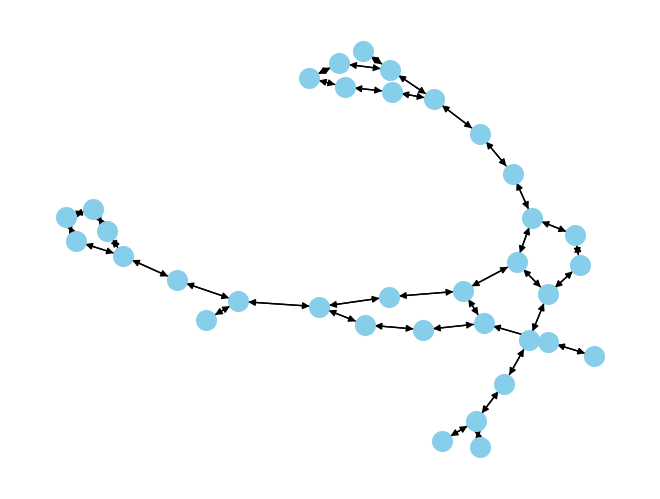

In [29]:
def visualize_dgl_graph(dgl_graph):
    g = dgl.to_networkx(dgl_graph)  # Convert DGL graph to a NetworkX graph
    pos = nx.spring_layout(g)  # Position nodes using Fruchterman-Reingold force-directed algorithm
    nx.draw(g, pos, with_labels=False, node_color='skyblue', node_size=200, edge_color='black')
    plt.show()

# Visualize the first graph in the list
visualize_dgl_graph(loaded_graphs_orig[42])

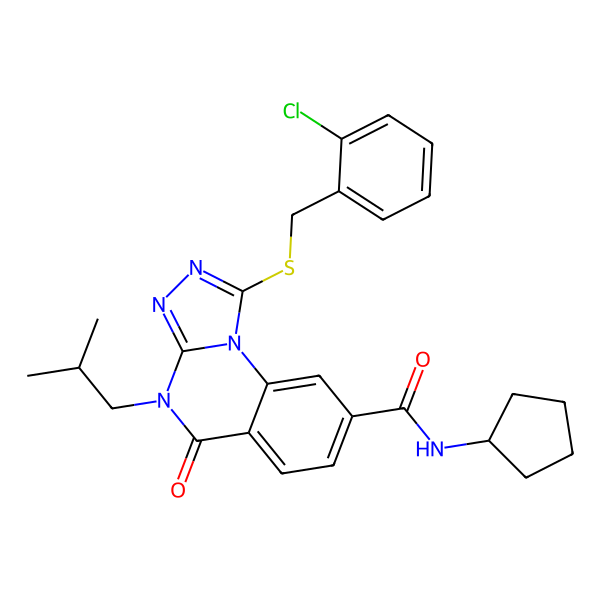

In [30]:

mol = df_small['mol'][42]
AllChem.Compute2DCoords(mol)
# draw the molecule
Draw.MolToImage(mol, size=(600, 600))

# Create train and test set

In [31]:
# First split into training and test sets
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    loaded_graphs_orig, 
    reconstructed_df['rna'], 
    test_size=0.2, 
    random_state=42
)

# Further split the training set into training and validation sets
train_graphs, val_graphs, train_labels, val_labels = train_test_split(
    train_graphs, 
    train_labels, 
    test_size=0.2,  # 20% of the original training set for validation
    random_state=42
)

# merge train and val,  labels are Series
train_graphs_all = train_graphs + val_graphs
train_labels_all = pd.concat([train_labels, val_labels])

there was a problem with few isolated nodes in few graphs so I added loops to each node to have information at least about themselfs

In [32]:
for i, g in enumerate(train_graphs):
    if (g.in_degrees() == 0).any():
        print(f"Graph {i} has isolated nodes")

# if there is not any isolated nodes in train_graphs, print 'No isolated nodes'
print('No isolated nodes')

for i, g in enumerate(test_graphs):
    if (g.in_degrees() == 0).any():
        print(f"Graph {i} has isolated nodes")

# if there is not any isolated nodes in train_graphs, print 'No isolated nodes'
print('No isolated nodes')

No isolated nodes


No isolated nodes


# Graph Convolutional Network Model (GCN)

In [33]:
class GCNClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size):
        super(GCNClassifier, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_size)
        self.conv2 = dglnn.GraphConv(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, g, features):
        x = F.relu(self.conv1(g, features))
        x = F.relu(self.conv2(g, x))
        g.ndata['h'] = x
        x = dgl.mean_nodes(g, 'h')
        return self.fc(x)


## Instance of the the GCN Model

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
in_feats = train_graphs[0].ndata['h'].shape[1]  # Replace with your feature size
model = GCNClassifier(in_feats, hidden_size=148).to(device)  # hidden_size is set to 74,  num_classes=2

# Loss and optimizer
# criterion = nn.CrossEntropyLoss() 
criterion = nn.BCEWithLogitsLoss()  # Use this loss if you are using a sigmoid activation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)



## Train the GCN model

In [35]:
class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        
        # Reset index if labels is a pandas DataFrame/Series to ensure continuous indexing
        if isinstance(labels, pd.DataFrame) or isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels

    def __len__(self):
        # The lengths of graphs and labels should be the same
        assert len(self.graphs) == len(self.labels), "Graphs and labels must have the same length"
        return len(self.graphs)

    def __getitem__(self, idx):
        try:
            graph = self.graphs[idx]
            label = self.labels[idx]
            return graph, label
        except IndexError:
            print(f"IndexError: Index {idx} out of range for dataset of size {len(self)}")
            raise
        
        

In [36]:
def collate_graphs(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.float32)
    return batched_graph, labels



In [37]:
batch_size = 1024
num_workers = 10

# Assuming train_labels and test_labels are originally 1D tensors or lists
# Create the datasets with updated labels
# Create the DataLoader with multiple workers

if isinstance(train_labels, torch.Tensor):
    train_labels = train_labels.tolist()
train_dataset = GraphDataset(train_graphs, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(test_labels, torch.Tensor):
    test_labels = test_labels.tolist()
test_dataset = GraphDataset(test_graphs, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(val_labels, torch.Tensor):
    val_labels = val_labels.tolist()
val_dataset = GraphDataset(val_graphs, val_labels)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)

if isinstance(train_labels_all, torch.Tensor):
    train_labels_all = train_labels_all.tolist()
train_dataset_all = GraphDataset(train_graphs_all, train_labels_all)
train_loader_all = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_graphs)



In [38]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        
        # batch_labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)



In [39]:
def validate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    y_true = []
    y_pred = []
    y_pred_proba = []
    with torch.no_grad():
        for graphs, labels in data_loader:
            graphs = graphs.to(device)
            features = graphs.ndata['h'].to(device)
            labels = labels.to(device)
            outputs = model(graphs, features)
            if outputs.dim() == 2 and outputs.shape[0] == 1:
                outputs = outputs.squeeze(0)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Check the dimension of outputs before applying torch.max
            if outputs.dim() > 1:
                _, predicted = torch.max(outputs.data, 1)
            else:
                predicted = outputs.round()  # Assuming binary classification

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(outputs.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    return avg_loss, y_true, y_pred, y_pred_proba



In [40]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.epochs_no_improve = 0
        self.early_stop = False
        self.stopped_epoch = 0  # Attribute to store the epoch number

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                self.stopped_epoch = epoch  # Store the epoch number



In [41]:
num_epochs = 500
early_stopping = EarlyStopping(patience=20, min_delta=0.002)

# Initialize lists to store loss values
gcn_train_loss_list = []
gcn_val_loss_list = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    gcn_train_loss_list.append(train_loss)  # Store train loss

    # Validation
    val_loss, _, _, _ = validate(model, val_loader, criterion, device)
    gcn_val_loss_list.append(val_loss)  # Store validation loss

    # Print and check for early stopping
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    early_stopping(val_loss, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break


# Store the epoch number when early stopping was triggered
num_epochs_early = early_stopping.stopped_epoch + 1



Epoch: 1, train_loss: 0.6906, val_loss: 0.6877


Epoch: 2, train_loss: 0.6852, val_loss: 0.6815


Epoch: 3, train_loss: 0.6780, val_loss: 0.6729


Epoch: 4, train_loss: 0.6681, val_loss: 0.6616


Epoch: 5, train_loss: 0.6565, val_loss: 0.6500


Epoch: 6, train_loss: 0.6460, val_loss: 0.6402


Epoch: 7, train_loss: 0.6372, val_loss: 0.6329


Epoch: 8, train_loss: 0.6301, val_loss: 0.6274


Epoch: 9, train_loss: 0.6239, val_loss: 0.6201


Epoch: 10, train_loss: 0.6177, val_loss: 0.6148


Epoch: 11, train_loss: 0.6133, val_loss: 0.6101


Epoch: 12, train_loss: 0.6089, val_loss: 0.6072


Epoch: 13, train_loss: 0.6053, val_loss: 0.6028


Epoch: 14, train_loss: 0.6023, val_loss: 0.6001


Epoch: 15, train_loss: 0.5993, val_loss: 0.5971


Epoch: 16, train_loss: 0.5970, val_loss: 0.5948


Epoch: 17, train_loss: 0.5947, val_loss: 0.5927


Epoch: 18, train_loss: 0.5928, val_loss: 0.5907


Epoch: 19, train_loss: 0.5907, val_loss: 0.5889


Epoch: 20, train_loss: 0.5892, val_loss: 0.5874


Epoch: 21, train_loss: 0.5875, val_loss: 0.5856


Epoch: 22, train_loss: 0.5860, val_loss: 0.5841


Epoch: 23, train_loss: 0.5845, val_loss: 0.5827


Epoch: 24, train_loss: 0.5831, val_loss: 0.5815


Epoch: 25, train_loss: 0.5818, val_loss: 0.5804


Epoch: 26, train_loss: 0.5807, val_loss: 0.5795


Epoch: 27, train_loss: 0.5797, val_loss: 0.5773


Epoch: 28, train_loss: 0.5780, val_loss: 0.5767


Epoch: 29, train_loss: 0.5767, val_loss: 0.5748


Epoch: 30, train_loss: 0.5757, val_loss: 0.5735


Epoch: 31, train_loss: 0.5746, val_loss: 0.5724


Epoch: 32, train_loss: 0.5734, val_loss: 0.5713


Epoch: 33, train_loss: 0.5721, val_loss: 0.5707


Epoch: 34, train_loss: 0.5715, val_loss: 0.5710


Epoch: 35, train_loss: 0.5704, val_loss: 0.5684


Epoch: 36, train_loss: 0.5689, val_loss: 0.5678


Epoch: 37, train_loss: 0.5683, val_loss: 0.5668


Epoch: 38, train_loss: 0.5671, val_loss: 0.5652


Epoch: 39, train_loss: 0.5664, val_loss: 0.5644


Epoch: 40, train_loss: 0.5658, val_loss: 0.5635


Epoch: 41, train_loss: 0.5644, val_loss: 0.5625


Epoch: 42, train_loss: 0.5639, val_loss: 0.5628


Epoch: 43, train_loss: 0.5628, val_loss: 0.5609


Epoch: 44, train_loss: 0.5622, val_loss: 0.5614


Epoch: 45, train_loss: 0.5613, val_loss: 0.5593


Epoch: 46, train_loss: 0.5604, val_loss: 0.5585


Epoch: 47, train_loss: 0.5597, val_loss: 0.5577


Epoch: 48, train_loss: 0.5589, val_loss: 0.5569


Epoch: 49, train_loss: 0.5579, val_loss: 0.5568


Epoch: 50, train_loss: 0.5573, val_loss: 0.5558


Epoch: 51, train_loss: 0.5567, val_loss: 0.5547


Epoch: 52, train_loss: 0.5560, val_loss: 0.5539


Epoch: 53, train_loss: 0.5555, val_loss: 0.5532


Epoch: 54, train_loss: 0.5544, val_loss: 0.5525


Epoch: 55, train_loss: 0.5537, val_loss: 0.5518


Epoch: 56, train_loss: 0.5528, val_loss: 0.5525


Epoch: 57, train_loss: 0.5527, val_loss: 0.5511


Epoch: 58, train_loss: 0.5514, val_loss: 0.5499


Epoch: 59, train_loss: 0.5510, val_loss: 0.5493


Epoch: 60, train_loss: 0.5502, val_loss: 0.5484


Epoch: 61, train_loss: 0.5496, val_loss: 0.5485


Epoch: 62, train_loss: 0.5491, val_loss: 0.5471


Epoch: 63, train_loss: 0.5485, val_loss: 0.5466


Epoch: 64, train_loss: 0.5477, val_loss: 0.5459


Epoch: 65, train_loss: 0.5466, val_loss: 0.5455


Epoch: 66, train_loss: 0.5462, val_loss: 0.5451


Epoch: 67, train_loss: 0.5456, val_loss: 0.5441


Epoch: 68, train_loss: 0.5446, val_loss: 0.5443


Epoch: 69, train_loss: 0.5454, val_loss: 0.5429


Epoch: 70, train_loss: 0.5435, val_loss: 0.5421


Epoch: 71, train_loss: 0.5429, val_loss: 0.5414


Epoch: 72, train_loss: 0.5424, val_loss: 0.5410


Epoch: 73, train_loss: 0.5426, val_loss: 0.5409


Epoch: 74, train_loss: 0.5414, val_loss: 0.5398


Epoch: 75, train_loss: 0.5406, val_loss: 0.5392


Epoch: 76, train_loss: 0.5402, val_loss: 0.5389


Epoch: 77, train_loss: 0.5394, val_loss: 0.5383


Epoch: 78, train_loss: 0.5391, val_loss: 0.5376


Epoch: 79, train_loss: 0.5382, val_loss: 0.5370


Epoch: 80, train_loss: 0.5377, val_loss: 0.5366


Epoch: 81, train_loss: 0.5373, val_loss: 0.5360


Epoch: 82, train_loss: 0.5368, val_loss: 0.5368


Epoch: 83, train_loss: 0.5367, val_loss: 0.5360


Epoch: 84, train_loss: 0.5358, val_loss: 0.5361


Epoch: 85, train_loss: 0.5350, val_loss: 0.5346


Epoch: 86, train_loss: 0.5352, val_loss: 0.5336


Epoch: 87, train_loss: 0.5343, val_loss: 0.5334


Epoch: 88, train_loss: 0.5334, val_loss: 0.5327


Epoch: 89, train_loss: 0.5332, val_loss: 0.5323


Epoch: 90, train_loss: 0.5326, val_loss: 0.5321


Epoch: 91, train_loss: 0.5327, val_loss: 0.5318


Epoch: 92, train_loss: 0.5320, val_loss: 0.5310


Epoch: 93, train_loss: 0.5315, val_loss: 0.5337


Epoch: 94, train_loss: 0.5310, val_loss: 0.5300


Epoch: 95, train_loss: 0.5302, val_loss: 0.5295


Epoch: 96, train_loss: 0.5301, val_loss: 0.5291


Epoch: 97, train_loss: 0.5293, val_loss: 0.5287


Epoch: 98, train_loss: 0.5292, val_loss: 0.5281


Epoch: 99, train_loss: 0.5285, val_loss: 0.5279


Epoch: 100, train_loss: 0.5279, val_loss: 0.5276


Epoch: 101, train_loss: 0.5274, val_loss: 0.5268


Epoch: 102, train_loss: 0.5268, val_loss: 0.5263


Epoch: 103, train_loss: 0.5265, val_loss: 0.5265


Epoch: 104, train_loss: 0.5260, val_loss: 0.5261


Epoch: 105, train_loss: 0.5256, val_loss: 0.5251


Epoch: 106, train_loss: 0.5249, val_loss: 0.5247


Epoch: 107, train_loss: 0.5248, val_loss: 0.5243


Epoch: 108, train_loss: 0.5243, val_loss: 0.5240


Epoch: 109, train_loss: 0.5248, val_loss: 0.5251


Epoch: 110, train_loss: 0.5235, val_loss: 0.5238


Epoch: 111, train_loss: 0.5237, val_loss: 0.5230


Epoch: 112, train_loss: 0.5234, val_loss: 0.5226


Epoch: 113, train_loss: 0.5221, val_loss: 0.5220


Epoch: 114, train_loss: 0.5227, val_loss: 0.5217


Epoch: 115, train_loss: 0.5215, val_loss: 0.5214


Epoch: 116, train_loss: 0.5213, val_loss: 0.5221


Epoch: 117, train_loss: 0.5213, val_loss: 0.5224


Epoch: 118, train_loss: 0.5204, val_loss: 0.5217


Epoch: 119, train_loss: 0.5199, val_loss: 0.5199


Epoch: 120, train_loss: 0.5195, val_loss: 0.5204


Epoch: 121, train_loss: 0.5192, val_loss: 0.5193


Epoch: 122, train_loss: 0.5190, val_loss: 0.5189


Epoch: 123, train_loss: 0.5184, val_loss: 0.5186


Epoch: 124, train_loss: 0.5179, val_loss: 0.5182


Epoch: 125, train_loss: 0.5177, val_loss: 0.5179


Epoch: 126, train_loss: 0.5174, val_loss: 0.5177


Epoch: 127, train_loss: 0.5169, val_loss: 0.5174


Epoch: 128, train_loss: 0.5169, val_loss: 0.5169


Epoch: 129, train_loss: 0.5166, val_loss: 0.5166


Epoch: 130, train_loss: 0.5161, val_loss: 0.5166


Epoch: 131, train_loss: 0.5158, val_loss: 0.5158


Epoch: 132, train_loss: 0.5153, val_loss: 0.5158


Epoch: 133, train_loss: 0.5150, val_loss: 0.5153


Epoch: 134, train_loss: 0.5147, val_loss: 0.5155


Epoch: 135, train_loss: 0.5142, val_loss: 0.5148


Epoch: 136, train_loss: 0.5141, val_loss: 0.5153


Epoch: 137, train_loss: 0.5141, val_loss: 0.5141


Epoch: 138, train_loss: 0.5133, val_loss: 0.5137


Epoch: 139, train_loss: 0.5135, val_loss: 0.5136


Epoch: 140, train_loss: 0.5135, val_loss: 0.5132


Epoch: 141, train_loss: 0.5125, val_loss: 0.5130


Epoch: 142, train_loss: 0.5122, val_loss: 0.5133


Epoch: 143, train_loss: 0.5122, val_loss: 0.5122


Epoch: 144, train_loss: 0.5114, val_loss: 0.5137


Epoch: 145, train_loss: 0.5116, val_loss: 0.5116


Epoch: 146, train_loss: 0.5110, val_loss: 0.5131


Epoch: 147, train_loss: 0.5109, val_loss: 0.5111


Epoch: 148, train_loss: 0.5114, val_loss: 0.5130


Epoch: 149, train_loss: 0.5104, val_loss: 0.5105


Epoch: 150, train_loss: 0.5094, val_loss: 0.5110


Epoch: 151, train_loss: 0.5094, val_loss: 0.5103


Epoch: 152, train_loss: 0.5092, val_loss: 0.5106


Epoch: 153, train_loss: 0.5101, val_loss: 0.5095


Epoch: 154, train_loss: 0.5088, val_loss: 0.5092


Epoch: 155, train_loss: 0.5080, val_loss: 0.5091


Epoch: 156, train_loss: 0.5079, val_loss: 0.5097


Epoch: 157, train_loss: 0.5079, val_loss: 0.5093


Epoch: 158, train_loss: 0.5075, val_loss: 0.5091


Epoch: 159, train_loss: 0.5072, val_loss: 0.5080


Epoch: 160, train_loss: 0.5069, val_loss: 0.5080


Epoch: 161, train_loss: 0.5066, val_loss: 0.5077


Epoch: 162, train_loss: 0.5059, val_loss: 0.5070


Epoch: 163, train_loss: 0.5060, val_loss: 0.5070


Epoch: 164, train_loss: 0.5057, val_loss: 0.5071


Epoch: 165, train_loss: 0.5055, val_loss: 0.5064


Epoch: 166, train_loss: 0.5063, val_loss: 0.5059


Epoch: 167, train_loss: 0.5051, val_loss: 0.5056


Epoch: 168, train_loss: 0.5049, val_loss: 0.5054


Epoch: 169, train_loss: 0.5043, val_loss: 0.5054


Epoch: 170, train_loss: 0.5046, val_loss: 0.5053


Epoch: 171, train_loss: 0.5042, val_loss: 0.5051


Epoch: 172, train_loss: 0.5039, val_loss: 0.5043


Epoch: 173, train_loss: 0.5037, val_loss: 0.5041


Epoch: 174, train_loss: 0.5041, val_loss: 0.5047


Epoch: 175, train_loss: 0.5034, val_loss: 0.5043


Epoch: 176, train_loss: 0.5032, val_loss: 0.5045


Epoch: 177, train_loss: 0.5023, val_loss: 0.5035


Epoch: 178, train_loss: 0.5026, val_loss: 0.5036


Epoch: 179, train_loss: 0.5016, val_loss: 0.5035


Epoch: 180, train_loss: 0.5014, val_loss: 0.5037


Epoch: 181, train_loss: 0.5015, val_loss: 0.5021


Epoch: 182, train_loss: 0.5012, val_loss: 0.5020


Epoch: 183, train_loss: 0.5008, val_loss: 0.5017


Epoch: 184, train_loss: 0.5010, val_loss: 0.5048


Epoch: 185, train_loss: 0.5010, val_loss: 0.5017


Epoch: 186, train_loss: 0.5001, val_loss: 0.5018


Epoch: 187, train_loss: 0.5005, val_loss: 0.5009


Epoch: 188, train_loss: 0.4996, val_loss: 0.5007


Epoch: 189, train_loss: 0.4997, val_loss: 0.5018


Epoch: 190, train_loss: 0.4993, val_loss: 0.5026


Epoch: 191, train_loss: 0.4993, val_loss: 0.5001


Epoch: 192, train_loss: 0.4991, val_loss: 0.5005


Epoch: 193, train_loss: 0.4988, val_loss: 0.5007


Epoch: 194, train_loss: 0.4985, val_loss: 0.4993


Epoch: 195, train_loss: 0.4984, val_loss: 0.5005


Epoch: 196, train_loss: 0.4978, val_loss: 0.4991


Epoch: 197, train_loss: 0.4978, val_loss: 0.4989


Epoch: 198, train_loss: 0.4980, val_loss: 0.4987


Epoch: 199, train_loss: 0.4974, val_loss: 0.4983


Epoch: 200, train_loss: 0.4970, val_loss: 0.4989


Epoch: 201, train_loss: 0.4972, val_loss: 0.4980


Epoch: 202, train_loss: 0.4971, val_loss: 0.4979


Epoch: 203, train_loss: 0.4968, val_loss: 0.4981


Epoch: 204, train_loss: 0.4966, val_loss: 0.4980


Epoch: 205, train_loss: 0.4966, val_loss: 0.4975


Epoch: 206, train_loss: 0.4965, val_loss: 0.4970


Epoch: 207, train_loss: 0.4957, val_loss: 0.4968


Epoch: 208, train_loss: 0.4954, val_loss: 0.4967


Epoch: 209, train_loss: 0.4959, val_loss: 0.4965


Epoch: 210, train_loss: 0.4951, val_loss: 0.4975


Epoch: 211, train_loss: 0.4955, val_loss: 0.4961


Epoch: 212, train_loss: 0.4954, val_loss: 0.4960


Epoch: 213, train_loss: 0.4948, val_loss: 0.4957


Epoch: 214, train_loss: 0.4948, val_loss: 0.4964


Epoch: 215, train_loss: 0.4949, val_loss: 0.4965


Epoch: 216, train_loss: 0.4942, val_loss: 0.4953


Epoch: 217, train_loss: 0.4934, val_loss: 0.4957


Epoch: 218, train_loss: 0.4949, val_loss: 0.4973


Epoch: 219, train_loss: 0.4939, val_loss: 0.4951


Epoch: 220, train_loss: 0.4936, val_loss: 0.4946


Epoch: 221, train_loss: 0.4937, val_loss: 0.4944


Epoch: 222, train_loss: 0.4935, val_loss: 0.4952


Epoch: 223, train_loss: 0.4932, val_loss: 0.4942


Epoch: 224, train_loss: 0.4928, val_loss: 0.4941


Epoch: 225, train_loss: 0.4925, val_loss: 0.4940


Epoch: 226, train_loss: 0.4931, val_loss: 0.4937


Epoch: 227, train_loss: 0.4931, val_loss: 0.4936


Epoch: 228, train_loss: 0.4923, val_loss: 0.4937


Epoch: 229, train_loss: 0.4925, val_loss: 0.4943


Epoch: 230, train_loss: 0.4921, val_loss: 0.4932


Epoch: 231, train_loss: 0.4915, val_loss: 0.4941


Epoch: 232, train_loss: 0.4918, val_loss: 0.4929


Epoch: 233, train_loss: 0.4912, val_loss: 0.4929


Epoch: 234, train_loss: 0.4914, val_loss: 0.4927


Epoch: 235, train_loss: 0.4913, val_loss: 0.4929


Epoch: 236, train_loss: 0.4907, val_loss: 0.4922


Epoch: 237, train_loss: 0.4908, val_loss: 0.4939


Epoch: 238, train_loss: 0.4906, val_loss: 0.4919


Epoch: 239, train_loss: 0.4910, val_loss: 0.4918


Epoch: 240, train_loss: 0.4902, val_loss: 0.4919


Epoch: 241, train_loss: 0.4902, val_loss: 0.4914


Epoch: 242, train_loss: 0.4901, val_loss: 0.4917


Epoch: 243, train_loss: 0.4902, val_loss: 0.4936


Epoch: 244, train_loss: 0.4900, val_loss: 0.4917


Epoch: 245, train_loss: 0.4899, val_loss: 0.4909


Epoch: 246, train_loss: 0.4895, val_loss: 0.4914


Epoch: 247, train_loss: 0.4894, val_loss: 0.4909


Epoch: 248, train_loss: 0.4897, val_loss: 0.4906


Epoch: 249, train_loss: 0.4887, val_loss: 0.4913


Epoch: 250, train_loss: 0.4891, val_loss: 0.4908


Epoch: 251, train_loss: 0.4891, val_loss: 0.4902


Epoch: 252, train_loss: 0.4885, val_loss: 0.4899


Epoch: 253, train_loss: 0.4888, val_loss: 0.4898


Epoch: 254, train_loss: 0.4884, val_loss: 0.4897


Epoch: 255, train_loss: 0.4881, val_loss: 0.4904


Epoch: 256, train_loss: 0.4883, val_loss: 0.4897


Epoch: 257, train_loss: 0.4881, val_loss: 0.4897


Epoch: 258, train_loss: 0.4879, val_loss: 0.4892


Epoch: 259, train_loss: 0.4877, val_loss: 0.4894


Epoch: 260, train_loss: 0.4873, val_loss: 0.4888


Epoch: 261, train_loss: 0.4878, val_loss: 0.4888


Epoch: 262, train_loss: 0.4872, val_loss: 0.4888


Epoch: 263, train_loss: 0.4874, val_loss: 0.4906


Epoch: 264, train_loss: 0.4873, val_loss: 0.4884


Epoch: 265, train_loss: 0.4873, val_loss: 0.4892


Epoch: 266, train_loss: 0.4871, val_loss: 0.4883


Epoch: 267, train_loss: 0.4867, val_loss: 0.4892


Epoch: 268, train_loss: 0.4865, val_loss: 0.4889


Epoch: 269, train_loss: 0.4863, val_loss: 0.4888


Epoch: 270, train_loss: 0.4863, val_loss: 0.4905


Epoch: 271, train_loss: 0.4870, val_loss: 0.4884


Epoch: 272, train_loss: 0.4858, val_loss: 0.4883


Epoch: 273, train_loss: 0.4854, val_loss: 0.4881


Epoch: 274, train_loss: 0.4854, val_loss: 0.4877


Epoch: 275, train_loss: 0.4857, val_loss: 0.4872


Epoch: 276, train_loss: 0.4855, val_loss: 0.4897


Epoch: 277, train_loss: 0.4853, val_loss: 0.4875


Epoch: 278, train_loss: 0.4850, val_loss: 0.4869


Epoch: 279, train_loss: 0.4852, val_loss: 0.4868


Epoch: 280, train_loss: 0.4848, val_loss: 0.4878


Epoch: 281, train_loss: 0.4849, val_loss: 0.4874


Epoch: 282, train_loss: 0.4857, val_loss: 0.4864


Epoch: 283, train_loss: 0.4847, val_loss: 0.4864


Epoch: 284, train_loss: 0.4849, val_loss: 0.4872


Epoch: 285, train_loss: 0.4846, val_loss: 0.4859


Epoch: 286, train_loss: 0.4844, val_loss: 0.4859


Epoch: 287, train_loss: 0.4844, val_loss: 0.4860


Epoch: 288, train_loss: 0.4841, val_loss: 0.4857


Epoch: 289, train_loss: 0.4840, val_loss: 0.4856


Epoch: 290, train_loss: 0.4837, val_loss: 0.4860


Epoch: 291, train_loss: 0.4837, val_loss: 0.4853


Epoch: 292, train_loss: 0.4840, val_loss: 0.4853


Epoch: 293, train_loss: 0.4836, val_loss: 0.4856


Epoch: 294, train_loss: 0.4830, val_loss: 0.4853


Epoch: 295, train_loss: 0.4834, val_loss: 0.4853
Early stopping triggered at epoch 295


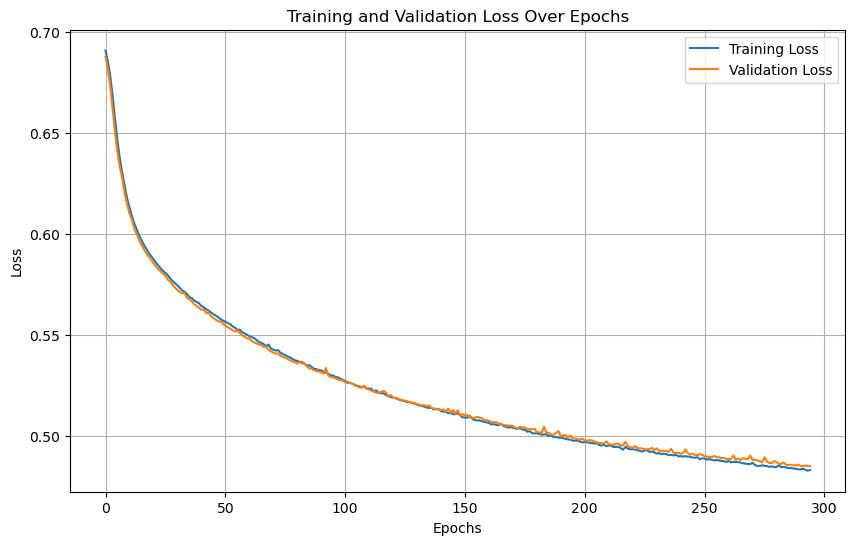

In [42]:
# Ensure that the length of gcn_train_loss_list and gcn_val_loss_list is equal to the number of epochs processed
assert len(gcn_train_loss_list) == len(gcn_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gcn_train_loss_list, label='Training Loss')
plt.plot(gcn_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train on merged train and val sets


In [43]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)


## Reset weights before training again with all data


In [44]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)


GCNClassifier(
  (conv1): GraphConv(in=74, out=148, normalization=both, activation=None)
  (conv2): GraphConv(in=148, out=148, normalization=both, activation=None)
  (fc): Linear(in_features=148, out_features=1, bias=True)
)

In [45]:
print("Final training on merged training and validation sets")

# Initialize list to store loss values
final_train_losses = []

for epoch in range(num_epochs_early):
    # Training
    train_loss = train(model, train_loader_all, criterion, optimizer, device)
    final_train_losses.append(train_loss)  # Store train loss

    # Print train loss
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}")


Final training on merged training and validation sets


Epoch 1/295, Train Loss: 0.6698


Epoch 2/295, Train Loss: 0.6386


Epoch 3/295, Train Loss: 0.6151


Epoch 4/295, Train Loss: 0.5977


Epoch 5/295, Train Loss: 0.5849


Epoch 6/295, Train Loss: 0.5751


Epoch 7/295, Train Loss: 0.5669


Epoch 8/295, Train Loss: 0.5601


Epoch 9/295, Train Loss: 0.5542


Epoch 10/295, Train Loss: 0.5492


Epoch 11/295, Train Loss: 0.5449


Epoch 12/295, Train Loss: 0.5411


Epoch 13/295, Train Loss: 0.5376


Epoch 14/295, Train Loss: 0.5345


Epoch 15/295, Train Loss: 0.5316


Epoch 16/295, Train Loss: 0.5291


Epoch 17/295, Train Loss: 0.5267


Epoch 18/295, Train Loss: 0.5245


Epoch 19/295, Train Loss: 0.5225


Epoch 20/295, Train Loss: 0.5207


Epoch 21/295, Train Loss: 0.5190


Epoch 22/295, Train Loss: 0.5174


Epoch 23/295, Train Loss: 0.5159


Epoch 24/295, Train Loss: 0.5145


Epoch 25/295, Train Loss: 0.5133


Epoch 26/295, Train Loss: 0.5120


Epoch 27/295, Train Loss: 0.5109


Epoch 28/295, Train Loss: 0.5098


Epoch 29/295, Train Loss: 0.5088


Epoch 30/295, Train Loss: 0.5078


Epoch 31/295, Train Loss: 0.5069


Epoch 32/295, Train Loss: 0.5060


Epoch 33/295, Train Loss: 0.5052


Epoch 34/295, Train Loss: 0.5044


Epoch 35/295, Train Loss: 0.5036


Epoch 36/295, Train Loss: 0.5029


Epoch 37/295, Train Loss: 0.5022


Epoch 38/295, Train Loss: 0.5016


Epoch 39/295, Train Loss: 0.5009


Epoch 40/295, Train Loss: 0.5003


Epoch 41/295, Train Loss: 0.4998


Epoch 42/295, Train Loss: 0.4992


Epoch 43/295, Train Loss: 0.4987


Epoch 44/295, Train Loss: 0.4982


Epoch 45/295, Train Loss: 0.4977


Epoch 46/295, Train Loss: 0.4972


Epoch 47/295, Train Loss: 0.4968


Epoch 48/295, Train Loss: 0.4963


Epoch 49/295, Train Loss: 0.4959


Epoch 50/295, Train Loss: 0.4955


Epoch 51/295, Train Loss: 0.4951


Epoch 52/295, Train Loss: 0.4947


Epoch 53/295, Train Loss: 0.4943


Epoch 54/295, Train Loss: 0.4940


Epoch 55/295, Train Loss: 0.4936


Epoch 56/295, Train Loss: 0.4933


Epoch 57/295, Train Loss: 0.4930


Epoch 58/295, Train Loss: 0.4927


Epoch 59/295, Train Loss: 0.4923


Epoch 60/295, Train Loss: 0.4920


Epoch 61/295, Train Loss: 0.4918


Epoch 62/295, Train Loss: 0.4915


Epoch 63/295, Train Loss: 0.4912


Epoch 64/295, Train Loss: 0.4909


Epoch 65/295, Train Loss: 0.4907


Epoch 66/295, Train Loss: 0.4904


Epoch 67/295, Train Loss: 0.4902


Epoch 68/295, Train Loss: 0.4899


Epoch 69/295, Train Loss: 0.4897


Epoch 70/295, Train Loss: 0.4895


Epoch 71/295, Train Loss: 0.4892


Epoch 72/295, Train Loss: 0.4890


Epoch 73/295, Train Loss: 0.4888


Epoch 74/295, Train Loss: 0.4886


Epoch 75/295, Train Loss: 0.4884


Epoch 76/295, Train Loss: 0.4882


Epoch 77/295, Train Loss: 0.4880


Epoch 78/295, Train Loss: 0.4878


Epoch 79/295, Train Loss: 0.4876


Epoch 80/295, Train Loss: 0.4874


Epoch 81/295, Train Loss: 0.4872


Epoch 82/295, Train Loss: 0.4870


Epoch 83/295, Train Loss: 0.4869


Epoch 84/295, Train Loss: 0.4867


Epoch 85/295, Train Loss: 0.4865


Epoch 86/295, Train Loss: 0.4863


Epoch 87/295, Train Loss: 0.4862


Epoch 88/295, Train Loss: 0.4860


Epoch 89/295, Train Loss: 0.4858


Epoch 90/295, Train Loss: 0.4856


Epoch 91/295, Train Loss: 0.4855


Epoch 92/295, Train Loss: 0.4853


Epoch 93/295, Train Loss: 0.4851


Epoch 94/295, Train Loss: 0.4850


Epoch 95/295, Train Loss: 0.4848


Epoch 96/295, Train Loss: 0.4847


Epoch 97/295, Train Loss: 0.4845


Epoch 98/295, Train Loss: 0.4844


Epoch 99/295, Train Loss: 0.4842


Epoch 100/295, Train Loss: 0.4841


Epoch 101/295, Train Loss: 0.4839


Epoch 102/295, Train Loss: 0.4838


Epoch 103/295, Train Loss: 0.4836


Epoch 104/295, Train Loss: 0.4835


Epoch 105/295, Train Loss: 0.4834


Epoch 106/295, Train Loss: 0.4832


Epoch 107/295, Train Loss: 0.4831


Epoch 108/295, Train Loss: 0.4830


Epoch 109/295, Train Loss: 0.4828


Epoch 110/295, Train Loss: 0.4827


Epoch 111/295, Train Loss: 0.4826


Epoch 112/295, Train Loss: 0.4824


Epoch 113/295, Train Loss: 0.4823


Epoch 114/295, Train Loss: 0.4822


Epoch 115/295, Train Loss: 0.4821


Epoch 116/295, Train Loss: 0.4819


Epoch 117/295, Train Loss: 0.4818


Epoch 118/295, Train Loss: 0.4817


Epoch 119/295, Train Loss: 0.4816


Epoch 120/295, Train Loss: 0.4815


Epoch 121/295, Train Loss: 0.4814


Epoch 122/295, Train Loss: 0.4812


Epoch 123/295, Train Loss: 0.4811


Epoch 124/295, Train Loss: 0.4810


Epoch 125/295, Train Loss: 0.4809


Epoch 126/295, Train Loss: 0.4808


Epoch 127/295, Train Loss: 0.4807


Epoch 128/295, Train Loss: 0.4806


Epoch 129/295, Train Loss: 0.4804


Epoch 130/295, Train Loss: 0.4803


Epoch 131/295, Train Loss: 0.4802


Epoch 132/295, Train Loss: 0.4801


Epoch 133/295, Train Loss: 0.4800


Epoch 134/295, Train Loss: 0.4799


Epoch 135/295, Train Loss: 0.4798


Epoch 136/295, Train Loss: 0.4797


Epoch 137/295, Train Loss: 0.4796


Epoch 138/295, Train Loss: 0.4795


Epoch 139/295, Train Loss: 0.4794


Epoch 140/295, Train Loss: 0.4793


Epoch 141/295, Train Loss: 0.4792


Epoch 142/295, Train Loss: 0.4790


Epoch 143/295, Train Loss: 0.4789


Epoch 144/295, Train Loss: 0.4788


Epoch 145/295, Train Loss: 0.4787


Epoch 146/295, Train Loss: 0.4786


Epoch 147/295, Train Loss: 0.4785


Epoch 148/295, Train Loss: 0.4784


Epoch 149/295, Train Loss: 0.4783


Epoch 150/295, Train Loss: 0.4782


Epoch 151/295, Train Loss: 0.4781


Epoch 152/295, Train Loss: 0.4780


Epoch 153/295, Train Loss: 0.4779


Epoch 154/295, Train Loss: 0.4778


Epoch 155/295, Train Loss: 0.4777


Epoch 156/295, Train Loss: 0.4776


Epoch 157/295, Train Loss: 0.4775


Epoch 158/295, Train Loss: 0.4774


Epoch 159/295, Train Loss: 0.4773


Epoch 160/295, Train Loss: 0.4772


Epoch 161/295, Train Loss: 0.4771


Epoch 162/295, Train Loss: 0.4771


Epoch 163/295, Train Loss: 0.4770


Epoch 164/295, Train Loss: 0.4769


Epoch 165/295, Train Loss: 0.4768


Epoch 166/295, Train Loss: 0.4767


Epoch 167/295, Train Loss: 0.4766


Epoch 168/295, Train Loss: 0.4765


Epoch 169/295, Train Loss: 0.4764


Epoch 170/295, Train Loss: 0.4763


Epoch 171/295, Train Loss: 0.4762


Epoch 172/295, Train Loss: 0.4761


Epoch 173/295, Train Loss: 0.4761


Epoch 174/295, Train Loss: 0.4760


Epoch 175/295, Train Loss: 0.4759


Epoch 176/295, Train Loss: 0.4758


Epoch 177/295, Train Loss: 0.4757


Epoch 178/295, Train Loss: 0.4756


Epoch 179/295, Train Loss: 0.4755


Epoch 180/295, Train Loss: 0.4754


Epoch 181/295, Train Loss: 0.4753


Epoch 182/295, Train Loss: 0.4752


Epoch 183/295, Train Loss: 0.4751


Epoch 184/295, Train Loss: 0.4751


Epoch 185/295, Train Loss: 0.4749


Epoch 186/295, Train Loss: 0.4748


Epoch 187/295, Train Loss: 0.4748


Epoch 188/295, Train Loss: 0.4747


Epoch 189/295, Train Loss: 0.4746


Epoch 190/295, Train Loss: 0.4745


Epoch 191/295, Train Loss: 0.4744


Epoch 192/295, Train Loss: 0.4743


Epoch 193/295, Train Loss: 0.4742


Epoch 194/295, Train Loss: 0.4741


Epoch 195/295, Train Loss: 0.4740


Epoch 196/295, Train Loss: 0.4739


Epoch 197/295, Train Loss: 0.4739


Epoch 198/295, Train Loss: 0.4738


Epoch 199/295, Train Loss: 0.4737


Epoch 200/295, Train Loss: 0.4736


Epoch 201/295, Train Loss: 0.4735


Epoch 202/295, Train Loss: 0.4734


Epoch 203/295, Train Loss: 0.4734


Epoch 204/295, Train Loss: 0.4733


Epoch 205/295, Train Loss: 0.4732


Epoch 206/295, Train Loss: 0.4731


Epoch 207/295, Train Loss: 0.4730


Epoch 208/295, Train Loss: 0.4729


Epoch 209/295, Train Loss: 0.4729


Epoch 210/295, Train Loss: 0.4728


Epoch 211/295, Train Loss: 0.4727


Epoch 212/295, Train Loss: 0.4726


Epoch 213/295, Train Loss: 0.4725


Epoch 214/295, Train Loss: 0.4724


Epoch 215/295, Train Loss: 0.4724


Epoch 216/295, Train Loss: 0.4723


Epoch 217/295, Train Loss: 0.4722


Epoch 218/295, Train Loss: 0.4721


Epoch 219/295, Train Loss: 0.4720


Epoch 220/295, Train Loss: 0.4720


Epoch 221/295, Train Loss: 0.4719


Epoch 222/295, Train Loss: 0.4718


Epoch 223/295, Train Loss: 0.4717


Epoch 224/295, Train Loss: 0.4716


Epoch 225/295, Train Loss: 0.4716


Epoch 226/295, Train Loss: 0.4715


Epoch 227/295, Train Loss: 0.4714


Epoch 228/295, Train Loss: 0.4713


Epoch 229/295, Train Loss: 0.4713


Epoch 230/295, Train Loss: 0.4712


Epoch 231/295, Train Loss: 0.4711


Epoch 232/295, Train Loss: 0.4710


Epoch 233/295, Train Loss: 0.4709


Epoch 234/295, Train Loss: 0.4709


Epoch 235/295, Train Loss: 0.4708


Epoch 236/295, Train Loss: 0.4707


Epoch 237/295, Train Loss: 0.4706


Epoch 238/295, Train Loss: 0.4706


Epoch 239/295, Train Loss: 0.4705


Epoch 240/295, Train Loss: 0.4704


Epoch 241/295, Train Loss: 0.4703


Epoch 242/295, Train Loss: 0.4703


Epoch 243/295, Train Loss: 0.4702


Epoch 244/295, Train Loss: 0.4701


Epoch 245/295, Train Loss: 0.4700


Epoch 246/295, Train Loss: 0.4700


Epoch 247/295, Train Loss: 0.4699


Epoch 248/295, Train Loss: 0.4698


Epoch 249/295, Train Loss: 0.4697


Epoch 250/295, Train Loss: 0.4697


Epoch 251/295, Train Loss: 0.4696


Epoch 252/295, Train Loss: 0.4695


Epoch 253/295, Train Loss: 0.4695


Epoch 254/295, Train Loss: 0.4694


Epoch 255/295, Train Loss: 0.4693


Epoch 256/295, Train Loss: 0.4692


Epoch 257/295, Train Loss: 0.4692


Epoch 258/295, Train Loss: 0.4691


Epoch 259/295, Train Loss: 0.4690


Epoch 260/295, Train Loss: 0.4690


Epoch 261/295, Train Loss: 0.4689


Epoch 262/295, Train Loss: 0.4688


Epoch 263/295, Train Loss: 0.4687


Epoch 264/295, Train Loss: 0.4687


Epoch 265/295, Train Loss: 0.4686


Epoch 266/295, Train Loss: 0.4685


Epoch 267/295, Train Loss: 0.4685


Epoch 268/295, Train Loss: 0.4684


Epoch 269/295, Train Loss: 0.4683


Epoch 270/295, Train Loss: 0.4683


Epoch 271/295, Train Loss: 0.4682


Epoch 272/295, Train Loss: 0.4681


Epoch 273/295, Train Loss: 0.4681


Epoch 274/295, Train Loss: 0.4680


Epoch 275/295, Train Loss: 0.4679


Epoch 276/295, Train Loss: 0.4679


Epoch 277/295, Train Loss: 0.4678


Epoch 278/295, Train Loss: 0.4677


Epoch 279/295, Train Loss: 0.4677


Epoch 280/295, Train Loss: 0.4676


Epoch 281/295, Train Loss: 0.4675


Epoch 282/295, Train Loss: 0.4675


Epoch 283/295, Train Loss: 0.4674


Epoch 284/295, Train Loss: 0.4673


Epoch 285/295, Train Loss: 0.4673


Epoch 286/295, Train Loss: 0.4672


Epoch 287/295, Train Loss: 0.4671


Epoch 288/295, Train Loss: 0.4671


Epoch 289/295, Train Loss: 0.4670


Epoch 290/295, Train Loss: 0.4669


Epoch 291/295, Train Loss: 0.4669


Epoch 292/295, Train Loss: 0.4668


Epoch 293/295, Train Loss: 0.4667


Epoch 294/295, Train Loss: 0.4667


Epoch 295/295, Train Loss: 0.4666


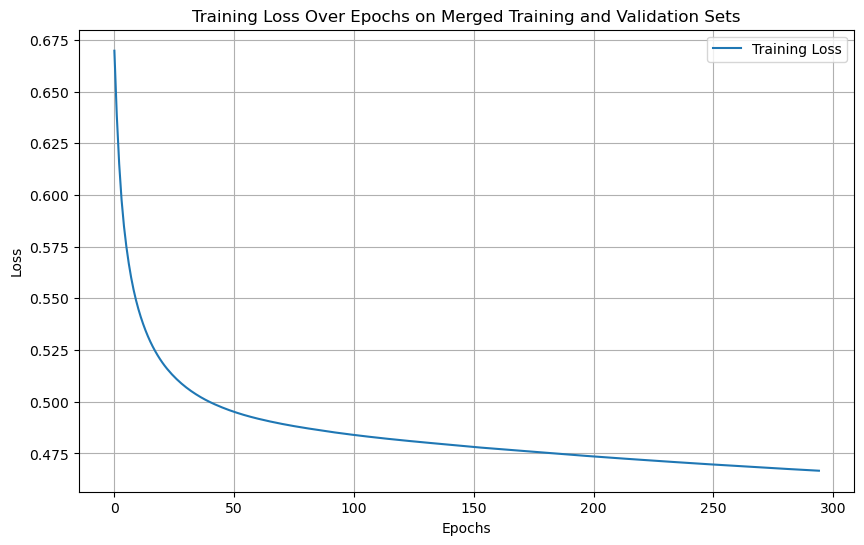

In [46]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [47]:
# if there is not a folder named 'model' create one
if not os.path.exists('model_experiment'):
    os.mkdir('model_experiment')

# save the model
torch.save(model.state_dict(), 'model_experiment/gcn_model_experiment.pth')

In [48]:
# load the model
model = GCNClassifier(in_feats, hidden_size=148).to(device)
model.load_state_dict(torch.load('model_experiment/gcn_model_experiment.pth'))

<All keys matched successfully>

## Test the model

In [49]:
def test(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_pred_proba = []

    with torch.no_grad():
        for graphs, labels in data_loader:
            graphs = graphs.to(device)
            features = graphs.ndata['h'].to(device)
            labels = labels.to(device)

            outputs = model(graphs, features)
            probabilities = torch.sigmoid(outputs).squeeze()  # Apply sigmoid to convert logits to probabilities

            predicted = (probabilities > 0.5).long()  # Convert probabilities to binary predictions

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(probabilities.cpu().numpy())

    return y_true, y_pred, y_pred_proba


## Predict probabilities

In [50]:
# Now you can use this DataLoader in your test function
y_true, y_pred, y_pred_proba = test(model, test_loader, device)

# Convert probabilities to percentages for the positive class
# Assuming binary classification and class '1' is the positive class
confidence_percentages = [prob * 100 for prob in y_pred_proba]

# Now 'confidence_percentages' holds the confidence level for each prediction


In [51]:
# Extract the second element (index 1) from each 1D array in y_pred_proba
# y_pred_proba = [prob[1] for prob in y_pred_proba]
# Now y_pred_proba is a list of probabilities for the positive class
# Convert it to a NumPy array
y_pred_proba = np.array(y_pred_proba)


## Results

In [52]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')


Accuracy: 0.7757368060315284
Precision: 0.7608355091383812
Recall: 0.8018712162905889
F1: 0.7808145766345123
AUC: 0.8576674990683304


In [53]:
# Accuracy: 0.7896446700507614
# Precision: 0.8110537951363301
# Recall: 0.7508527766407422
# F1: 0.7797931132209155
# AUC: 0.8738676601333576

## Confusion matrix

In [54]:
# create folder 'visuals' if it does not exist
if not os.path.exists('visuals'):
    os.mkdir('visuals')
    

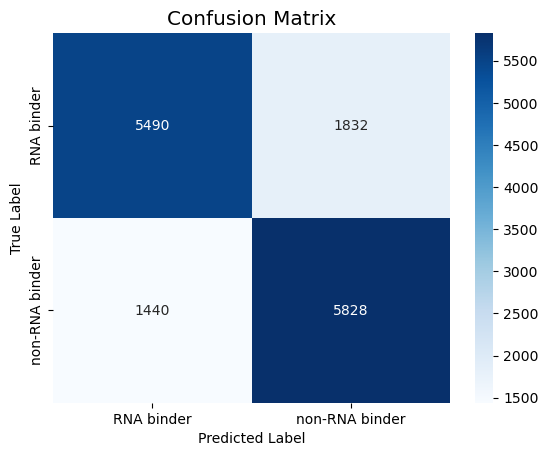

In [55]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_gcn_experiment.png', dpi=300)
plt.show()



## Classification report

In [56]:
# classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      7322
         1.0       0.76      0.80      0.78      7268

    accuracy                           0.78     14590
   macro avg       0.78      0.78      0.78     14590
weighted avg       0.78      0.78      0.78     14590



## ROC AUC

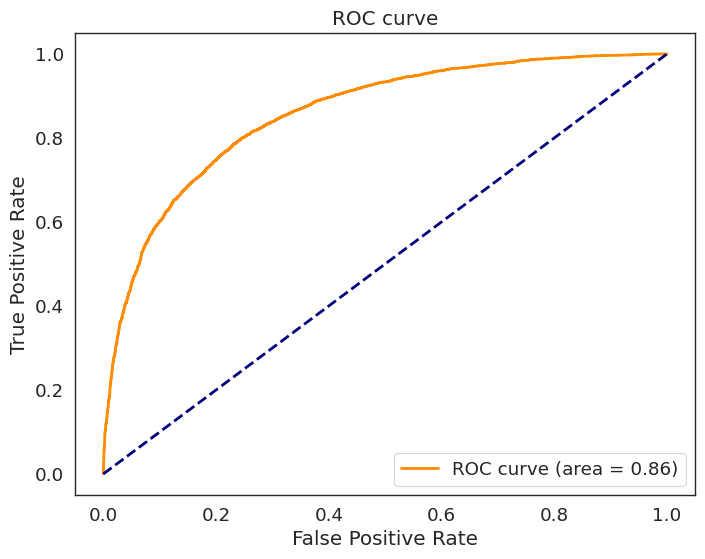

In [57]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_gcn_experiment.png', dpi=300)
plt.show()


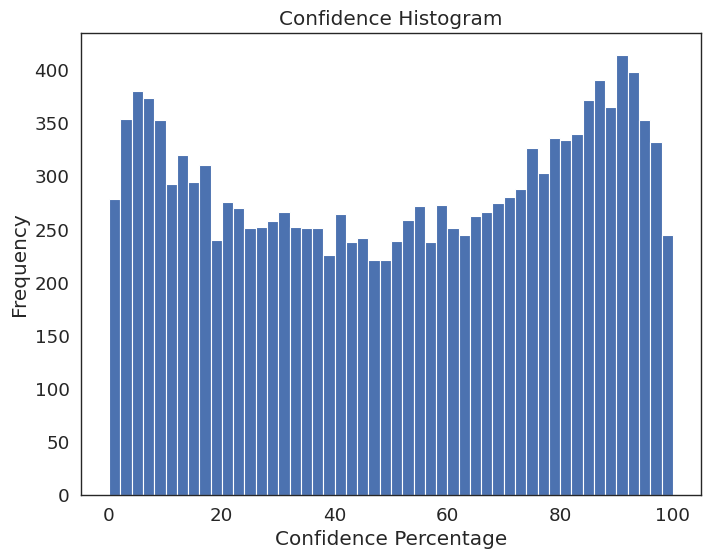

In [58]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_gcn_experiment.png', dpi=300)
plt.show()


In [59]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [60]:
top_molecule_row_indices

Index([  353, 15967, 71898, 12580, 14998, 18120, 72027, 15969, 14934, 10629,
       14355, 15067, 72406, 15137, 72329, 10566,   512, 72415, 68123, 21073],
      dtype='int64')

In [61]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_gcn_experiment'):
    os.mkdir('top_molecules_gcn_experiment')
    

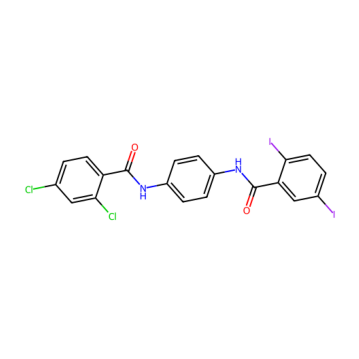

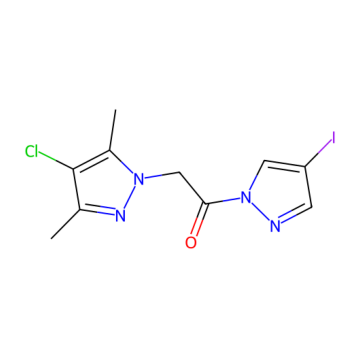

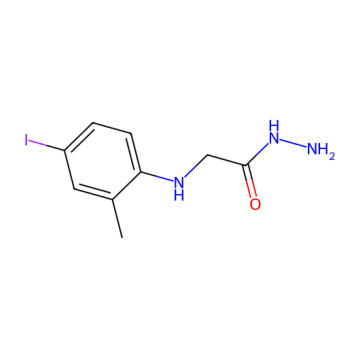

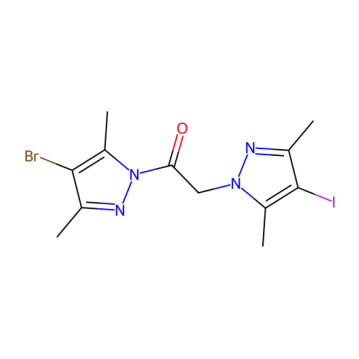

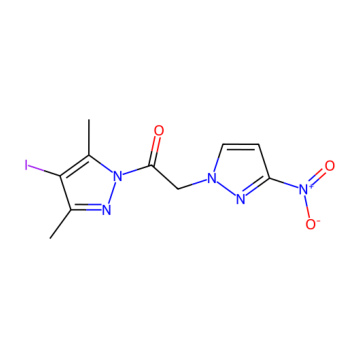

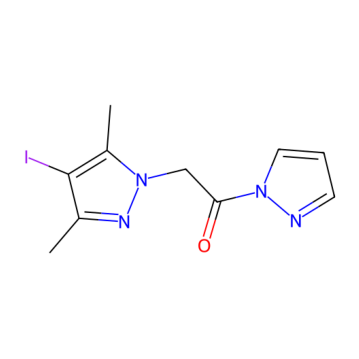

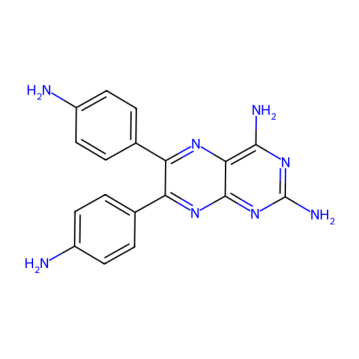

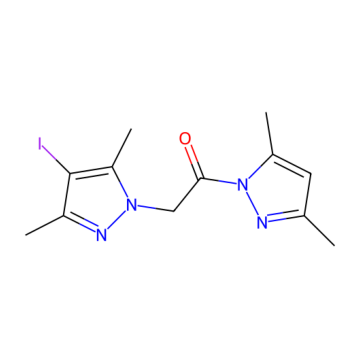

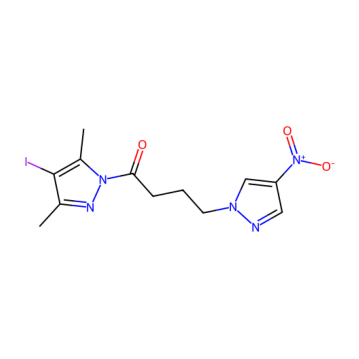

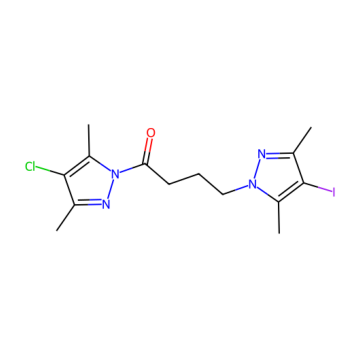

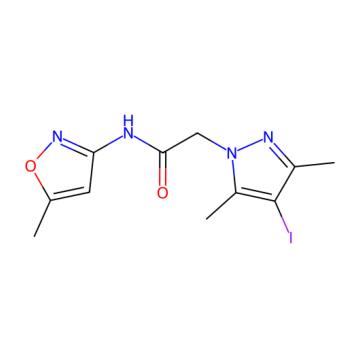

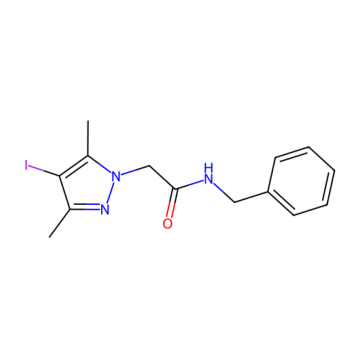

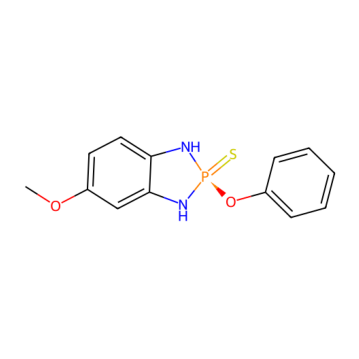

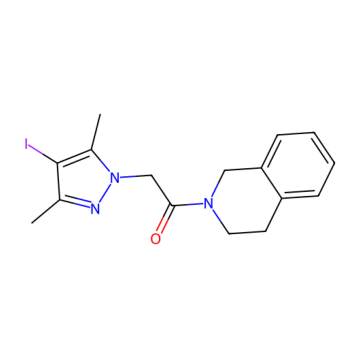

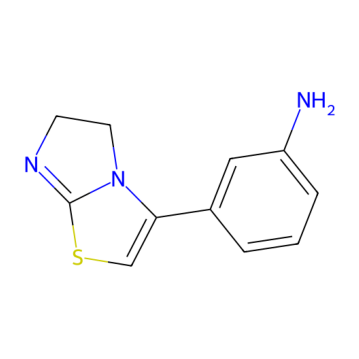

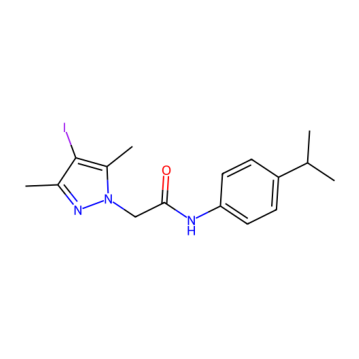

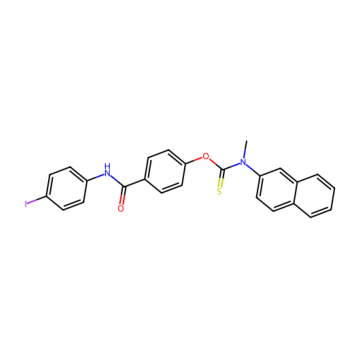

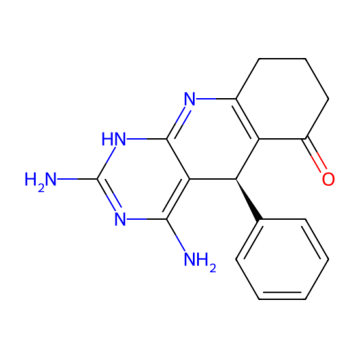

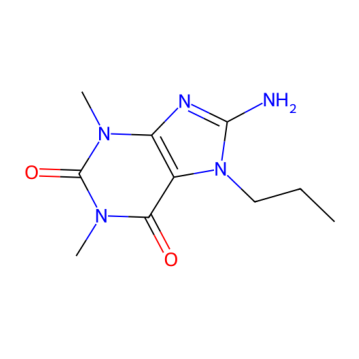

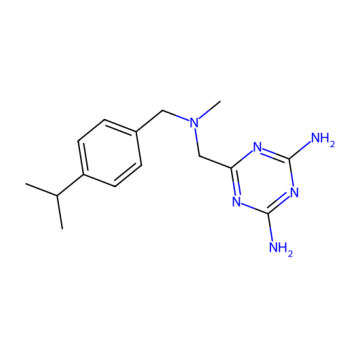

In [62]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gcn_experiment/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


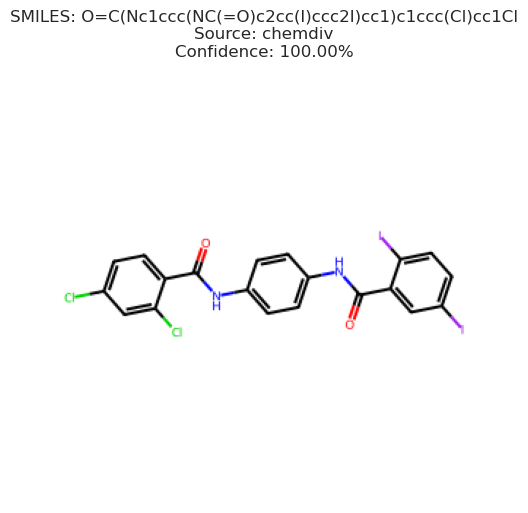

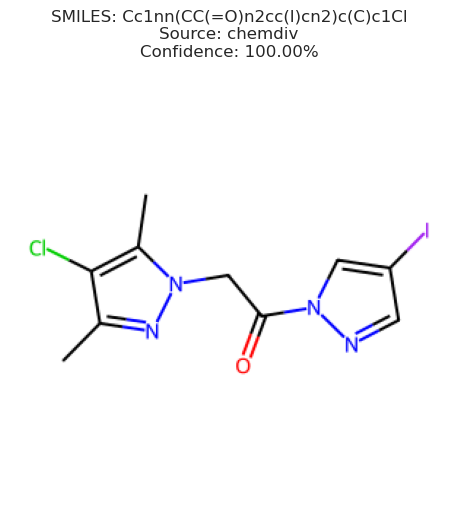

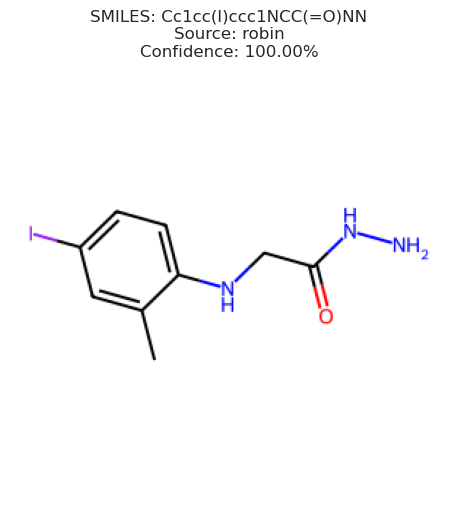

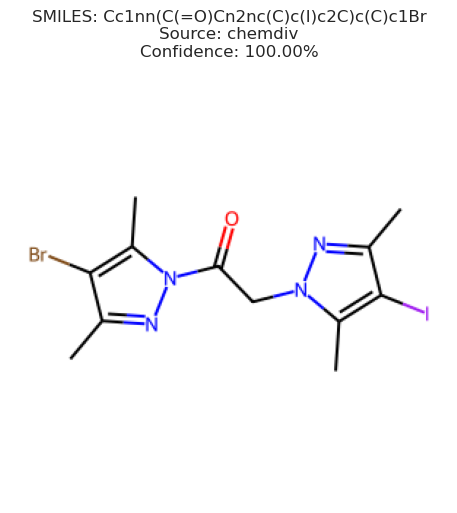

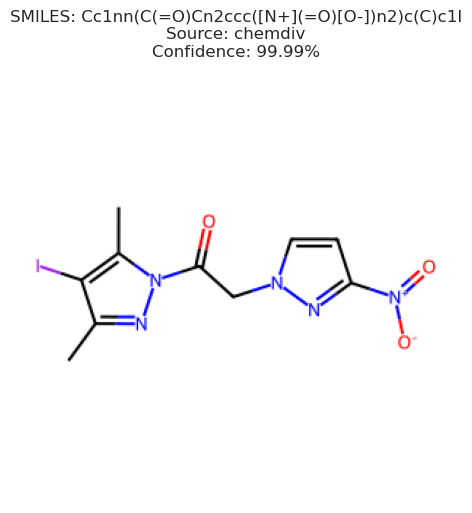

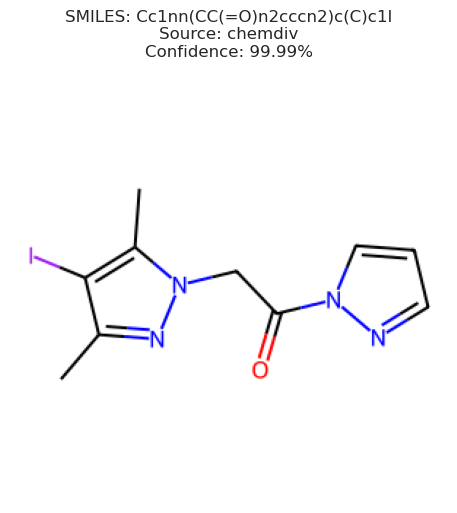

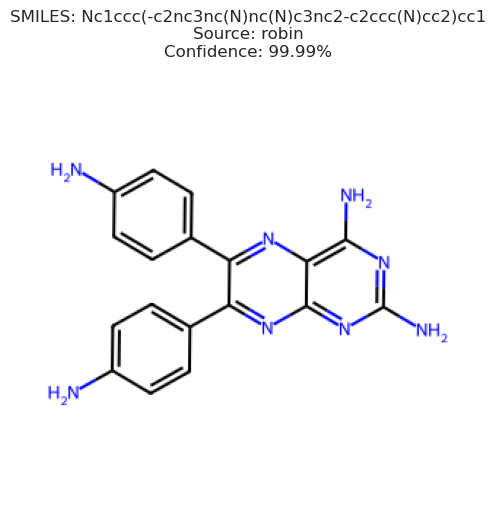

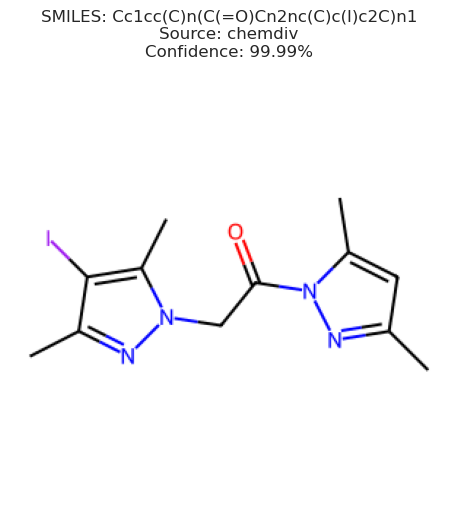

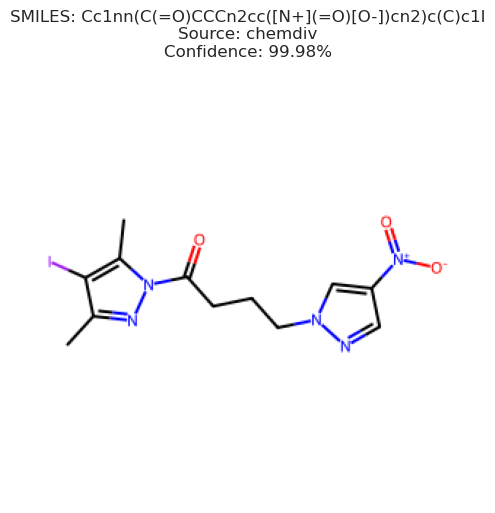

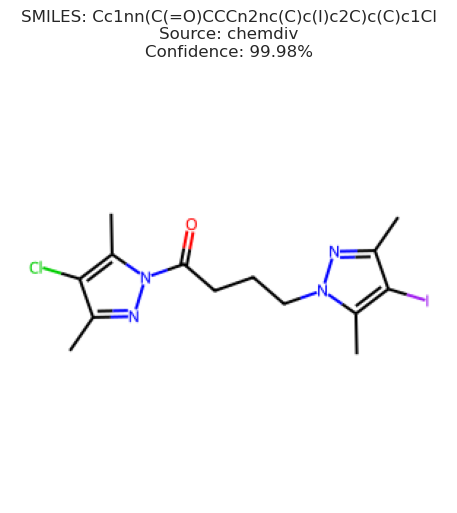

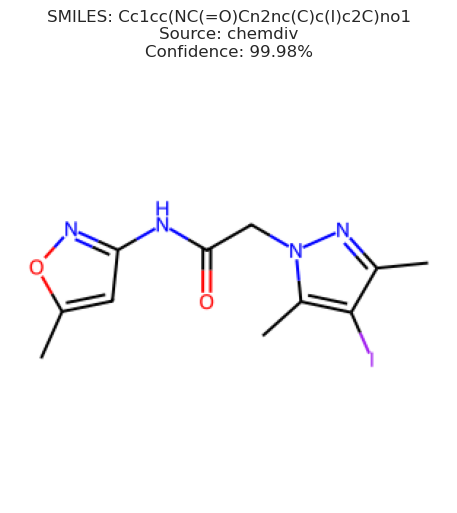

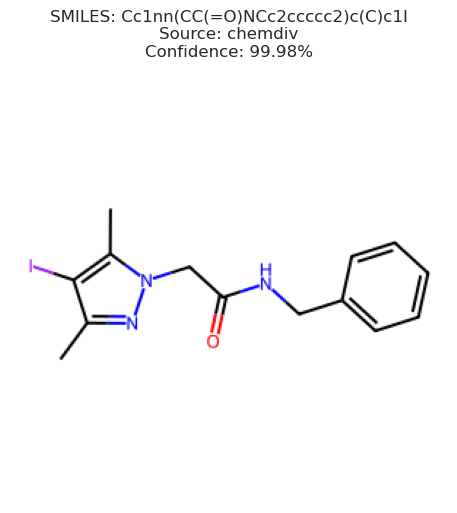

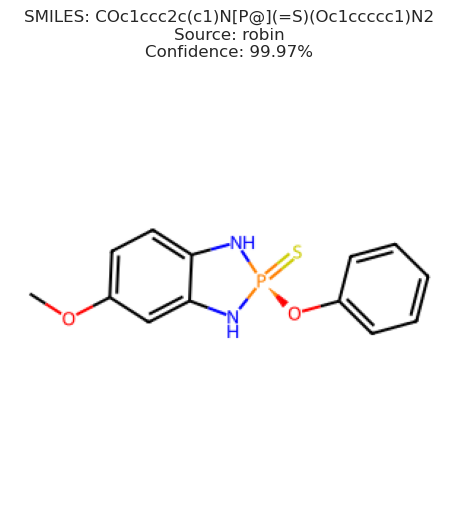

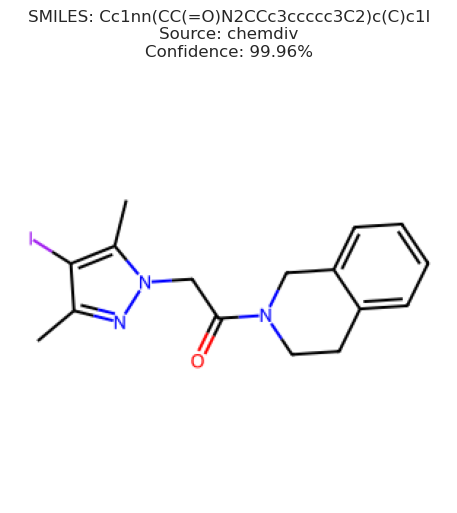

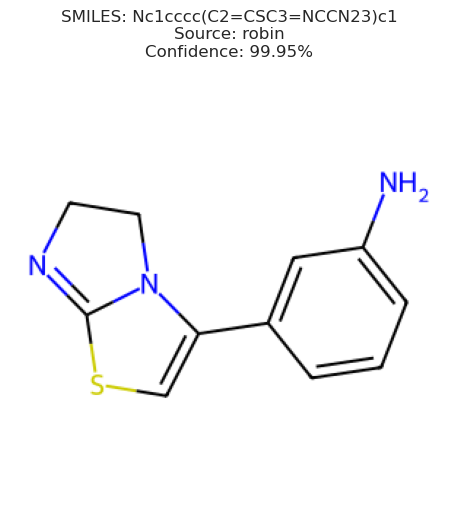

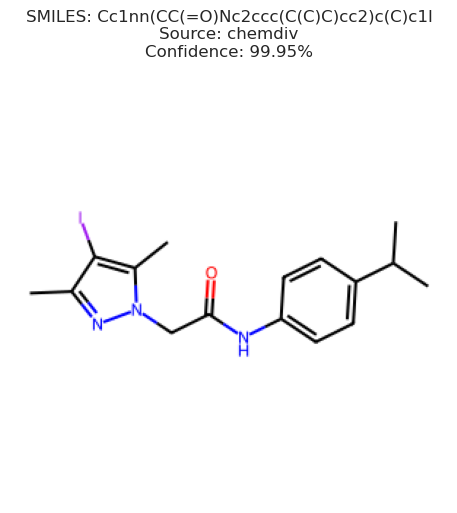

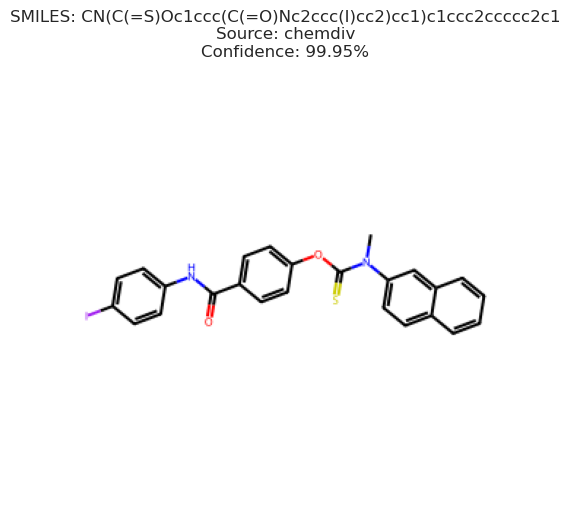

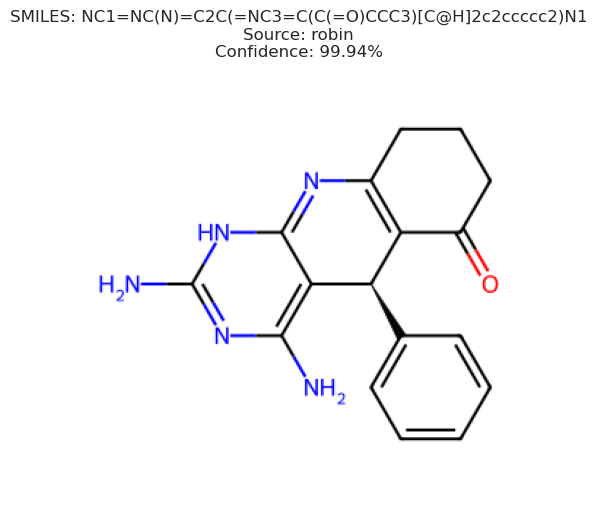

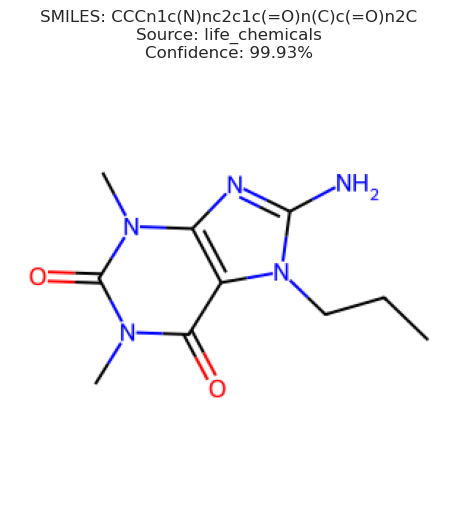

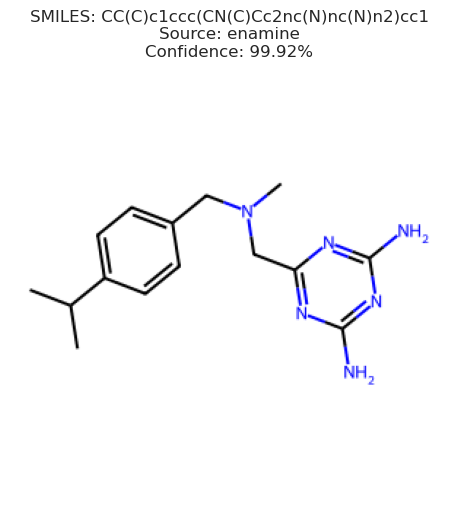

In [63]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gcn_experiment/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    # plt.show()


# Message Passing Neural Network (MPNN)

In [64]:
class MPNNClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size, out_feats):
        super(MPNNClassifier, self).__init__()
        self.edge_conv = dglnn.EdgeConv(in_feats, hidden_size)
        self.reduce_function = dgl.function.mean('m', 'h')
        self.fc = nn.Linear(74, out_feats)

    def forward(self, g, features):
        # Custom message function
        def message_function(edges):
            return {'m': edges.src['h'] + edges.dst['h']}

        # Message passing
        g.ndata['h'] = features
        g.apply_edges(message_function)
        g.update_all(dgl.function.copy_e('m', 'm'), self.reduce_function)
        
        x = dgl.mean_nodes(g, 'h')
        return self.fc(x)


## Instance of the the MPNN Model

In [65]:
# Instantiate the model
in_feats = train_graphs[0].ndata['h'].shape[1]  # Replace with your feature size
model = MPNNClassifier(in_feats, hidden_size=74, out_feats=1).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use this loss for binary classification with a sigmoid activation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


## Train the MPNN model

In [66]:
num_epochs = 500
early_stopping = EarlyStopping(patience=25, min_delta=0.002)

# Initialize lists to store loss values
mpnn_train_loss_list = []
mpnn_val_loss_list = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    mpnn_train_loss_list.append(train_loss)  # Store train loss

    # Validation
    val_loss, _, _, _ = validate(model, val_loader, criterion, device)
    mpnn_val_loss_list.append(val_loss)  # Store validation loss

    # Print and check for early stopping
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    early_stopping(val_loss, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
# Store the epoch number when early stopping was triggered
num_epochs_early = early_stopping.stopped_epoch + 1



Epoch: 1, train_loss: 0.6975, val_loss: 0.6942


Epoch: 2, train_loss: 0.6953, val_loss: 0.6928


Epoch: 3, train_loss: 0.6937, val_loss: 0.6917


Epoch: 4, train_loss: 0.6925, val_loss: 0.6908


Epoch: 5, train_loss: 0.6915, val_loss: 0.6900


Epoch: 6, train_loss: 0.6906, val_loss: 0.6893


Epoch: 7, train_loss: 0.6897, val_loss: 0.6885


Epoch: 8, train_loss: 0.6889, val_loss: 0.6878


Epoch: 9, train_loss: 0.6881, val_loss: 0.6870


Epoch: 10, train_loss: 0.6874, val_loss: 0.6863


Epoch: 11, train_loss: 0.6866, val_loss: 0.6856


Epoch: 12, train_loss: 0.6859, val_loss: 0.6849


Epoch: 13, train_loss: 0.6852, val_loss: 0.6841


Epoch: 14, train_loss: 0.6844, val_loss: 0.6834


Epoch: 15, train_loss: 0.6837, val_loss: 0.6827


Epoch: 16, train_loss: 0.6830, val_loss: 0.6821


Epoch: 17, train_loss: 0.6823, val_loss: 0.6814


Epoch: 18, train_loss: 0.6816, val_loss: 0.6807


Epoch: 19, train_loss: 0.6809, val_loss: 0.6800


Epoch: 20, train_loss: 0.6803, val_loss: 0.6794


Epoch: 21, train_loss: 0.6797, val_loss: 0.6787


Epoch: 22, train_loss: 0.6790, val_loss: 0.6781


Epoch: 23, train_loss: 0.6783, val_loss: 0.6774


Epoch: 24, train_loss: 0.6777, val_loss: 0.6768


Epoch: 25, train_loss: 0.6771, val_loss: 0.6762


Epoch: 26, train_loss: 0.6765, val_loss: 0.6756


Epoch: 27, train_loss: 0.6759, val_loss: 0.6750


Epoch: 28, train_loss: 0.6752, val_loss: 0.6744


Epoch: 29, train_loss: 0.6747, val_loss: 0.6738


Epoch: 30, train_loss: 0.6741, val_loss: 0.6732


Epoch: 31, train_loss: 0.6735, val_loss: 0.6726


Epoch: 32, train_loss: 0.6729, val_loss: 0.6721


Epoch: 33, train_loss: 0.6724, val_loss: 0.6715


Epoch: 34, train_loss: 0.6718, val_loss: 0.6710


Epoch: 35, train_loss: 0.6714, val_loss: 0.6704


Epoch: 36, train_loss: 0.6708, val_loss: 0.6698


Epoch: 37, train_loss: 0.6703, val_loss: 0.6693


Epoch: 38, train_loss: 0.6697, val_loss: 0.6688


Epoch: 39, train_loss: 0.6692, val_loss: 0.6683


Epoch: 40, train_loss: 0.6687, val_loss: 0.6678


Epoch: 41, train_loss: 0.6682, val_loss: 0.6673


Epoch: 42, train_loss: 0.6677, val_loss: 0.6668


Epoch: 43, train_loss: 0.6672, val_loss: 0.6663


Epoch: 44, train_loss: 0.6667, val_loss: 0.6658


Epoch: 45, train_loss: 0.6662, val_loss: 0.6653


Epoch: 46, train_loss: 0.6657, val_loss: 0.6648


Epoch: 47, train_loss: 0.6653, val_loss: 0.6644


Epoch: 48, train_loss: 0.6648, val_loss: 0.6639


Epoch: 49, train_loss: 0.6643, val_loss: 0.6635


Epoch: 50, train_loss: 0.6639, val_loss: 0.6630


Epoch: 51, train_loss: 0.6634, val_loss: 0.6626


Epoch: 52, train_loss: 0.6630, val_loss: 0.6621


Epoch: 53, train_loss: 0.6626, val_loss: 0.6617


Epoch: 54, train_loss: 0.6622, val_loss: 0.6613


Epoch: 55, train_loss: 0.6617, val_loss: 0.6609


Epoch: 56, train_loss: 0.6614, val_loss: 0.6605


Epoch: 57, train_loss: 0.6609, val_loss: 0.6600


Epoch: 58, train_loss: 0.6606, val_loss: 0.6596


Epoch: 59, train_loss: 0.6601, val_loss: 0.6592


Epoch: 60, train_loss: 0.6598, val_loss: 0.6589


Epoch: 61, train_loss: 0.6593, val_loss: 0.6585


Epoch: 62, train_loss: 0.6590, val_loss: 0.6581


Epoch: 63, train_loss: 0.6586, val_loss: 0.6577


Epoch: 64, train_loss: 0.6583, val_loss: 0.6573


Epoch: 65, train_loss: 0.6578, val_loss: 0.6569


Epoch: 66, train_loss: 0.6574, val_loss: 0.6566


Epoch: 67, train_loss: 0.6571, val_loss: 0.6562


Epoch: 68, train_loss: 0.6567, val_loss: 0.6559


Epoch: 69, train_loss: 0.6564, val_loss: 0.6555


Epoch: 70, train_loss: 0.6563, val_loss: 0.6552


Epoch: 71, train_loss: 0.6557, val_loss: 0.6548


Epoch: 72, train_loss: 0.6554, val_loss: 0.6545


Epoch: 73, train_loss: 0.6550, val_loss: 0.6541


Epoch: 74, train_loss: 0.6547, val_loss: 0.6538


Epoch: 75, train_loss: 0.6544, val_loss: 0.6535


Epoch: 76, train_loss: 0.6541, val_loss: 0.6532


Epoch: 77, train_loss: 0.6538, val_loss: 0.6528


Epoch: 78, train_loss: 0.6534, val_loss: 0.6525


Epoch: 79, train_loss: 0.6531, val_loss: 0.6522


Epoch: 80, train_loss: 0.6528, val_loss: 0.6519


Epoch: 81, train_loss: 0.6525, val_loss: 0.6516


Epoch: 82, train_loss: 0.6523, val_loss: 0.6513


Epoch: 83, train_loss: 0.6519, val_loss: 0.6510


Epoch: 84, train_loss: 0.6517, val_loss: 0.6507


Epoch: 85, train_loss: 0.6514, val_loss: 0.6504


Epoch: 86, train_loss: 0.6511, val_loss: 0.6501


Epoch: 87, train_loss: 0.6508, val_loss: 0.6499


Epoch: 88, train_loss: 0.6505, val_loss: 0.6496


Epoch: 89, train_loss: 0.6503, val_loss: 0.6493


Epoch: 90, train_loss: 0.6501, val_loss: 0.6490


Epoch: 91, train_loss: 0.6496, val_loss: 0.6487


Epoch: 92, train_loss: 0.6495, val_loss: 0.6485


Epoch: 93, train_loss: 0.6491, val_loss: 0.6482


Epoch: 94, train_loss: 0.6488, val_loss: 0.6479


Epoch: 95, train_loss: 0.6485, val_loss: 0.6477


Epoch: 96, train_loss: 0.6484, val_loss: 0.6474


Epoch: 97, train_loss: 0.6482, val_loss: 0.6472


Epoch: 98, train_loss: 0.6479, val_loss: 0.6469


Epoch: 99, train_loss: 0.6475, val_loss: 0.6466


Epoch: 100, train_loss: 0.6474, val_loss: 0.6464


Epoch: 101, train_loss: 0.6471, val_loss: 0.6462


Epoch: 102, train_loss: 0.6468, val_loss: 0.6459


Epoch: 103, train_loss: 0.6466, val_loss: 0.6456


Epoch: 104, train_loss: 0.6465, val_loss: 0.6454


Epoch: 105, train_loss: 0.6461, val_loss: 0.6452


Epoch: 106, train_loss: 0.6458, val_loss: 0.6449


Epoch: 107, train_loss: 0.6455, val_loss: 0.6447


Epoch: 108, train_loss: 0.6456, val_loss: 0.6445


Epoch: 109, train_loss: 0.6451, val_loss: 0.6443


Epoch: 110, train_loss: 0.6450, val_loss: 0.6440


Epoch: 111, train_loss: 0.6448, val_loss: 0.6438


Epoch: 112, train_loss: 0.6446, val_loss: 0.6436


Epoch: 113, train_loss: 0.6442, val_loss: 0.6434


Epoch: 114, train_loss: 0.6441, val_loss: 0.6432


Epoch: 115, train_loss: 0.6440, val_loss: 0.6429


Epoch: 116, train_loss: 0.6436, val_loss: 0.6427


Epoch: 117, train_loss: 0.6433, val_loss: 0.6425


Epoch: 118, train_loss: 0.6433, val_loss: 0.6423


Epoch: 119, train_loss: 0.6430, val_loss: 0.6421


Epoch: 120, train_loss: 0.6428, val_loss: 0.6419


Epoch: 121, train_loss: 0.6425, val_loss: 0.6416


Epoch: 122, train_loss: 0.6424, val_loss: 0.6415


Epoch: 123, train_loss: 0.6421, val_loss: 0.6412


Epoch: 124, train_loss: 0.6419, val_loss: 0.6410


Epoch: 125, train_loss: 0.6418, val_loss: 0.6409


Epoch: 126, train_loss: 0.6414, val_loss: 0.6406


Epoch: 127, train_loss: 0.6414, val_loss: 0.6404


Epoch: 128, train_loss: 0.6412, val_loss: 0.6402


Epoch: 129, train_loss: 0.6409, val_loss: 0.6400


Epoch: 130, train_loss: 0.6406, val_loss: 0.6399


Epoch: 131, train_loss: 0.6407, val_loss: 0.6397


Epoch: 132, train_loss: 0.6404, val_loss: 0.6395


Epoch: 133, train_loss: 0.6403, val_loss: 0.6393


Epoch: 134, train_loss: 0.6400, val_loss: 0.6391


Epoch: 135, train_loss: 0.6399, val_loss: 0.6389


Epoch: 136, train_loss: 0.6397, val_loss: 0.6387


Epoch: 137, train_loss: 0.6396, val_loss: 0.6386


Epoch: 138, train_loss: 0.6392, val_loss: 0.6384


Epoch: 139, train_loss: 0.6390, val_loss: 0.6382


Epoch: 140, train_loss: 0.6390, val_loss: 0.6380


Epoch: 141, train_loss: 0.6388, val_loss: 0.6378


Epoch: 142, train_loss: 0.6385, val_loss: 0.6377


Epoch: 143, train_loss: 0.6385, val_loss: 0.6375


Epoch: 144, train_loss: 0.6383, val_loss: 0.6373


Epoch: 145, train_loss: 0.6382, val_loss: 0.6372


Epoch: 146, train_loss: 0.6380, val_loss: 0.6370


Epoch: 147, train_loss: 0.6376, val_loss: 0.6368


Epoch: 148, train_loss: 0.6376, val_loss: 0.6366


Epoch: 149, train_loss: 0.6374, val_loss: 0.6365


Epoch: 150, train_loss: 0.6372, val_loss: 0.6363


Epoch: 151, train_loss: 0.6371, val_loss: 0.6362


Epoch: 152, train_loss: 0.6370, val_loss: 0.6360


Epoch: 153, train_loss: 0.6369, val_loss: 0.6358


Epoch: 154, train_loss: 0.6366, val_loss: 0.6357


Epoch: 155, train_loss: 0.6364, val_loss: 0.6355


Epoch: 156, train_loss: 0.6363, val_loss: 0.6353


Epoch: 157, train_loss: 0.6362, val_loss: 0.6352


Epoch: 158, train_loss: 0.6360, val_loss: 0.6350


Epoch: 159, train_loss: 0.6358, val_loss: 0.6349


Epoch: 160, train_loss: 0.6355, val_loss: 0.6347


Epoch: 161, train_loss: 0.6355, val_loss: 0.6345


Epoch: 162, train_loss: 0.6353, val_loss: 0.6344


Epoch: 163, train_loss: 0.6351, val_loss: 0.6342


Epoch: 164, train_loss: 0.6350, val_loss: 0.6341


Epoch: 165, train_loss: 0.6348, val_loss: 0.6339


Epoch: 166, train_loss: 0.6347, val_loss: 0.6338


Epoch: 167, train_loss: 0.6348, val_loss: 0.6336


Epoch: 168, train_loss: 0.6343, val_loss: 0.6335


Epoch: 169, train_loss: 0.6343, val_loss: 0.6333


Epoch: 170, train_loss: 0.6340, val_loss: 0.6332


Epoch: 171, train_loss: 0.6339, val_loss: 0.6331


Epoch: 172, train_loss: 0.6338, val_loss: 0.6329


Epoch: 173, train_loss: 0.6337, val_loss: 0.6328


Epoch: 174, train_loss: 0.6336, val_loss: 0.6326


Epoch: 175, train_loss: 0.6335, val_loss: 0.6325


Epoch: 176, train_loss: 0.6332, val_loss: 0.6323


Epoch: 177, train_loss: 0.6332, val_loss: 0.6322


Epoch: 178, train_loss: 0.6329, val_loss: 0.6320


Epoch: 179, train_loss: 0.6330, val_loss: 0.6319


Epoch: 180, train_loss: 0.6326, val_loss: 0.6318


Epoch: 181, train_loss: 0.6324, val_loss: 0.6316


Epoch: 182, train_loss: 0.6325, val_loss: 0.6315


Epoch: 183, train_loss: 0.6323, val_loss: 0.6314


Epoch: 184, train_loss: 0.6320, val_loss: 0.6312


Epoch: 185, train_loss: 0.6319, val_loss: 0.6311


Epoch: 186, train_loss: 0.6318, val_loss: 0.6310


Epoch: 187, train_loss: 0.6317, val_loss: 0.6308


Epoch: 188, train_loss: 0.6316, val_loss: 0.6307


Epoch: 189, train_loss: 0.6315, val_loss: 0.6306


Epoch: 190, train_loss: 0.6313, val_loss: 0.6305


Epoch: 191, train_loss: 0.6311, val_loss: 0.6303


Epoch: 192, train_loss: 0.6311, val_loss: 0.6302


Epoch: 193, train_loss: 0.6308, val_loss: 0.6301


Epoch: 194, train_loss: 0.6310, val_loss: 0.6299


Epoch: 195, train_loss: 0.6308, val_loss: 0.6298


Epoch: 196, train_loss: 0.6307, val_loss: 0.6297


Epoch: 197, train_loss: 0.6305, val_loss: 0.6296


Epoch: 198, train_loss: 0.6304, val_loss: 0.6295


Epoch: 199, train_loss: 0.6302, val_loss: 0.6293


Epoch: 200, train_loss: 0.6299, val_loss: 0.6292


Epoch: 201, train_loss: 0.6300, val_loss: 0.6291


Epoch: 202, train_loss: 0.6298, val_loss: 0.6290


Epoch: 203, train_loss: 0.6299, val_loss: 0.6288


Epoch: 204, train_loss: 0.6296, val_loss: 0.6287


Epoch: 205, train_loss: 0.6295, val_loss: 0.6287


Epoch: 206, train_loss: 0.6294, val_loss: 0.6285


Epoch: 207, train_loss: 0.6292, val_loss: 0.6284


Epoch: 208, train_loss: 0.6292, val_loss: 0.6283


Epoch: 209, train_loss: 0.6291, val_loss: 0.6282


Epoch: 210, train_loss: 0.6289, val_loss: 0.6281


Epoch: 211, train_loss: 0.6286, val_loss: 0.6280


Epoch: 212, train_loss: 0.6289, val_loss: 0.6278


Epoch: 213, train_loss: 0.6287, val_loss: 0.6277


Epoch: 214, train_loss: 0.6286, val_loss: 0.6276


Epoch: 215, train_loss: 0.6284, val_loss: 0.6275


Epoch: 216, train_loss: 0.6283, val_loss: 0.6274


Epoch: 217, train_loss: 0.6282, val_loss: 0.6273


Epoch: 218, train_loss: 0.6280, val_loss: 0.6272


Epoch: 219, train_loss: 0.6279, val_loss: 0.6271


Epoch: 220, train_loss: 0.6278, val_loss: 0.6270


Epoch: 221, train_loss: 0.6277, val_loss: 0.6269


Epoch: 222, train_loss: 0.6277, val_loss: 0.6268


Epoch: 223, train_loss: 0.6275, val_loss: 0.6267


Epoch: 224, train_loss: 0.6275, val_loss: 0.6265


Epoch: 225, train_loss: 0.6274, val_loss: 0.6265


Epoch: 226, train_loss: 0.6272, val_loss: 0.6264


Epoch: 227, train_loss: 0.6272, val_loss: 0.6262


Epoch: 228, train_loss: 0.6271, val_loss: 0.6262


Epoch: 229, train_loss: 0.6271, val_loss: 0.6260


Epoch: 230, train_loss: 0.6268, val_loss: 0.6260


Epoch: 231, train_loss: 0.6267, val_loss: 0.6259


Epoch: 232, train_loss: 0.6266, val_loss: 0.6258


Epoch: 233, train_loss: 0.6266, val_loss: 0.6256


Epoch: 234, train_loss: 0.6264, val_loss: 0.6255


Epoch: 235, train_loss: 0.6262, val_loss: 0.6255


Epoch: 236, train_loss: 0.6264, val_loss: 0.6254


Epoch: 237, train_loss: 0.6263, val_loss: 0.6253


Epoch: 238, train_loss: 0.6262, val_loss: 0.6252


Epoch: 239, train_loss: 0.6259, val_loss: 0.6251


Epoch: 240, train_loss: 0.6258, val_loss: 0.6250


Epoch: 241, train_loss: 0.6257, val_loss: 0.6249


Epoch: 242, train_loss: 0.6257, val_loss: 0.6248


Epoch: 243, train_loss: 0.6256, val_loss: 0.6247


Epoch: 244, train_loss: 0.6254, val_loss: 0.6246


Epoch: 245, train_loss: 0.6255, val_loss: 0.6245


Epoch: 246, train_loss: 0.6255, val_loss: 0.6245


Epoch: 247, train_loss: 0.6252, val_loss: 0.6244


Epoch: 248, train_loss: 0.6250, val_loss: 0.6243


Epoch: 249, train_loss: 0.6251, val_loss: 0.6242


Epoch: 250, train_loss: 0.6251, val_loss: 0.6241


Epoch: 251, train_loss: 0.6249, val_loss: 0.6240


Epoch: 252, train_loss: 0.6248, val_loss: 0.6239


Epoch: 253, train_loss: 0.6247, val_loss: 0.6239


Epoch: 254, train_loss: 0.6245, val_loss: 0.6238


Epoch: 255, train_loss: 0.6244, val_loss: 0.6237


Epoch: 256, train_loss: 0.6246, val_loss: 0.6236


Epoch: 257, train_loss: 0.6246, val_loss: 0.6235


Epoch: 258, train_loss: 0.6246, val_loss: 0.6234


Epoch: 259, train_loss: 0.6243, val_loss: 0.6234


Epoch: 260, train_loss: 0.6241, val_loss: 0.6233


Epoch: 261, train_loss: 0.6242, val_loss: 0.6232


Epoch: 262, train_loss: 0.6238, val_loss: 0.6231


Epoch: 263, train_loss: 0.6239, val_loss: 0.6230


Epoch: 264, train_loss: 0.6238, val_loss: 0.6230


Epoch: 265, train_loss: 0.6237, val_loss: 0.6229


Epoch: 266, train_loss: 0.6236, val_loss: 0.6228


Epoch: 267, train_loss: 0.6236, val_loss: 0.6227


Epoch: 268, train_loss: 0.6234, val_loss: 0.6227


Epoch: 269, train_loss: 0.6234, val_loss: 0.6226


Epoch: 270, train_loss: 0.6235, val_loss: 0.6225


Epoch: 271, train_loss: 0.6232, val_loss: 0.6224


Epoch: 272, train_loss: 0.6231, val_loss: 0.6224


Epoch: 273, train_loss: 0.6230, val_loss: 0.6223
Early stopping triggered at epoch 273


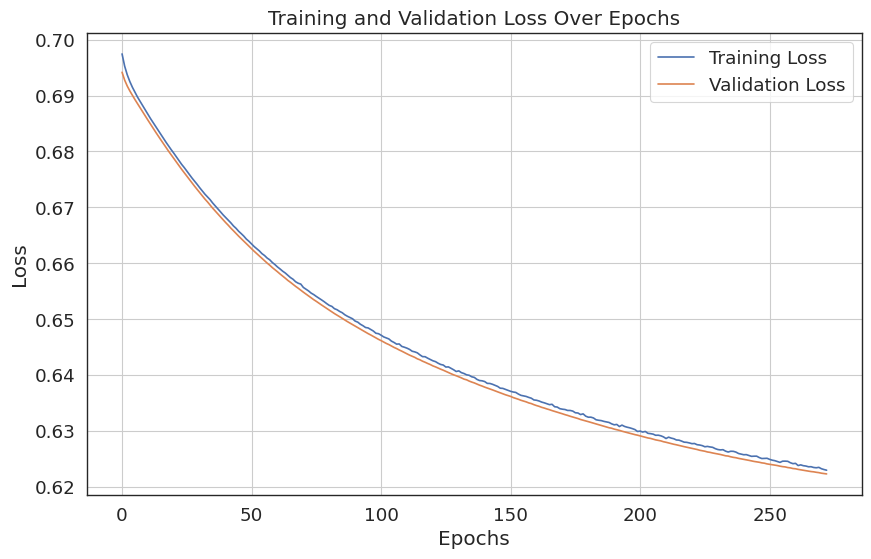

In [67]:
# Ensure that the length of mpnn_train_loss_list and mpnn_val_loss_list is equal to the number of epochs processed
assert len(mpnn_train_loss_list) == len(mpnn_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mpnn_train_loss_list, label='Training Loss')
plt.plot(mpnn_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train on merged train and val sets


In [68]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

## Reset weights before training again with all data


In [69]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)

MPNNClassifier(
  (edge_conv): EdgeConv(
    (theta): Linear(in_features=74, out_features=74, bias=True)
    (phi): Linear(in_features=74, out_features=74, bias=True)
  )
  (fc): Linear(in_features=74, out_features=1, bias=True)
)

In [70]:
print("Final training on merged training and validation sets")

# Initialize list to store loss values
final_train_losses = []

for epoch in range(num_epochs_early):
    # Training
    train_loss = train(model, train_loader_all, criterion, optimizer, device)
    final_train_losses.append(train_loss)  # Store train loss

    # Print train loss
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}")


Final training on merged training and validation sets


Epoch 1/273, Train Loss: 0.6924


Epoch 2/273, Train Loss: 0.6900


Epoch 3/273, Train Loss: 0.6879


Epoch 4/273, Train Loss: 0.6862


Epoch 5/273, Train Loss: 0.6846


Epoch 6/273, Train Loss: 0.6831


Epoch 7/273, Train Loss: 0.6818


Epoch 8/273, Train Loss: 0.6805


Epoch 9/273, Train Loss: 0.6793


Epoch 10/273, Train Loss: 0.6782


Epoch 11/273, Train Loss: 0.6772


Epoch 12/273, Train Loss: 0.6762


Epoch 13/273, Train Loss: 0.6752


Epoch 14/273, Train Loss: 0.6743


Epoch 15/273, Train Loss: 0.6734


Epoch 16/273, Train Loss: 0.6725


Epoch 17/273, Train Loss: 0.6717


Epoch 18/273, Train Loss: 0.6709


Epoch 19/273, Train Loss: 0.6702


Epoch 20/273, Train Loss: 0.6694


Epoch 21/273, Train Loss: 0.6687


Epoch 22/273, Train Loss: 0.6680


Epoch 23/273, Train Loss: 0.6673


Epoch 24/273, Train Loss: 0.6667


Epoch 25/273, Train Loss: 0.6660


Epoch 26/273, Train Loss: 0.6654


Epoch 27/273, Train Loss: 0.6648


Epoch 28/273, Train Loss: 0.6642


Epoch 29/273, Train Loss: 0.6636


Epoch 30/273, Train Loss: 0.6630


Epoch 31/273, Train Loss: 0.6625


Epoch 32/273, Train Loss: 0.6619


Epoch 33/273, Train Loss: 0.6614


Epoch 34/273, Train Loss: 0.6608


Epoch 35/273, Train Loss: 0.6603


Epoch 36/273, Train Loss: 0.6598


Epoch 37/273, Train Loss: 0.6593


Epoch 38/273, Train Loss: 0.6588


Epoch 39/273, Train Loss: 0.6584


Epoch 40/273, Train Loss: 0.6579


Epoch 41/273, Train Loss: 0.6574


Epoch 42/273, Train Loss: 0.6570


Epoch 43/273, Train Loss: 0.6566


Epoch 44/273, Train Loss: 0.6561


Epoch 45/273, Train Loss: 0.6557


Epoch 46/273, Train Loss: 0.6553


Epoch 47/273, Train Loss: 0.6549


Epoch 48/273, Train Loss: 0.6545


Epoch 49/273, Train Loss: 0.6541


Epoch 50/273, Train Loss: 0.6537


Epoch 51/273, Train Loss: 0.6533


Epoch 52/273, Train Loss: 0.6529


Epoch 53/273, Train Loss: 0.6525


Epoch 54/273, Train Loss: 0.6522


Epoch 55/273, Train Loss: 0.6518


Epoch 56/273, Train Loss: 0.6514


Epoch 57/273, Train Loss: 0.6511


Epoch 58/273, Train Loss: 0.6507


Epoch 59/273, Train Loss: 0.6504


Epoch 60/273, Train Loss: 0.6500


Epoch 61/273, Train Loss: 0.6497


Epoch 62/273, Train Loss: 0.6494


Epoch 63/273, Train Loss: 0.6490


Epoch 64/273, Train Loss: 0.6487


Epoch 65/273, Train Loss: 0.6484


Epoch 66/273, Train Loss: 0.6481


Epoch 67/273, Train Loss: 0.6478


Epoch 68/273, Train Loss: 0.6475


Epoch 69/273, Train Loss: 0.6472


Epoch 70/273, Train Loss: 0.6469


Epoch 71/273, Train Loss: 0.6466


Epoch 72/273, Train Loss: 0.6463


Epoch 73/273, Train Loss: 0.6460


Epoch 74/273, Train Loss: 0.6457


Epoch 75/273, Train Loss: 0.6454


Epoch 76/273, Train Loss: 0.6451


Epoch 77/273, Train Loss: 0.6449


Epoch 78/273, Train Loss: 0.6446


Epoch 79/273, Train Loss: 0.6443


Epoch 80/273, Train Loss: 0.6440


Epoch 81/273, Train Loss: 0.6438


Epoch 82/273, Train Loss: 0.6435


Epoch 83/273, Train Loss: 0.6432


Epoch 84/273, Train Loss: 0.6430


Epoch 85/273, Train Loss: 0.6427


Epoch 86/273, Train Loss: 0.6425


Epoch 87/273, Train Loss: 0.6422


Epoch 88/273, Train Loss: 0.6420


Epoch 89/273, Train Loss: 0.6417


Epoch 90/273, Train Loss: 0.6415


Epoch 91/273, Train Loss: 0.6412


Epoch 92/273, Train Loss: 0.6410


Epoch 93/273, Train Loss: 0.6407


Epoch 94/273, Train Loss: 0.6405


Epoch 95/273, Train Loss: 0.6403


Epoch 96/273, Train Loss: 0.6400


Epoch 97/273, Train Loss: 0.6398


Epoch 98/273, Train Loss: 0.6396


Epoch 99/273, Train Loss: 0.6393


Epoch 100/273, Train Loss: 0.6391


Epoch 101/273, Train Loss: 0.6389


Epoch 102/273, Train Loss: 0.6387


Epoch 103/273, Train Loss: 0.6384


Epoch 104/273, Train Loss: 0.6382


Epoch 105/273, Train Loss: 0.6380


Epoch 106/273, Train Loss: 0.6378


Epoch 107/273, Train Loss: 0.6376


Epoch 108/273, Train Loss: 0.6374


Epoch 109/273, Train Loss: 0.6372


Epoch 110/273, Train Loss: 0.6370


Epoch 111/273, Train Loss: 0.6367


Epoch 112/273, Train Loss: 0.6365


Epoch 113/273, Train Loss: 0.6363


Epoch 114/273, Train Loss: 0.6361


Epoch 115/273, Train Loss: 0.6359


Epoch 116/273, Train Loss: 0.6357


Epoch 117/273, Train Loss: 0.6355


Epoch 118/273, Train Loss: 0.6353


Epoch 119/273, Train Loss: 0.6352


Epoch 120/273, Train Loss: 0.6350


Epoch 121/273, Train Loss: 0.6348


Epoch 122/273, Train Loss: 0.6346


Epoch 123/273, Train Loss: 0.6344


Epoch 124/273, Train Loss: 0.6342


Epoch 125/273, Train Loss: 0.6340


Epoch 126/273, Train Loss: 0.6338


Epoch 127/273, Train Loss: 0.6337


Epoch 128/273, Train Loss: 0.6335


Epoch 129/273, Train Loss: 0.6333


Epoch 130/273, Train Loss: 0.6331


Epoch 131/273, Train Loss: 0.6329


Epoch 132/273, Train Loss: 0.6328


Epoch 133/273, Train Loss: 0.6326


Epoch 134/273, Train Loss: 0.6324


Epoch 135/273, Train Loss: 0.6323


Epoch 136/273, Train Loss: 0.6321


Epoch 137/273, Train Loss: 0.6319


Epoch 138/273, Train Loss: 0.6318


Epoch 139/273, Train Loss: 0.6316


Epoch 140/273, Train Loss: 0.6314


Epoch 141/273, Train Loss: 0.6313


Epoch 142/273, Train Loss: 0.6311


Epoch 143/273, Train Loss: 0.6309


Epoch 144/273, Train Loss: 0.6308


Epoch 145/273, Train Loss: 0.6306


Epoch 146/273, Train Loss: 0.6305


Epoch 147/273, Train Loss: 0.6303


Epoch 148/273, Train Loss: 0.6302


Epoch 149/273, Train Loss: 0.6300


Epoch 150/273, Train Loss: 0.6299


Epoch 151/273, Train Loss: 0.6297


Epoch 152/273, Train Loss: 0.6296


Epoch 153/273, Train Loss: 0.6294


Epoch 154/273, Train Loss: 0.6293


Epoch 155/273, Train Loss: 0.6291


Epoch 156/273, Train Loss: 0.6290


Epoch 157/273, Train Loss: 0.6288


Epoch 158/273, Train Loss: 0.6287


Epoch 159/273, Train Loss: 0.6286


Epoch 160/273, Train Loss: 0.6284


Epoch 161/273, Train Loss: 0.6283


Epoch 162/273, Train Loss: 0.6281


Epoch 163/273, Train Loss: 0.6280


Epoch 164/273, Train Loss: 0.6279


Epoch 165/273, Train Loss: 0.6277


Epoch 166/273, Train Loss: 0.6276


Epoch 167/273, Train Loss: 0.6275


Epoch 168/273, Train Loss: 0.6273


Epoch 169/273, Train Loss: 0.6272


Epoch 170/273, Train Loss: 0.6271


Epoch 171/273, Train Loss: 0.6270


Epoch 172/273, Train Loss: 0.6268


Epoch 173/273, Train Loss: 0.6267


Epoch 174/273, Train Loss: 0.6266


Epoch 175/273, Train Loss: 0.6265


Epoch 176/273, Train Loss: 0.6263


Epoch 177/273, Train Loss: 0.6262


Epoch 178/273, Train Loss: 0.6261


Epoch 179/273, Train Loss: 0.6260


Epoch 180/273, Train Loss: 0.6259


Epoch 181/273, Train Loss: 0.6257


Epoch 182/273, Train Loss: 0.6256


Epoch 183/273, Train Loss: 0.6255


Epoch 184/273, Train Loss: 0.6254


Epoch 185/273, Train Loss: 0.6253


Epoch 186/273, Train Loss: 0.6252


Epoch 187/273, Train Loss: 0.6250


Epoch 188/273, Train Loss: 0.6249


Epoch 189/273, Train Loss: 0.6248


Epoch 190/273, Train Loss: 0.6247


Epoch 191/273, Train Loss: 0.6246


Epoch 192/273, Train Loss: 0.6245


Epoch 193/273, Train Loss: 0.6244


Epoch 194/273, Train Loss: 0.6243


Epoch 195/273, Train Loss: 0.6242


Epoch 196/273, Train Loss: 0.6241


Epoch 197/273, Train Loss: 0.6240


Epoch 198/273, Train Loss: 0.6239


Epoch 199/273, Train Loss: 0.6238


Epoch 200/273, Train Loss: 0.6237


Epoch 201/273, Train Loss: 0.6236


Epoch 202/273, Train Loss: 0.6235


Epoch 203/273, Train Loss: 0.6234


Epoch 204/273, Train Loss: 0.6233


Epoch 205/273, Train Loss: 0.6232


Epoch 206/273, Train Loss: 0.6231


Epoch 207/273, Train Loss: 0.6230


Epoch 208/273, Train Loss: 0.6229


Epoch 209/273, Train Loss: 0.6228


Epoch 210/273, Train Loss: 0.6227


Epoch 211/273, Train Loss: 0.6226


Epoch 212/273, Train Loss: 0.6225


Epoch 213/273, Train Loss: 0.6224


Epoch 214/273, Train Loss: 0.6223


Epoch 215/273, Train Loss: 0.6222


Epoch 216/273, Train Loss: 0.6222


Epoch 217/273, Train Loss: 0.6221


Epoch 218/273, Train Loss: 0.6220


Epoch 219/273, Train Loss: 0.6219


Epoch 220/273, Train Loss: 0.6218


Epoch 221/273, Train Loss: 0.6217


Epoch 222/273, Train Loss: 0.6216


Epoch 223/273, Train Loss: 0.6216


Epoch 224/273, Train Loss: 0.6215


Epoch 225/273, Train Loss: 0.6214


Epoch 226/273, Train Loss: 0.6213


Epoch 227/273, Train Loss: 0.6212


Epoch 228/273, Train Loss: 0.6211


Epoch 229/273, Train Loss: 0.6211


Epoch 230/273, Train Loss: 0.6210


Epoch 231/273, Train Loss: 0.6209


Epoch 232/273, Train Loss: 0.6208


Epoch 233/273, Train Loss: 0.6207


Epoch 234/273, Train Loss: 0.6207


Epoch 235/273, Train Loss: 0.6206


Epoch 236/273, Train Loss: 0.6205


Epoch 237/273, Train Loss: 0.6204


Epoch 238/273, Train Loss: 0.6204


Epoch 239/273, Train Loss: 0.6203


Epoch 240/273, Train Loss: 0.6202


Epoch 241/273, Train Loss: 0.6201


Epoch 242/273, Train Loss: 0.6201


Epoch 243/273, Train Loss: 0.6200


Epoch 244/273, Train Loss: 0.6199


Epoch 245/273, Train Loss: 0.6199


Epoch 246/273, Train Loss: 0.6198


Epoch 247/273, Train Loss: 0.6197


Epoch 248/273, Train Loss: 0.6197


Epoch 249/273, Train Loss: 0.6196


Epoch 250/273, Train Loss: 0.6195


Epoch 251/273, Train Loss: 0.6194


Epoch 252/273, Train Loss: 0.6194


Epoch 253/273, Train Loss: 0.6193


Epoch 254/273, Train Loss: 0.6192


Epoch 255/273, Train Loss: 0.6192


Epoch 256/273, Train Loss: 0.6191


Epoch 257/273, Train Loss: 0.6191


Epoch 258/273, Train Loss: 0.6190


Epoch 259/273, Train Loss: 0.6189


Epoch 260/273, Train Loss: 0.6189


Epoch 261/273, Train Loss: 0.6188


Epoch 262/273, Train Loss: 0.6187


Epoch 263/273, Train Loss: 0.6187


Epoch 264/273, Train Loss: 0.6186


Epoch 265/273, Train Loss: 0.6186


Epoch 266/273, Train Loss: 0.6185


Epoch 267/273, Train Loss: 0.6184


Epoch 268/273, Train Loss: 0.6184


Epoch 269/273, Train Loss: 0.6183


Epoch 270/273, Train Loss: 0.6183


Epoch 271/273, Train Loss: 0.6182


Epoch 272/273, Train Loss: 0.6181


Epoch 273/273, Train Loss: 0.6181


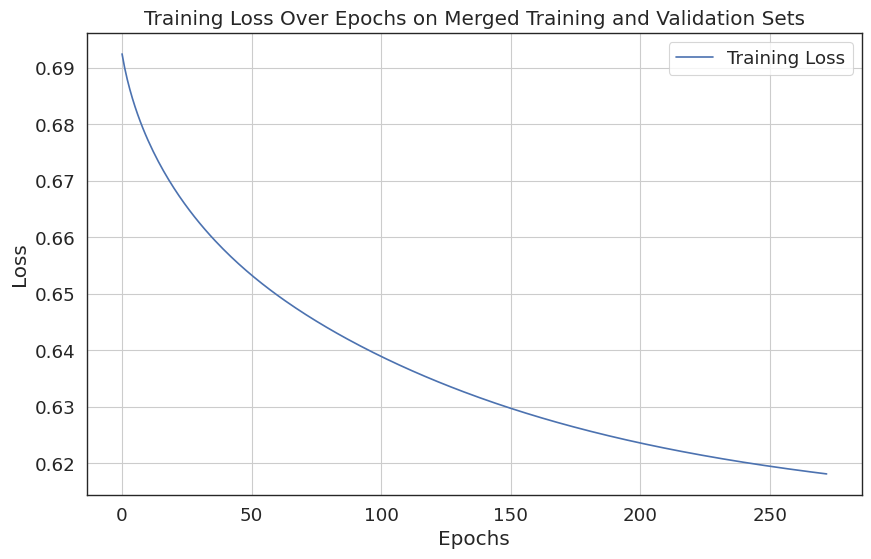

In [71]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [72]:
# if there is not a folder named 'model' create one
if not os.path.exists('model_experiment'):
    os.mkdir('model_experiment')

# save the model
torch.save(model.state_dict(), 'model_experiment/mpnn_model_experiment.pth')

In [73]:
# Define the number of output features for binary classification
out_feats = 1

# Instantiate the model
hidden_size = 74 
model = MPNNClassifier(in_feats, hidden_size, out_feats).to(device)

# Load the model state
model.load_state_dict(torch.load('model_experiment/mpnn_model_experiment.pth'))


<All keys matched successfully>

## Test the model

## Predict probabilities

In [74]:
y_true, y_pred, y_pred_proba = test(model, test_loader, device)

confidence_percentages = [prob * 100 for prob in y_pred_proba]

y_pred_proba = np.array(y_pred_proba)

## Results

In [75]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')

Accuracy: 0.6738862234407128
Precision: 0.6573865061449712
Recall: 0.7212438084755091
F1: 0.6878362419629971
AUC: 0.7250910322657556


In [76]:
# Accuracy: 0.6711336717428088
# Precision: 0.6515337423312884
# Recall: 0.7245190339746214
# F1: 0.6860908327411331
# AUC: 0.7276068962734443

## Confusion matrix

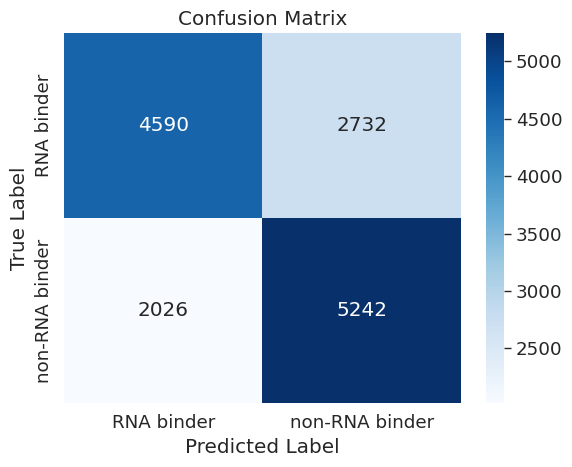

In [77]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_mpnn_experiment.png', dpi=300)
plt.show()



## Classification report

In [78]:
# classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.69      0.63      0.66      7322
         1.0       0.66      0.72      0.69      7268

    accuracy                           0.67     14590
   macro avg       0.68      0.67      0.67     14590
weighted avg       0.68      0.67      0.67     14590



## ROC AUC

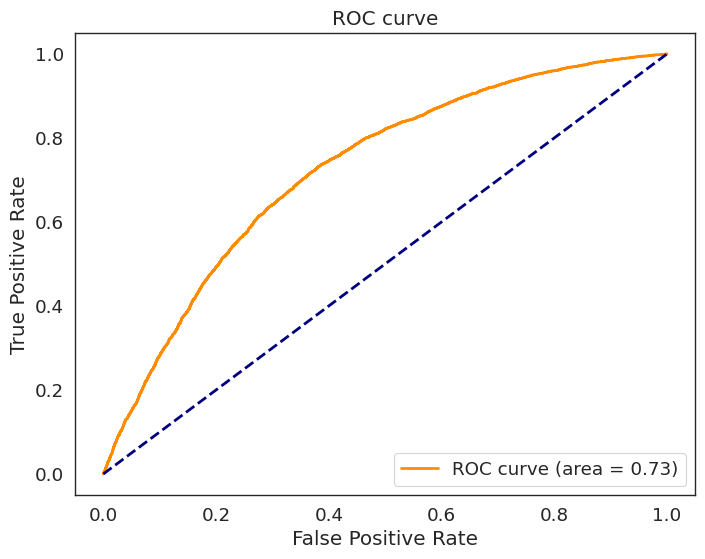

In [79]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_mpnn_experiment.png', dpi=300)
plt.show()


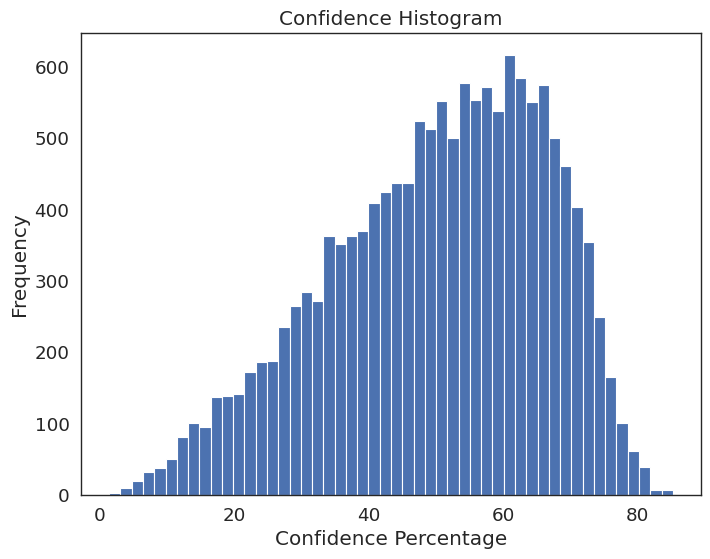

In [80]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_mpnn_experiment.png', dpi=300)
plt.show()


In [81]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [82]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_mpnn_experiment'):
    os.mkdir('top_molecules_mpnn_experiment')
    

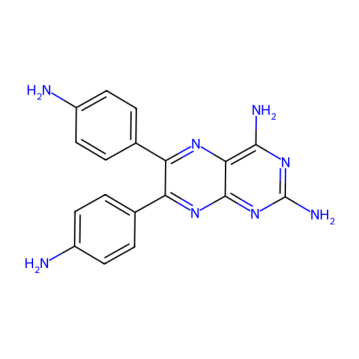

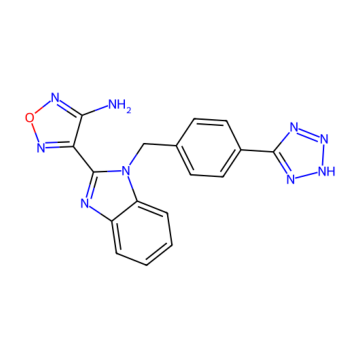

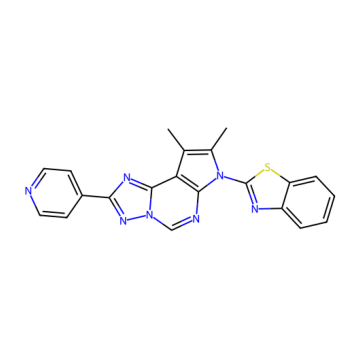

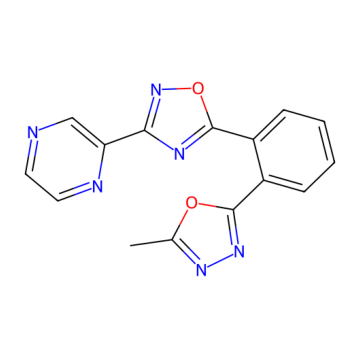

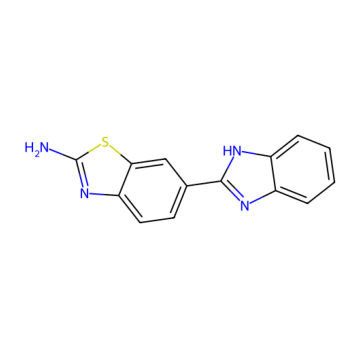

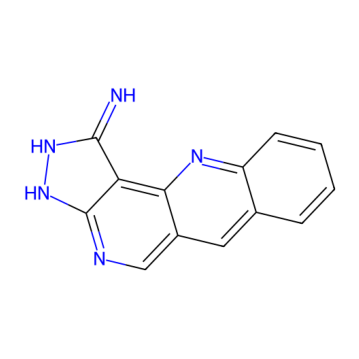

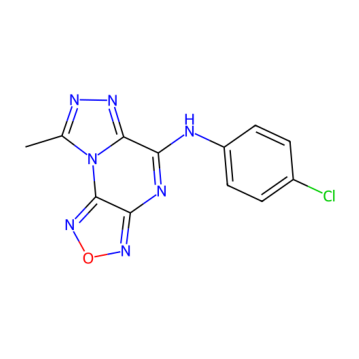

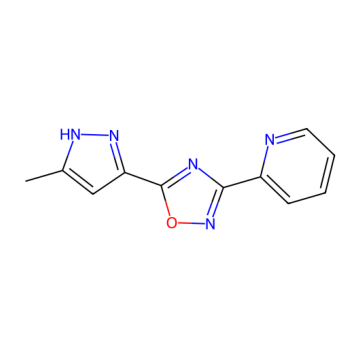

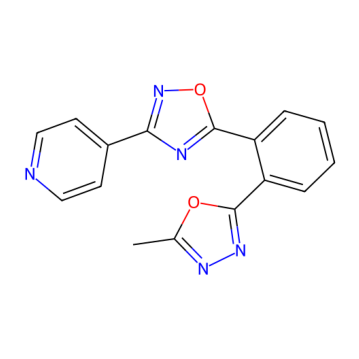

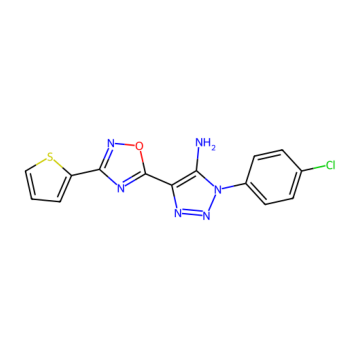

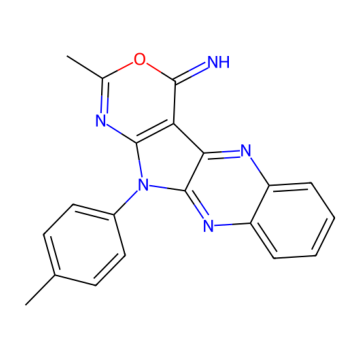

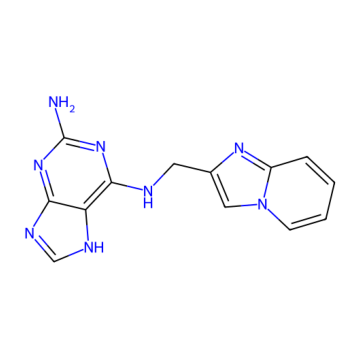

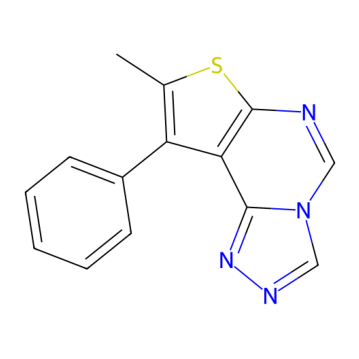

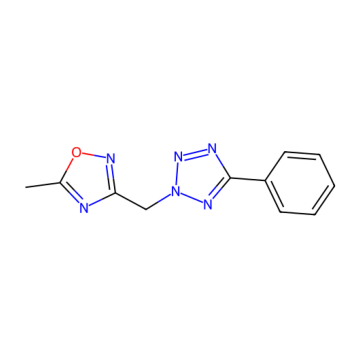

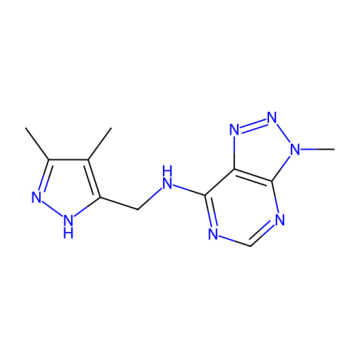

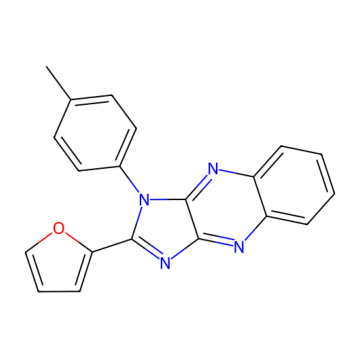

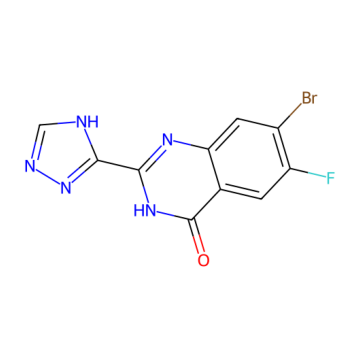

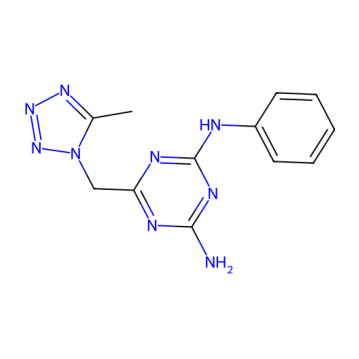

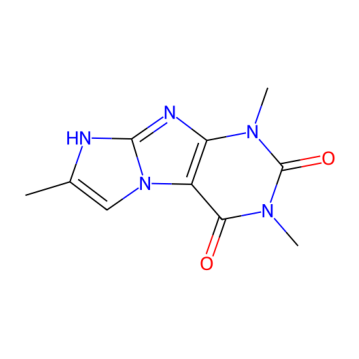

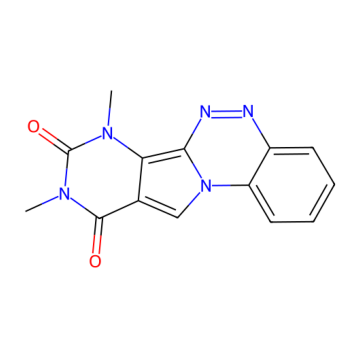

In [83]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_mpnn_experiment/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


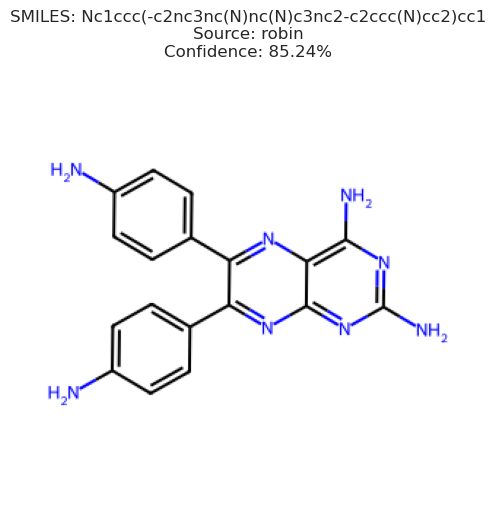

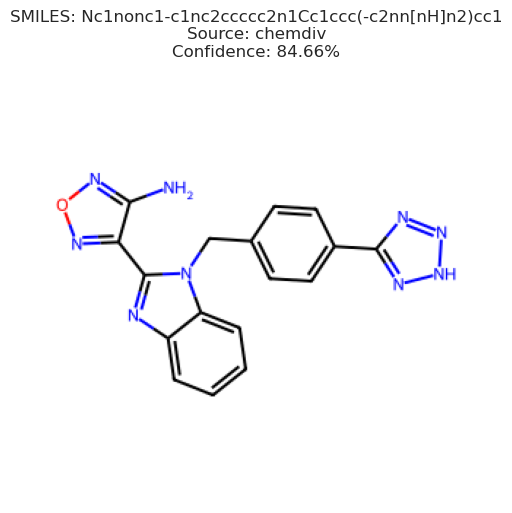

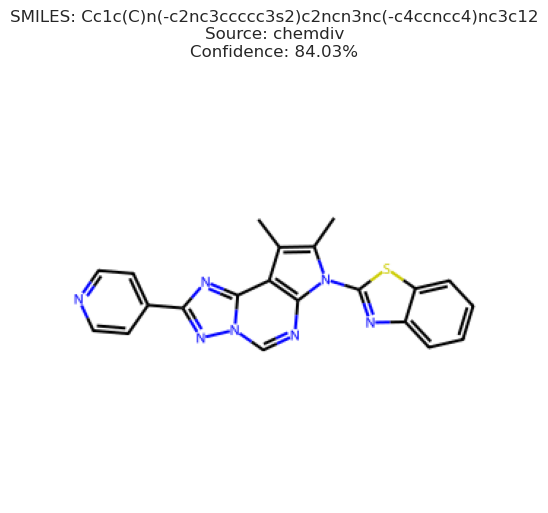

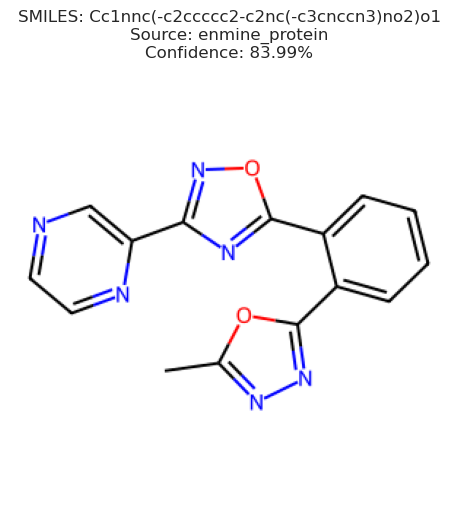

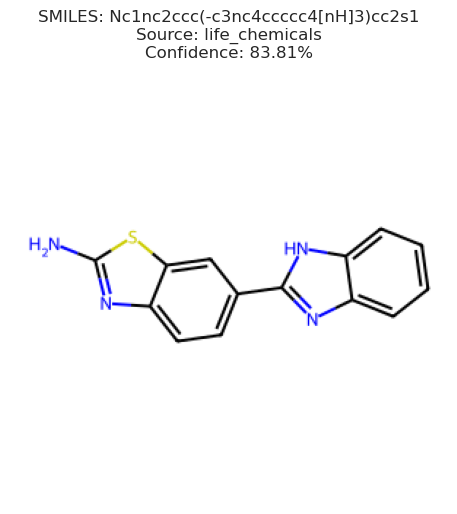

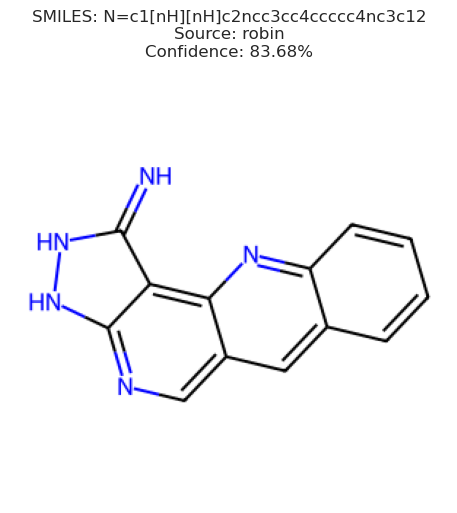

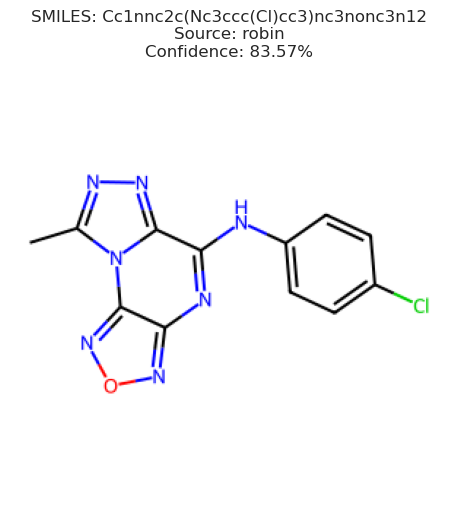

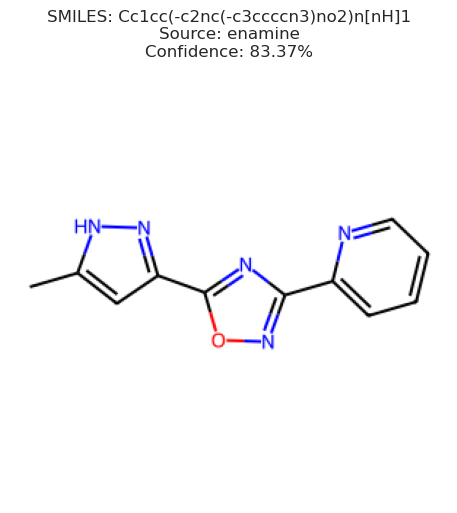

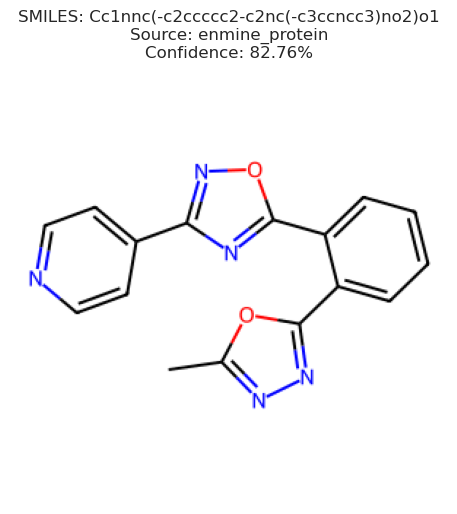

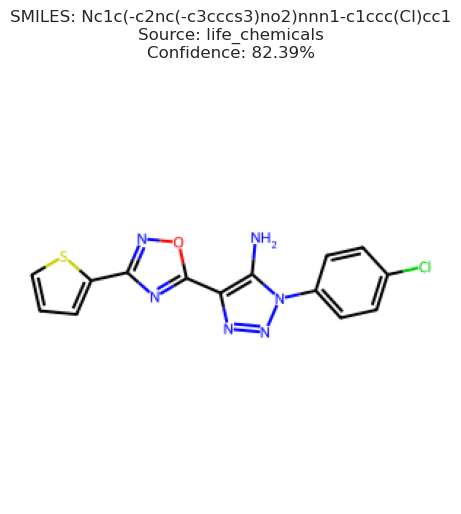

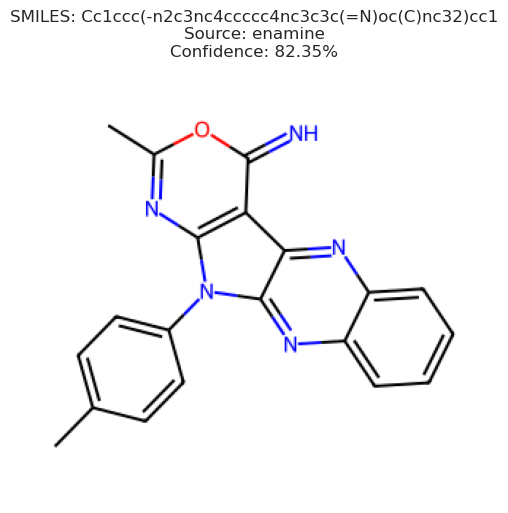

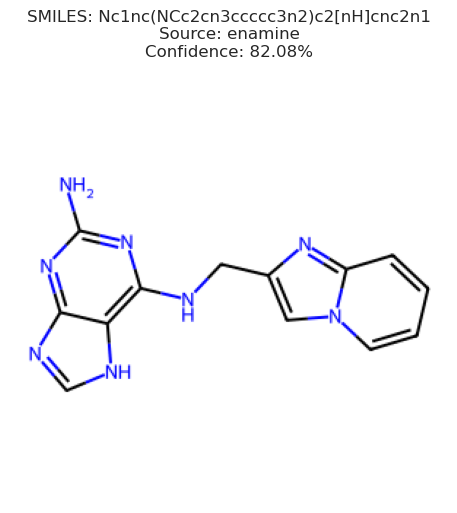

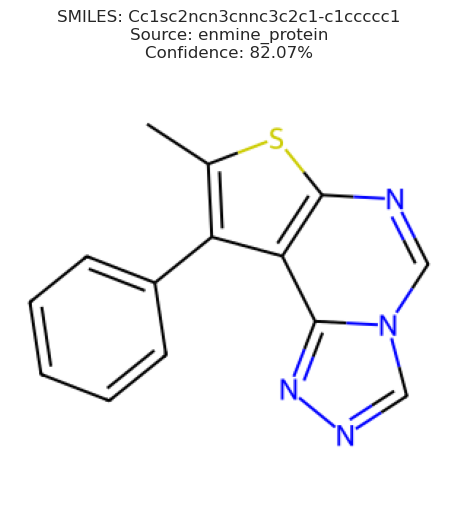

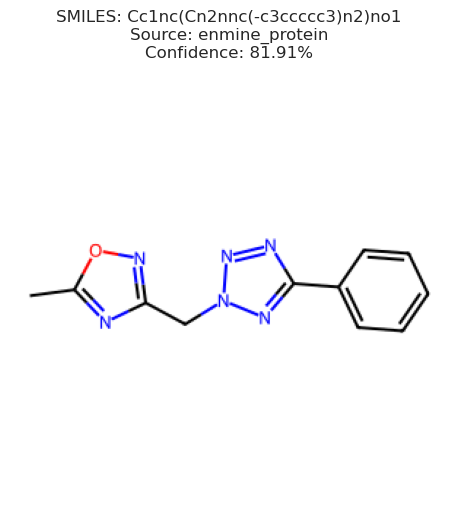

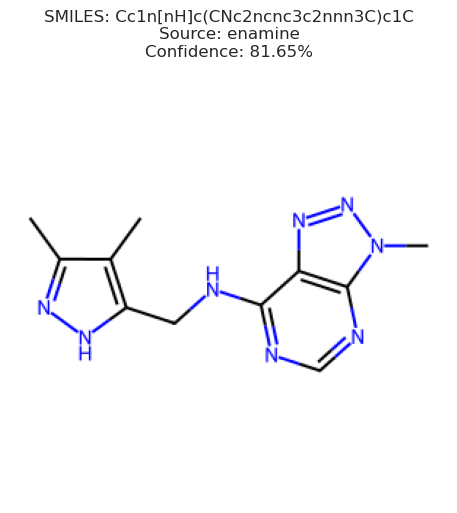

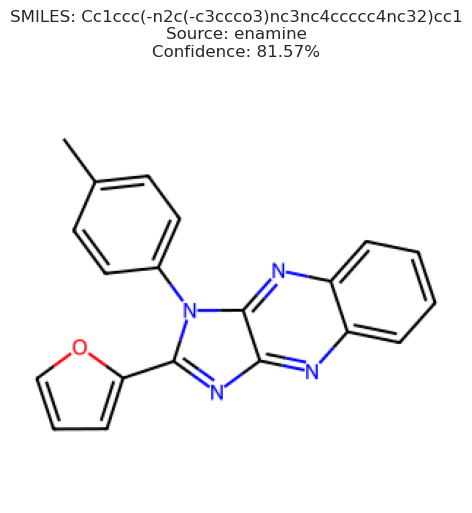

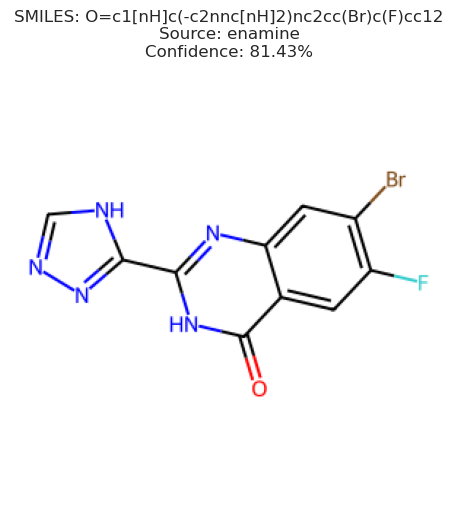

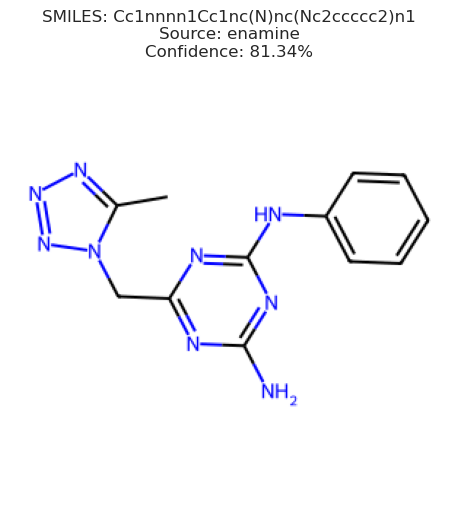

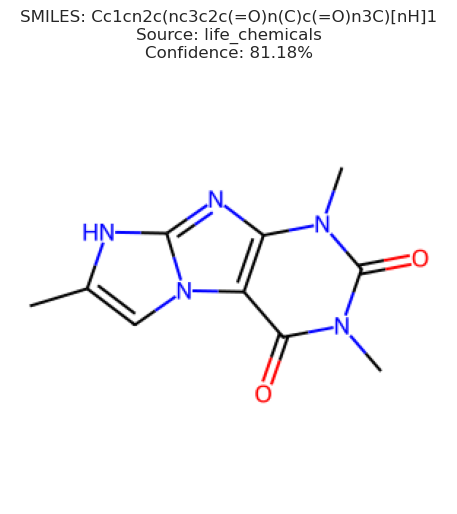

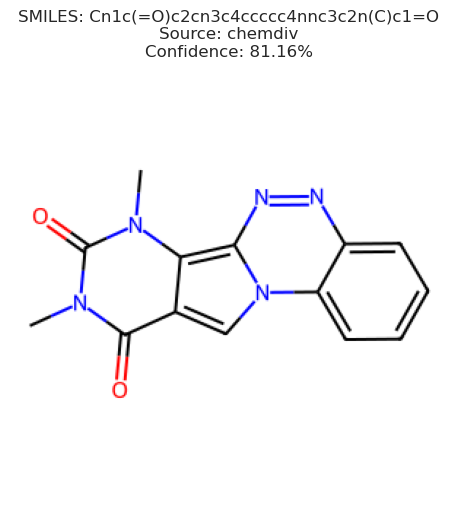

In [84]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_mpnn_experiment/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    # plt.show()


# Graph Attention Networks (GAT)

In [85]:
class GATClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size, num_heads=1):
        super(GATClassifier, self).__init__()
        self.conv1 = dglnn.GATConv(in_feats, hidden_size, num_heads=num_heads)

        # Adjusted to account for the mean aggregation of head outputs
        self.fc = nn.Linear(hidden_size, 1)  # For binary classification

    def forward(self, g, features):
        # Apply GAT convolution
        gat_output = self.conv1(g, features)  # Shape: [num_nodes, num_heads, hidden_size]

        # Mean over heads
        x = F.elu(gat_output.mean(1))  # Now shape: [num_nodes, hidden_size]
        
        # Update node features
        g.ndata['h'] = x

        # Aggregate node features across the graph
        x = dgl.mean_nodes(g, 'h')

        # Pass through the fully connected layer
        return self.fc(x)


## Instance of the the GAT Model

In [86]:
# Instantiate the model
in_feats = train_graphs[0].ndata['h'].shape[1]  # Replace with your feature size
model = GATClassifier(in_feats, hidden_size=148, num_heads=4).to(device)  # hidden_size is set to 74

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()  # Use this loss if you are using a sigmoid activation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Train the GAT model

In [87]:
num_epochs = 500
early_stopping = EarlyStopping(patience=25, min_delta=0.002)

# Initialize lists to store loss values
gat_train_loss_list = []
gat_val_loss_list = []

for epoch in range(num_epochs):
    # Training
    train_loss = train(model, train_loader, criterion, optimizer, device)
    gat_train_loss_list.append(train_loss)  # Store train loss

    # Validation
    val_loss, _, _, _ = validate(model, val_loader, criterion, device)
    gat_val_loss_list.append(val_loss)  # Store validation loss

    # Print and check for early stopping
    print(f"Epoch: {epoch+1}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
    early_stopping(val_loss, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break
    
# Store the epoch number when early stopping was triggered
num_epochs_early = early_stopping.stopped_epoch + 1



Epoch: 1, train_loss: 0.6912, val_loss: 0.6891


Epoch: 2, train_loss: 0.6876, val_loss: 0.6856


Epoch: 3, train_loss: 0.6840, val_loss: 0.6818


Epoch: 4, train_loss: 0.6801, val_loss: 0.6778


Epoch: 5, train_loss: 0.6760, val_loss: 0.6734


Epoch: 6, train_loss: 0.6715, val_loss: 0.6687


Epoch: 7, train_loss: 0.6668, val_loss: 0.6640


Epoch: 8, train_loss: 0.6620, val_loss: 0.6591


Epoch: 9, train_loss: 0.6571, val_loss: 0.6544


Epoch: 10, train_loss: 0.6522, val_loss: 0.6493


Epoch: 11, train_loss: 0.6475, val_loss: 0.6449


Epoch: 12, train_loss: 0.6427, val_loss: 0.6399


Epoch: 13, train_loss: 0.6384, val_loss: 0.6358


Epoch: 14, train_loss: 0.6340, val_loss: 0.6318


Epoch: 15, train_loss: 0.6304, val_loss: 0.6283


Epoch: 16, train_loss: 0.6269, val_loss: 0.6253


Epoch: 17, train_loss: 0.6240, val_loss: 0.6223


Epoch: 18, train_loss: 0.6213, val_loss: 0.6204


Epoch: 19, train_loss: 0.6191, val_loss: 0.6180


Epoch: 20, train_loss: 0.6169, val_loss: 0.6161


Epoch: 21, train_loss: 0.6152, val_loss: 0.6146


Epoch: 22, train_loss: 0.6136, val_loss: 0.6133


Epoch: 23, train_loss: 0.6123, val_loss: 0.6120


Epoch: 24, train_loss: 0.6111, val_loss: 0.6114


Epoch: 25, train_loss: 0.6104, val_loss: 0.6099


Epoch: 26, train_loss: 0.6094, val_loss: 0.6092


Epoch: 27, train_loss: 0.6085, val_loss: 0.6083


Epoch: 28, train_loss: 0.6074, val_loss: 0.6082


Epoch: 29, train_loss: 0.6070, val_loss: 0.6069


Epoch: 30, train_loss: 0.6062, val_loss: 0.6063


Epoch: 31, train_loss: 0.6057, val_loss: 0.6059


Epoch: 32, train_loss: 0.6048, val_loss: 0.6053


Epoch: 33, train_loss: 0.6043, val_loss: 0.6046


Epoch: 34, train_loss: 0.6040, val_loss: 0.6041


Epoch: 35, train_loss: 0.6035, val_loss: 0.6036


Epoch: 36, train_loss: 0.6030, val_loss: 0.6033


Epoch: 37, train_loss: 0.6025, val_loss: 0.6028


Epoch: 38, train_loss: 0.6021, val_loss: 0.6024


Epoch: 39, train_loss: 0.6020, val_loss: 0.6020


Epoch: 40, train_loss: 0.6015, val_loss: 0.6017


Epoch: 41, train_loss: 0.6014, val_loss: 0.6014


Epoch: 42, train_loss: 0.6009, val_loss: 0.6011


Epoch: 43, train_loss: 0.6003, val_loss: 0.6006


Epoch: 44, train_loss: 0.6001, val_loss: 0.6004


Epoch: 45, train_loss: 0.5999, val_loss: 0.6000


Epoch: 46, train_loss: 0.5996, val_loss: 0.5999


Epoch: 47, train_loss: 0.5992, val_loss: 0.5995


Epoch: 48, train_loss: 0.5993, val_loss: 0.5992


Epoch: 49, train_loss: 0.5988, val_loss: 0.5992


Epoch: 50, train_loss: 0.5987, val_loss: 0.5988


Epoch: 51, train_loss: 0.5981, val_loss: 0.5991


Epoch: 52, train_loss: 0.5983, val_loss: 0.5985


Epoch: 53, train_loss: 0.5980, val_loss: 0.5979


Epoch: 54, train_loss: 0.5976, val_loss: 0.5980


Epoch: 55, train_loss: 0.5973, val_loss: 0.5975


Epoch: 56, train_loss: 0.5973, val_loss: 0.5977


Epoch: 57, train_loss: 0.5970, val_loss: 0.5970


Epoch: 58, train_loss: 0.5967, val_loss: 0.5970


Epoch: 59, train_loss: 0.5963, val_loss: 0.5966


Epoch: 60, train_loss: 0.5961, val_loss: 0.5964


Epoch: 61, train_loss: 0.5961, val_loss: 0.5961


Epoch: 62, train_loss: 0.5959, val_loss: 0.5962


Epoch: 63, train_loss: 0.5957, val_loss: 0.5956


Epoch: 64, train_loss: 0.5952, val_loss: 0.5956


Epoch: 65, train_loss: 0.5953, val_loss: 0.5952


Epoch: 66, train_loss: 0.5952, val_loss: 0.5952


Epoch: 67, train_loss: 0.5948, val_loss: 0.5952


Epoch: 68, train_loss: 0.5946, val_loss: 0.5948


Epoch: 69, train_loss: 0.5942, val_loss: 0.5947


Epoch: 70, train_loss: 0.5941, val_loss: 0.5941


Epoch: 71, train_loss: 0.5942, val_loss: 0.5943


Epoch: 72, train_loss: 0.5937, val_loss: 0.5937


Epoch: 73, train_loss: 0.5935, val_loss: 0.5937


Epoch: 74, train_loss: 0.5934, val_loss: 0.5936


Epoch: 75, train_loss: 0.5931, val_loss: 0.5931


Epoch: 76, train_loss: 0.5928, val_loss: 0.5928


Epoch: 77, train_loss: 0.5926, val_loss: 0.5926


Epoch: 78, train_loss: 0.5925, val_loss: 0.5924


Epoch: 79, train_loss: 0.5921, val_loss: 0.5922


Epoch: 80, train_loss: 0.5918, val_loss: 0.5919


Epoch: 81, train_loss: 0.5917, val_loss: 0.5918


Epoch: 82, train_loss: 0.5920, val_loss: 0.5914


Epoch: 83, train_loss: 0.5914, val_loss: 0.5912


Epoch: 84, train_loss: 0.5914, val_loss: 0.5909


Epoch: 85, train_loss: 0.5908, val_loss: 0.5911


Epoch: 86, train_loss: 0.5908, val_loss: 0.5909


Epoch: 87, train_loss: 0.5905, val_loss: 0.5903


Epoch: 88, train_loss: 0.5904, val_loss: 0.5903


Epoch: 89, train_loss: 0.5901, val_loss: 0.5899


Epoch: 90, train_loss: 0.5899, val_loss: 0.5897


Epoch: 91, train_loss: 0.5897, val_loss: 0.5894


Epoch: 92, train_loss: 0.5893, val_loss: 0.5891


Epoch: 93, train_loss: 0.5892, val_loss: 0.5893


Epoch: 94, train_loss: 0.5889, val_loss: 0.5887


Epoch: 95, train_loss: 0.5887, val_loss: 0.5884


Epoch: 96, train_loss: 0.5886, val_loss: 0.5883


Epoch: 97, train_loss: 0.5883, val_loss: 0.5879


Epoch: 98, train_loss: 0.5878, val_loss: 0.5877


Epoch: 99, train_loss: 0.5880, val_loss: 0.5875


Epoch: 100, train_loss: 0.5874, val_loss: 0.5872


Epoch: 101, train_loss: 0.5872, val_loss: 0.5870


Epoch: 102, train_loss: 0.5871, val_loss: 0.5865


Epoch: 103, train_loss: 0.5866, val_loss: 0.5863


Epoch: 104, train_loss: 0.5861, val_loss: 0.5861


Epoch: 105, train_loss: 0.5859, val_loss: 0.5859


Epoch: 106, train_loss: 0.5859, val_loss: 0.5854


Epoch: 107, train_loss: 0.5856, val_loss: 0.5854


Epoch: 108, train_loss: 0.5852, val_loss: 0.5848


Epoch: 109, train_loss: 0.5847, val_loss: 0.5847


Epoch: 110, train_loss: 0.5847, val_loss: 0.5842


Epoch: 111, train_loss: 0.5841, val_loss: 0.5837


Epoch: 112, train_loss: 0.5839, val_loss: 0.5834


Epoch: 113, train_loss: 0.5836, val_loss: 0.5829


Epoch: 114, train_loss: 0.5833, val_loss: 0.5823


Epoch: 115, train_loss: 0.5825, val_loss: 0.5819


Epoch: 116, train_loss: 0.5819, val_loss: 0.5813


Epoch: 117, train_loss: 0.5817, val_loss: 0.5808


Epoch: 118, train_loss: 0.5812, val_loss: 0.5806


Epoch: 119, train_loss: 0.5808, val_loss: 0.5802


Epoch: 120, train_loss: 0.5807, val_loss: 0.5799


Epoch: 121, train_loss: 0.5801, val_loss: 0.5795


Epoch: 122, train_loss: 0.5801, val_loss: 0.5794


Epoch: 123, train_loss: 0.5798, val_loss: 0.5789


Epoch: 124, train_loss: 0.5795, val_loss: 0.5787


Epoch: 125, train_loss: 0.5790, val_loss: 0.5783


Epoch: 126, train_loss: 0.5791, val_loss: 0.5782


Epoch: 127, train_loss: 0.5786, val_loss: 0.5777


Epoch: 128, train_loss: 0.5780, val_loss: 0.5777


Epoch: 129, train_loss: 0.5778, val_loss: 0.5770


Epoch: 130, train_loss: 0.5775, val_loss: 0.5770


Epoch: 131, train_loss: 0.5777, val_loss: 0.5765


Epoch: 132, train_loss: 0.5771, val_loss: 0.5762


Epoch: 133, train_loss: 0.5764, val_loss: 0.5759


Epoch: 134, train_loss: 0.5768, val_loss: 0.5755


Epoch: 135, train_loss: 0.5763, val_loss: 0.5752


Epoch: 136, train_loss: 0.5759, val_loss: 0.5749


Epoch: 137, train_loss: 0.5757, val_loss: 0.5747


Epoch: 138, train_loss: 0.5753, val_loss: 0.5748


Epoch: 139, train_loss: 0.5752, val_loss: 0.5742


Epoch: 140, train_loss: 0.5749, val_loss: 0.5739


Epoch: 141, train_loss: 0.5745, val_loss: 0.5736


Epoch: 142, train_loss: 0.5744, val_loss: 0.5734


Epoch: 143, train_loss: 0.5738, val_loss: 0.5732


Epoch: 144, train_loss: 0.5735, val_loss: 0.5727


Epoch: 145, train_loss: 0.5732, val_loss: 0.5725


Epoch: 146, train_loss: 0.5730, val_loss: 0.5722


Epoch: 147, train_loss: 0.5726, val_loss: 0.5717


Epoch: 148, train_loss: 0.5724, val_loss: 0.5714


Epoch: 149, train_loss: 0.5721, val_loss: 0.5714


Epoch: 150, train_loss: 0.5718, val_loss: 0.5708


Epoch: 151, train_loss: 0.5719, val_loss: 0.5709


Epoch: 152, train_loss: 0.5714, val_loss: 0.5702


Epoch: 153, train_loss: 0.5713, val_loss: 0.5699


Epoch: 154, train_loss: 0.5704, val_loss: 0.5707


Epoch: 155, train_loss: 0.5708, val_loss: 0.5693


Epoch: 156, train_loss: 0.5703, val_loss: 0.5692


Epoch: 157, train_loss: 0.5696, val_loss: 0.5687


Epoch: 158, train_loss: 0.5696, val_loss: 0.5685


Epoch: 159, train_loss: 0.5694, val_loss: 0.5684


Epoch: 160, train_loss: 0.5691, val_loss: 0.5681


Epoch: 161, train_loss: 0.5686, val_loss: 0.5675


Epoch: 162, train_loss: 0.5685, val_loss: 0.5672


Epoch: 163, train_loss: 0.5684, val_loss: 0.5670


Epoch: 164, train_loss: 0.5677, val_loss: 0.5667


Epoch: 165, train_loss: 0.5676, val_loss: 0.5663


Epoch: 166, train_loss: 0.5672, val_loss: 0.5665


Epoch: 167, train_loss: 0.5670, val_loss: 0.5658


Epoch: 168, train_loss: 0.5663, val_loss: 0.5655


Epoch: 169, train_loss: 0.5666, val_loss: 0.5652


Epoch: 170, train_loss: 0.5660, val_loss: 0.5649


Epoch: 171, train_loss: 0.5661, val_loss: 0.5645


Epoch: 172, train_loss: 0.5657, val_loss: 0.5645


Epoch: 173, train_loss: 0.5651, val_loss: 0.5643


Epoch: 174, train_loss: 0.5647, val_loss: 0.5637


Epoch: 175, train_loss: 0.5643, val_loss: 0.5633


Epoch: 176, train_loss: 0.5644, val_loss: 0.5631


Epoch: 177, train_loss: 0.5640, val_loss: 0.5627


Epoch: 178, train_loss: 0.5634, val_loss: 0.5626


Epoch: 179, train_loss: 0.5630, val_loss: 0.5620


Epoch: 180, train_loss: 0.5633, val_loss: 0.5618


Epoch: 181, train_loss: 0.5628, val_loss: 0.5617


Epoch: 182, train_loss: 0.5625, val_loss: 0.5612


Epoch: 183, train_loss: 0.5618, val_loss: 0.5608


Epoch: 184, train_loss: 0.5618, val_loss: 0.5606


Epoch: 185, train_loss: 0.5613, val_loss: 0.5603


Epoch: 186, train_loss: 0.5613, val_loss: 0.5603


Epoch: 187, train_loss: 0.5610, val_loss: 0.5595


Epoch: 188, train_loss: 0.5601, val_loss: 0.5595


Epoch: 189, train_loss: 0.5601, val_loss: 0.5587


Epoch: 190, train_loss: 0.5601, val_loss: 0.5594


Epoch: 191, train_loss: 0.5594, val_loss: 0.5584


Epoch: 192, train_loss: 0.5590, val_loss: 0.5578


Epoch: 193, train_loss: 0.5589, val_loss: 0.5574


Epoch: 194, train_loss: 0.5587, val_loss: 0.5572


Epoch: 195, train_loss: 0.5582, val_loss: 0.5570


Epoch: 196, train_loss: 0.5577, val_loss: 0.5567


Epoch: 197, train_loss: 0.5572, val_loss: 0.5562


Epoch: 198, train_loss: 0.5578, val_loss: 0.5559


Epoch: 199, train_loss: 0.5570, val_loss: 0.5556


Epoch: 200, train_loss: 0.5568, val_loss: 0.5554


Epoch: 201, train_loss: 0.5562, val_loss: 0.5553


Epoch: 202, train_loss: 0.5561, val_loss: 0.5548


Epoch: 203, train_loss: 0.5561, val_loss: 0.5546


Epoch: 204, train_loss: 0.5553, val_loss: 0.5542


Epoch: 205, train_loss: 0.5549, val_loss: 0.5539


Epoch: 206, train_loss: 0.5550, val_loss: 0.5536


Epoch: 207, train_loss: 0.5546, val_loss: 0.5533


Epoch: 208, train_loss: 0.5542, val_loss: 0.5533


Epoch: 209, train_loss: 0.5540, val_loss: 0.5528


Epoch: 210, train_loss: 0.5540, val_loss: 0.5525


Epoch: 211, train_loss: 0.5535, val_loss: 0.5522


Epoch: 212, train_loss: 0.5533, val_loss: 0.5519


Epoch: 213, train_loss: 0.5530, val_loss: 0.5516


Epoch: 214, train_loss: 0.5528, val_loss: 0.5514


Epoch: 215, train_loss: 0.5524, val_loss: 0.5511


Epoch: 216, train_loss: 0.5521, val_loss: 0.5509


Epoch: 217, train_loss: 0.5519, val_loss: 0.5507


Epoch: 218, train_loss: 0.5516, val_loss: 0.5506


Epoch: 219, train_loss: 0.5514, val_loss: 0.5502


Epoch: 220, train_loss: 0.5510, val_loss: 0.5500


Epoch: 221, train_loss: 0.5509, val_loss: 0.5501


Epoch: 222, train_loss: 0.5507, val_loss: 0.5495


Epoch: 223, train_loss: 0.5502, val_loss: 0.5492


Epoch: 224, train_loss: 0.5498, val_loss: 0.5492


Epoch: 225, train_loss: 0.5496, val_loss: 0.5486


Epoch: 226, train_loss: 0.5494, val_loss: 0.5485


Epoch: 227, train_loss: 0.5491, val_loss: 0.5481


Epoch: 228, train_loss: 0.5487, val_loss: 0.5480


Epoch: 229, train_loss: 0.5482, val_loss: 0.5476


Epoch: 230, train_loss: 0.5486, val_loss: 0.5474


Epoch: 231, train_loss: 0.5481, val_loss: 0.5474


Epoch: 232, train_loss: 0.5478, val_loss: 0.5469


Epoch: 233, train_loss: 0.5475, val_loss: 0.5466


Epoch: 234, train_loss: 0.5471, val_loss: 0.5464


Epoch: 235, train_loss: 0.5472, val_loss: 0.5462


Epoch: 236, train_loss: 0.5467, val_loss: 0.5459


Epoch: 237, train_loss: 0.5468, val_loss: 0.5459


Epoch: 238, train_loss: 0.5466, val_loss: 0.5455


Epoch: 239, train_loss: 0.5459, val_loss: 0.5452


Epoch: 240, train_loss: 0.5459, val_loss: 0.5453


Epoch: 241, train_loss: 0.5456, val_loss: 0.5448


Epoch: 242, train_loss: 0.5449, val_loss: 0.5447


Epoch: 243, train_loss: 0.5448, val_loss: 0.5448


Epoch: 244, train_loss: 0.5450, val_loss: 0.5442


Epoch: 245, train_loss: 0.5449, val_loss: 0.5445


Epoch: 246, train_loss: 0.5446, val_loss: 0.5444


Epoch: 247, train_loss: 0.5442, val_loss: 0.5434


Epoch: 248, train_loss: 0.5440, val_loss: 0.5437


Epoch: 249, train_loss: 0.5439, val_loss: 0.5430


Epoch: 250, train_loss: 0.5434, val_loss: 0.5430


Epoch: 251, train_loss: 0.5435, val_loss: 0.5429


Epoch: 252, train_loss: 0.5430, val_loss: 0.5425


Epoch: 253, train_loss: 0.5428, val_loss: 0.5422


Epoch: 254, train_loss: 0.5430, val_loss: 0.5421


Epoch: 255, train_loss: 0.5425, val_loss: 0.5424


Epoch: 256, train_loss: 0.5423, val_loss: 0.5422


Epoch: 257, train_loss: 0.5423, val_loss: 0.5415


Epoch: 258, train_loss: 0.5420, val_loss: 0.5413


Epoch: 259, train_loss: 0.5413, val_loss: 0.5412


Epoch: 260, train_loss: 0.5415, val_loss: 0.5409


Epoch: 261, train_loss: 0.5409, val_loss: 0.5408


Epoch: 262, train_loss: 0.5406, val_loss: 0.5409


Epoch: 263, train_loss: 0.5412, val_loss: 0.5407


Epoch: 264, train_loss: 0.5407, val_loss: 0.5413


Epoch: 265, train_loss: 0.5406, val_loss: 0.5400


Epoch: 266, train_loss: 0.5400, val_loss: 0.5399


Epoch: 267, train_loss: 0.5397, val_loss: 0.5397


Epoch: 268, train_loss: 0.5398, val_loss: 0.5396


Epoch: 269, train_loss: 0.5400, val_loss: 0.5394


Epoch: 270, train_loss: 0.5393, val_loss: 0.5391


Epoch: 271, train_loss: 0.5393, val_loss: 0.5400


Epoch: 272, train_loss: 0.5391, val_loss: 0.5392


Epoch: 273, train_loss: 0.5390, val_loss: 0.5389


Epoch: 274, train_loss: 0.5386, val_loss: 0.5388


Epoch: 275, train_loss: 0.5386, val_loss: 0.5384


Epoch: 276, train_loss: 0.5382, val_loss: 0.5382


Epoch: 277, train_loss: 0.5382, val_loss: 0.5380


Epoch: 278, train_loss: 0.5378, val_loss: 0.5381


Epoch: 279, train_loss: 0.5379, val_loss: 0.5381


Epoch: 280, train_loss: 0.5374, val_loss: 0.5386


Epoch: 281, train_loss: 0.5373, val_loss: 0.5377


Epoch: 282, train_loss: 0.5373, val_loss: 0.5376


Epoch: 283, train_loss: 0.5372, val_loss: 0.5373


Epoch: 284, train_loss: 0.5368, val_loss: 0.5368


Epoch: 285, train_loss: 0.5365, val_loss: 0.5368


Epoch: 286, train_loss: 0.5361, val_loss: 0.5365


Epoch: 287, train_loss: 0.5365, val_loss: 0.5366


Epoch: 288, train_loss: 0.5358, val_loss: 0.5362


Epoch: 289, train_loss: 0.5360, val_loss: 0.5361


Epoch: 290, train_loss: 0.5357, val_loss: 0.5359


Epoch: 291, train_loss: 0.5357, val_loss: 0.5361


Epoch: 292, train_loss: 0.5353, val_loss: 0.5355


Epoch: 293, train_loss: 0.5352, val_loss: 0.5354


Epoch: 294, train_loss: 0.5349, val_loss: 0.5352


Epoch: 295, train_loss: 0.5347, val_loss: 0.5351


Epoch: 296, train_loss: 0.5349, val_loss: 0.5351


Epoch: 297, train_loss: 0.5345, val_loss: 0.5351


Epoch: 298, train_loss: 0.5343, val_loss: 0.5347


Epoch: 299, train_loss: 0.5343, val_loss: 0.5345


Epoch: 300, train_loss: 0.5337, val_loss: 0.5345


Epoch: 301, train_loss: 0.5337, val_loss: 0.5344


Epoch: 302, train_loss: 0.5335, val_loss: 0.5339


Epoch: 303, train_loss: 0.5334, val_loss: 0.5338


Epoch: 304, train_loss: 0.5330, val_loss: 0.5336


Epoch: 305, train_loss: 0.5329, val_loss: 0.5336


Epoch: 306, train_loss: 0.5327, val_loss: 0.5339


Epoch: 307, train_loss: 0.5328, val_loss: 0.5332


Epoch: 308, train_loss: 0.5324, val_loss: 0.5338


Epoch: 309, train_loss: 0.5320, val_loss: 0.5329


Epoch: 310, train_loss: 0.5317, val_loss: 0.5327


Epoch: 311, train_loss: 0.5317, val_loss: 0.5327


Epoch: 312, train_loss: 0.5315, val_loss: 0.5325


Epoch: 313, train_loss: 0.5320, val_loss: 0.5323


Epoch: 314, train_loss: 0.5315, val_loss: 0.5322


Epoch: 315, train_loss: 0.5313, val_loss: 0.5322


Epoch: 316, train_loss: 0.5311, val_loss: 0.5319


Epoch: 317, train_loss: 0.5315, val_loss: 0.5317


Epoch: 318, train_loss: 0.5310, val_loss: 0.5319


Epoch: 319, train_loss: 0.5306, val_loss: 0.5316


Epoch: 320, train_loss: 0.5308, val_loss: 0.5316


Epoch: 321, train_loss: 0.5301, val_loss: 0.5314


Epoch: 322, train_loss: 0.5299, val_loss: 0.5310


Epoch: 323, train_loss: 0.5300, val_loss: 0.5312


Epoch: 324, train_loss: 0.5299, val_loss: 0.5315


Epoch: 325, train_loss: 0.5299, val_loss: 0.5307


Epoch: 326, train_loss: 0.5296, val_loss: 0.5307


Epoch: 327, train_loss: 0.5294, val_loss: 0.5306


Epoch: 328, train_loss: 0.5293, val_loss: 0.5303


Epoch: 329, train_loss: 0.5291, val_loss: 0.5306


Epoch: 330, train_loss: 0.5290, val_loss: 0.5300


Epoch: 331, train_loss: 0.5290, val_loss: 0.5298


Epoch: 332, train_loss: 0.5287, val_loss: 0.5296


Epoch: 333, train_loss: 0.5286, val_loss: 0.5295


Epoch: 334, train_loss: 0.5286, val_loss: 0.5303


Epoch: 335, train_loss: 0.5286, val_loss: 0.5291


Epoch: 336, train_loss: 0.5279, val_loss: 0.5292


Epoch: 337, train_loss: 0.5275, val_loss: 0.5288


Epoch: 338, train_loss: 0.5278, val_loss: 0.5288


Epoch: 339, train_loss: 0.5275, val_loss: 0.5285


Epoch: 340, train_loss: 0.5275, val_loss: 0.5287


Epoch: 341, train_loss: 0.5274, val_loss: 0.5288


Epoch: 342, train_loss: 0.5271, val_loss: 0.5281


Epoch: 343, train_loss: 0.5267, val_loss: 0.5278


Epoch: 344, train_loss: 0.5267, val_loss: 0.5278


Epoch: 345, train_loss: 0.5266, val_loss: 0.5275


Epoch: 346, train_loss: 0.5264, val_loss: 0.5276


Epoch: 347, train_loss: 0.5262, val_loss: 0.5279


Epoch: 348, train_loss: 0.5257, val_loss: 0.5270


Epoch: 349, train_loss: 0.5259, val_loss: 0.5270


Epoch: 350, train_loss: 0.5253, val_loss: 0.5268


Epoch: 351, train_loss: 0.5255, val_loss: 0.5266


Epoch: 352, train_loss: 0.5251, val_loss: 0.5266


Epoch: 353, train_loss: 0.5251, val_loss: 0.5263


Epoch: 354, train_loss: 0.5251, val_loss: 0.5262


Epoch: 355, train_loss: 0.5249, val_loss: 0.5261


Epoch: 356, train_loss: 0.5249, val_loss: 0.5259


Epoch: 357, train_loss: 0.5253, val_loss: 0.5259


Epoch: 358, train_loss: 0.5248, val_loss: 0.5257


Epoch: 359, train_loss: 0.5248, val_loss: 0.5256


Epoch: 360, train_loss: 0.5242, val_loss: 0.5255


Epoch: 361, train_loss: 0.5242, val_loss: 0.5255


Epoch: 362, train_loss: 0.5240, val_loss: 0.5252


Epoch: 363, train_loss: 0.5238, val_loss: 0.5252


Epoch: 364, train_loss: 0.5238, val_loss: 0.5253


Epoch: 365, train_loss: 0.5237, val_loss: 0.5251


Epoch: 366, train_loss: 0.5238, val_loss: 0.5248


Epoch: 367, train_loss: 0.5236, val_loss: 0.5248


Epoch: 368, train_loss: 0.5235, val_loss: 0.5250


Epoch: 369, train_loss: 0.5233, val_loss: 0.5245


Epoch: 370, train_loss: 0.5233, val_loss: 0.5249


Epoch: 371, train_loss: 0.5228, val_loss: 0.5244


Epoch: 372, train_loss: 0.5225, val_loss: 0.5249


Epoch: 373, train_loss: 0.5230, val_loss: 0.5242


Epoch: 374, train_loss: 0.5227, val_loss: 0.5241


Epoch: 375, train_loss: 0.5224, val_loss: 0.5239


Epoch: 376, train_loss: 0.5222, val_loss: 0.5240


Epoch: 377, train_loss: 0.5219, val_loss: 0.5237


Epoch: 378, train_loss: 0.5224, val_loss: 0.5235


Epoch: 379, train_loss: 0.5219, val_loss: 0.5236


Epoch: 380, train_loss: 0.5218, val_loss: 0.5234


Epoch: 381, train_loss: 0.5218, val_loss: 0.5236


Epoch: 382, train_loss: 0.5219, val_loss: 0.5234


Epoch: 383, train_loss: 0.5222, val_loss: 0.5232


Epoch: 384, train_loss: 0.5215, val_loss: 0.5230


Epoch: 385, train_loss: 0.5214, val_loss: 0.5229


Epoch: 386, train_loss: 0.5215, val_loss: 0.5228


Epoch: 387, train_loss: 0.5213, val_loss: 0.5228


Epoch: 388, train_loss: 0.5209, val_loss: 0.5226


Epoch: 389, train_loss: 0.5209, val_loss: 0.5227


Epoch: 390, train_loss: 0.5208, val_loss: 0.5225


Epoch: 391, train_loss: 0.5205, val_loss: 0.5223


Epoch: 392, train_loss: 0.5209, val_loss: 0.5226


Epoch: 393, train_loss: 0.5205, val_loss: 0.5221


Epoch: 394, train_loss: 0.5205, val_loss: 0.5223


Epoch: 395, train_loss: 0.5208, val_loss: 0.5220


Epoch: 396, train_loss: 0.5201, val_loss: 0.5233


Epoch: 397, train_loss: 0.5206, val_loss: 0.5218


Epoch: 398, train_loss: 0.5196, val_loss: 0.5219


Epoch: 399, train_loss: 0.5201, val_loss: 0.5216


Epoch: 400, train_loss: 0.5196, val_loss: 0.5216


Epoch: 401, train_loss: 0.5196, val_loss: 0.5215


Epoch: 402, train_loss: 0.5197, val_loss: 0.5213


Epoch: 403, train_loss: 0.5197, val_loss: 0.5217


Epoch: 404, train_loss: 0.5199, val_loss: 0.5212


Epoch: 405, train_loss: 0.5195, val_loss: 0.5210


Epoch: 406, train_loss: 0.5195, val_loss: 0.5216


Epoch: 407, train_loss: 0.5191, val_loss: 0.5210


Epoch: 408, train_loss: 0.5192, val_loss: 0.5212


Epoch: 409, train_loss: 0.5191, val_loss: 0.5210


Epoch: 410, train_loss: 0.5191, val_loss: 0.5207


Epoch: 411, train_loss: 0.5187, val_loss: 0.5211


Epoch: 412, train_loss: 0.5190, val_loss: 0.5211


Epoch: 413, train_loss: 0.5193, val_loss: 0.5206


Epoch: 414, train_loss: 0.5184, val_loss: 0.5205


Epoch: 415, train_loss: 0.5187, val_loss: 0.5204


Epoch: 416, train_loss: 0.5184, val_loss: 0.5202


Epoch: 417, train_loss: 0.5184, val_loss: 0.5203


Epoch: 418, train_loss: 0.5181, val_loss: 0.5204


Epoch: 419, train_loss: 0.5184, val_loss: 0.5201


Epoch: 420, train_loss: 0.5186, val_loss: 0.5200


Epoch: 421, train_loss: 0.5181, val_loss: 0.5200


Epoch: 422, train_loss: 0.5179, val_loss: 0.5199


Epoch: 423, train_loss: 0.5181, val_loss: 0.5198


Epoch: 424, train_loss: 0.5176, val_loss: 0.5199


Epoch: 425, train_loss: 0.5178, val_loss: 0.5197


Epoch: 426, train_loss: 0.5178, val_loss: 0.5196


Epoch: 427, train_loss: 0.5177, val_loss: 0.5204
Early stopping triggered at epoch 427


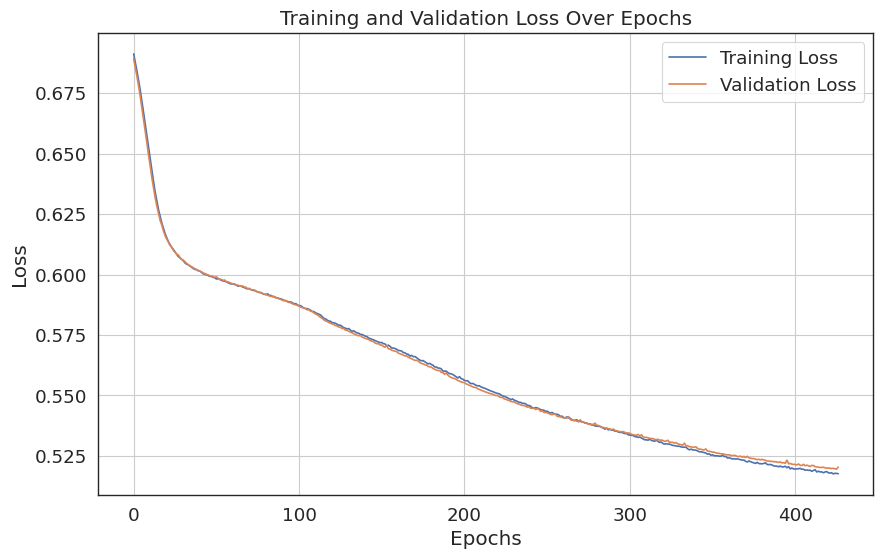

In [88]:
# Ensure that the length of gat_train_loss_list and gat_val_loss_list is equal to the number of epochs processed
assert len(gat_train_loss_list) == len(gat_val_loss_list)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gat_train_loss_list, label='Training Loss')
plt.plot(gat_val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train on merged train and val sets


In [89]:
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_graphs, batch_labels in data_loader:
        batch_graphs = batch_graphs.to(device)
        batch_labels = batch_labels.clone().detach().to(device)
        batch_features = batch_graphs.ndata['h']

        outputs = model(batch_graphs, batch_features)
        outputs = outputs.squeeze() # remove extra dimension
        loss = criterion(outputs, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

## Reset weights before training again with all data


In [90]:
def reset_weights(m):
    """
    This function will reset the weights of a given module.
    """
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

# Example usage with your model
model.apply(reset_weights)

GATClassifier(
  (conv1): GATConv(
    (fc): Linear(in_features=74, out_features=592, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (fc): Linear(in_features=148, out_features=1, bias=True)
)

In [91]:
print("Final training on merged training and validation sets")

# Initialize list to store loss values
final_train_losses = []

for epoch in range(num_epochs_early):
    # Training
    train_loss = train(model, train_loader_all, criterion, optimizer, device)
    final_train_losses.append(train_loss)  # Store train loss

    # Print train loss
    print(f"Epoch {epoch+1}/{num_epochs_early}, Train Loss: {train_loss:.4f}")


Final training on merged training and validation sets


Epoch 1/427, Train Loss: 0.6919


Epoch 2/427, Train Loss: 0.6891


Epoch 3/427, Train Loss: 0.6864


Epoch 4/427, Train Loss: 0.6836


Epoch 5/427, Train Loss: 0.6807


Epoch 6/427, Train Loss: 0.6776


Epoch 7/427, Train Loss: 0.6742


Epoch 8/427, Train Loss: 0.6708


Epoch 9/427, Train Loss: 0.6672


Epoch 10/427, Train Loss: 0.6636


Epoch 11/427, Train Loss: 0.6600


Epoch 12/427, Train Loss: 0.6564


Epoch 13/427, Train Loss: 0.6528


Epoch 14/427, Train Loss: 0.6492


Epoch 15/427, Train Loss: 0.6457


Epoch 16/427, Train Loss: 0.6422


Epoch 17/427, Train Loss: 0.6390


Epoch 18/427, Train Loss: 0.6361


Epoch 19/427, Train Loss: 0.6333


Epoch 20/427, Train Loss: 0.6307


Epoch 21/427, Train Loss: 0.6282


Epoch 22/427, Train Loss: 0.6260


Epoch 23/427, Train Loss: 0.6240


Epoch 24/427, Train Loss: 0.6222


Epoch 25/427, Train Loss: 0.6205


Epoch 26/427, Train Loss: 0.6189


Epoch 27/427, Train Loss: 0.6175


Epoch 28/427, Train Loss: 0.6161


Epoch 29/427, Train Loss: 0.6147


Epoch 30/427, Train Loss: 0.6135


Epoch 31/427, Train Loss: 0.6123


Epoch 32/427, Train Loss: 0.6113


Epoch 33/427, Train Loss: 0.6103


Epoch 34/427, Train Loss: 0.6094


Epoch 35/427, Train Loss: 0.6085


Epoch 36/427, Train Loss: 0.6077


Epoch 37/427, Train Loss: 0.6070


Epoch 38/427, Train Loss: 0.6064


Epoch 39/427, Train Loss: 0.6057


Epoch 40/427, Train Loss: 0.6052


Epoch 41/427, Train Loss: 0.6046


Epoch 42/427, Train Loss: 0.6041


Epoch 43/427, Train Loss: 0.6036


Epoch 44/427, Train Loss: 0.6032


Epoch 45/427, Train Loss: 0.6027


Epoch 46/427, Train Loss: 0.6023


Epoch 47/427, Train Loss: 0.6019


Epoch 48/427, Train Loss: 0.6015


Epoch 49/427, Train Loss: 0.6011


Epoch 50/427, Train Loss: 0.6008


Epoch 51/427, Train Loss: 0.6004


Epoch 52/427, Train Loss: 0.6000


Epoch 53/427, Train Loss: 0.5997


Epoch 54/427, Train Loss: 0.5993


Epoch 55/427, Train Loss: 0.5990


Epoch 56/427, Train Loss: 0.5987


Epoch 57/427, Train Loss: 0.5983


Epoch 58/427, Train Loss: 0.5980


Epoch 59/427, Train Loss: 0.5977


Epoch 60/427, Train Loss: 0.5973


Epoch 61/427, Train Loss: 0.5970


Epoch 62/427, Train Loss: 0.5967


Epoch 63/427, Train Loss: 0.5964


Epoch 64/427, Train Loss: 0.5960


Epoch 65/427, Train Loss: 0.5957


Epoch 66/427, Train Loss: 0.5954


Epoch 67/427, Train Loss: 0.5950


Epoch 68/427, Train Loss: 0.5947


Epoch 69/427, Train Loss: 0.5943


Epoch 70/427, Train Loss: 0.5940


Epoch 71/427, Train Loss: 0.5936


Epoch 72/427, Train Loss: 0.5933


Epoch 73/427, Train Loss: 0.5929


Epoch 74/427, Train Loss: 0.5926


Epoch 75/427, Train Loss: 0.5922


Epoch 76/427, Train Loss: 0.5919


Epoch 77/427, Train Loss: 0.5915


Epoch 78/427, Train Loss: 0.5912


Epoch 79/427, Train Loss: 0.5908


Epoch 80/427, Train Loss: 0.5904


Epoch 81/427, Train Loss: 0.5901


Epoch 82/427, Train Loss: 0.5897


Epoch 83/427, Train Loss: 0.5893


Epoch 84/427, Train Loss: 0.5890


Epoch 85/427, Train Loss: 0.5886


Epoch 86/427, Train Loss: 0.5882


Epoch 87/427, Train Loss: 0.5878


Epoch 88/427, Train Loss: 0.5874


Epoch 89/427, Train Loss: 0.5870


Epoch 90/427, Train Loss: 0.5865


Epoch 91/427, Train Loss: 0.5861


Epoch 92/427, Train Loss: 0.5857


Epoch 93/427, Train Loss: 0.5853


Epoch 94/427, Train Loss: 0.5849


Epoch 95/427, Train Loss: 0.5845


Epoch 96/427, Train Loss: 0.5840


Epoch 97/427, Train Loss: 0.5836


Epoch 98/427, Train Loss: 0.5832


Epoch 99/427, Train Loss: 0.5828


Epoch 100/427, Train Loss: 0.5823


Epoch 101/427, Train Loss: 0.5819


Epoch 102/427, Train Loss: 0.5815


Epoch 103/427, Train Loss: 0.5810


Epoch 104/427, Train Loss: 0.5806


Epoch 105/427, Train Loss: 0.5801


Epoch 106/427, Train Loss: 0.5797


Epoch 107/427, Train Loss: 0.5792


Epoch 108/427, Train Loss: 0.5788


Epoch 109/427, Train Loss: 0.5783


Epoch 110/427, Train Loss: 0.5779


Epoch 111/427, Train Loss: 0.5774


Epoch 112/427, Train Loss: 0.5769


Epoch 113/427, Train Loss: 0.5765


Epoch 114/427, Train Loss: 0.5760


Epoch 115/427, Train Loss: 0.5756


Epoch 116/427, Train Loss: 0.5751


Epoch 117/427, Train Loss: 0.5746


Epoch 118/427, Train Loss: 0.5742


Epoch 119/427, Train Loss: 0.5737


Epoch 120/427, Train Loss: 0.5732


Epoch 121/427, Train Loss: 0.5728


Epoch 122/427, Train Loss: 0.5723


Epoch 123/427, Train Loss: 0.5719


Epoch 124/427, Train Loss: 0.5714


Epoch 125/427, Train Loss: 0.5710


Epoch 126/427, Train Loss: 0.5705


Epoch 127/427, Train Loss: 0.5700


Epoch 128/427, Train Loss: 0.5696


Epoch 129/427, Train Loss: 0.5691


Epoch 130/427, Train Loss: 0.5687


Epoch 131/427, Train Loss: 0.5683


Epoch 132/427, Train Loss: 0.5678


Epoch 133/427, Train Loss: 0.5674


Epoch 134/427, Train Loss: 0.5669


Epoch 135/427, Train Loss: 0.5665


Epoch 136/427, Train Loss: 0.5661


Epoch 137/427, Train Loss: 0.5657


Epoch 138/427, Train Loss: 0.5652


Epoch 139/427, Train Loss: 0.5648


Epoch 140/427, Train Loss: 0.5644


Epoch 141/427, Train Loss: 0.5641


Epoch 142/427, Train Loss: 0.5637


Epoch 143/427, Train Loss: 0.5633


Epoch 144/427, Train Loss: 0.5629


Epoch 145/427, Train Loss: 0.5625


Epoch 146/427, Train Loss: 0.5622


Epoch 147/427, Train Loss: 0.5618


Epoch 148/427, Train Loss: 0.5614


Epoch 149/427, Train Loss: 0.5609


Epoch 150/427, Train Loss: 0.5605


Epoch 151/427, Train Loss: 0.5601


Epoch 152/427, Train Loss: 0.5597


Epoch 153/427, Train Loss: 0.5593


Epoch 154/427, Train Loss: 0.5589


Epoch 155/427, Train Loss: 0.5585


Epoch 156/427, Train Loss: 0.5582


Epoch 157/427, Train Loss: 0.5578


Epoch 158/427, Train Loss: 0.5574


Epoch 159/427, Train Loss: 0.5571


Epoch 160/427, Train Loss: 0.5567


Epoch 161/427, Train Loss: 0.5564


Epoch 162/427, Train Loss: 0.5560


Epoch 163/427, Train Loss: 0.5557


Epoch 164/427, Train Loss: 0.5554


Epoch 165/427, Train Loss: 0.5551


Epoch 166/427, Train Loss: 0.5547


Epoch 167/427, Train Loss: 0.5544


Epoch 168/427, Train Loss: 0.5541


Epoch 169/427, Train Loss: 0.5538


Epoch 170/427, Train Loss: 0.5535


Epoch 171/427, Train Loss: 0.5531


Epoch 172/427, Train Loss: 0.5528


Epoch 173/427, Train Loss: 0.5525


Epoch 174/427, Train Loss: 0.5522


Epoch 175/427, Train Loss: 0.5519


Epoch 176/427, Train Loss: 0.5516


Epoch 177/427, Train Loss: 0.5513


Epoch 178/427, Train Loss: 0.5510


Epoch 179/427, Train Loss: 0.5508


Epoch 180/427, Train Loss: 0.5505


Epoch 181/427, Train Loss: 0.5502


Epoch 182/427, Train Loss: 0.5499


Epoch 183/427, Train Loss: 0.5496


Epoch 184/427, Train Loss: 0.5493


Epoch 185/427, Train Loss: 0.5490


Epoch 186/427, Train Loss: 0.5487


Epoch 187/427, Train Loss: 0.5484


Epoch 188/427, Train Loss: 0.5481


Epoch 189/427, Train Loss: 0.5478


Epoch 190/427, Train Loss: 0.5475


Epoch 191/427, Train Loss: 0.5472


Epoch 192/427, Train Loss: 0.5469


Epoch 193/427, Train Loss: 0.5466


Epoch 194/427, Train Loss: 0.5463


Epoch 195/427, Train Loss: 0.5460


Epoch 196/427, Train Loss: 0.5457


Epoch 197/427, Train Loss: 0.5454


Epoch 198/427, Train Loss: 0.5451


Epoch 199/427, Train Loss: 0.5448


Epoch 200/427, Train Loss: 0.5445


Epoch 201/427, Train Loss: 0.5442


Epoch 202/427, Train Loss: 0.5439


Epoch 203/427, Train Loss: 0.5437


Epoch 204/427, Train Loss: 0.5434


Epoch 205/427, Train Loss: 0.5431


Epoch 206/427, Train Loss: 0.5429


Epoch 207/427, Train Loss: 0.5426


Epoch 208/427, Train Loss: 0.5424


Epoch 209/427, Train Loss: 0.5421


Epoch 210/427, Train Loss: 0.5418


Epoch 211/427, Train Loss: 0.5416


Epoch 212/427, Train Loss: 0.5414


Epoch 213/427, Train Loss: 0.5411


Epoch 214/427, Train Loss: 0.5409


Epoch 215/427, Train Loss: 0.5407


Epoch 216/427, Train Loss: 0.5404


Epoch 217/427, Train Loss: 0.5402


Epoch 218/427, Train Loss: 0.5400


Epoch 219/427, Train Loss: 0.5397


Epoch 220/427, Train Loss: 0.5393


Epoch 221/427, Train Loss: 0.5390


Epoch 222/427, Train Loss: 0.5387


Epoch 223/427, Train Loss: 0.5384


Epoch 224/427, Train Loss: 0.5382


Epoch 225/427, Train Loss: 0.5379


Epoch 226/427, Train Loss: 0.5377


Epoch 227/427, Train Loss: 0.5375


Epoch 228/427, Train Loss: 0.5372


Epoch 229/427, Train Loss: 0.5370


Epoch 230/427, Train Loss: 0.5368


Epoch 231/427, Train Loss: 0.5366


Epoch 232/427, Train Loss: 0.5363


Epoch 233/427, Train Loss: 0.5361


Epoch 234/427, Train Loss: 0.5359


Epoch 235/427, Train Loss: 0.5357


Epoch 236/427, Train Loss: 0.5355


Epoch 237/427, Train Loss: 0.5353


Epoch 238/427, Train Loss: 0.5351


Epoch 239/427, Train Loss: 0.5348


Epoch 240/427, Train Loss: 0.5346


Epoch 241/427, Train Loss: 0.5344


Epoch 242/427, Train Loss: 0.5341


Epoch 243/427, Train Loss: 0.5339


Epoch 244/427, Train Loss: 0.5336


Epoch 245/427, Train Loss: 0.5334


Epoch 246/427, Train Loss: 0.5332


Epoch 247/427, Train Loss: 0.5330


Epoch 248/427, Train Loss: 0.5328


Epoch 249/427, Train Loss: 0.5326


Epoch 250/427, Train Loss: 0.5324


Epoch 251/427, Train Loss: 0.5322


Epoch 252/427, Train Loss: 0.5320


Epoch 253/427, Train Loss: 0.5318


Epoch 254/427, Train Loss: 0.5316


Epoch 255/427, Train Loss: 0.5314


Epoch 256/427, Train Loss: 0.5312


Epoch 257/427, Train Loss: 0.5310


Epoch 258/427, Train Loss: 0.5308


Epoch 259/427, Train Loss: 0.5306


Epoch 260/427, Train Loss: 0.5304


Epoch 261/427, Train Loss: 0.5302


Epoch 262/427, Train Loss: 0.5300


Epoch 263/427, Train Loss: 0.5299


Epoch 264/427, Train Loss: 0.5297


Epoch 265/427, Train Loss: 0.5295


Epoch 266/427, Train Loss: 0.5293


Epoch 267/427, Train Loss: 0.5291


Epoch 268/427, Train Loss: 0.5290


Epoch 269/427, Train Loss: 0.5288


Epoch 270/427, Train Loss: 0.5286


Epoch 271/427, Train Loss: 0.5284


Epoch 272/427, Train Loss: 0.5282


Epoch 273/427, Train Loss: 0.5281


Epoch 274/427, Train Loss: 0.5279


Epoch 275/427, Train Loss: 0.5278


Epoch 276/427, Train Loss: 0.5276


Epoch 277/427, Train Loss: 0.5274


Epoch 278/427, Train Loss: 0.5273


Epoch 279/427, Train Loss: 0.5271


Epoch 280/427, Train Loss: 0.5270


Epoch 281/427, Train Loss: 0.5268


Epoch 282/427, Train Loss: 0.5267


Epoch 283/427, Train Loss: 0.5265


Epoch 284/427, Train Loss: 0.5264


Epoch 285/427, Train Loss: 0.5262


Epoch 286/427, Train Loss: 0.5261


Epoch 287/427, Train Loss: 0.5259


Epoch 288/427, Train Loss: 0.5258


Epoch 289/427, Train Loss: 0.5257


Epoch 290/427, Train Loss: 0.5255


Epoch 291/427, Train Loss: 0.5254


Epoch 292/427, Train Loss: 0.5252


Epoch 293/427, Train Loss: 0.5251


Epoch 294/427, Train Loss: 0.5250


Epoch 295/427, Train Loss: 0.5248


Epoch 296/427, Train Loss: 0.5247


Epoch 297/427, Train Loss: 0.5246


Epoch 298/427, Train Loss: 0.5244


Epoch 299/427, Train Loss: 0.5243


Epoch 300/427, Train Loss: 0.5242


Epoch 301/427, Train Loss: 0.5240


Epoch 302/427, Train Loss: 0.5239


Epoch 303/427, Train Loss: 0.5238


Epoch 304/427, Train Loss: 0.5237


Epoch 305/427, Train Loss: 0.5236


Epoch 306/427, Train Loss: 0.5234


Epoch 307/427, Train Loss: 0.5233


Epoch 308/427, Train Loss: 0.5232


Epoch 309/427, Train Loss: 0.5231


Epoch 310/427, Train Loss: 0.5230


Epoch 311/427, Train Loss: 0.5228


Epoch 312/427, Train Loss: 0.5227


Epoch 313/427, Train Loss: 0.5226


Epoch 314/427, Train Loss: 0.5225


Epoch 315/427, Train Loss: 0.5224


Epoch 316/427, Train Loss: 0.5222


Epoch 317/427, Train Loss: 0.5221


Epoch 318/427, Train Loss: 0.5220


Epoch 319/427, Train Loss: 0.5219


Epoch 320/427, Train Loss: 0.5218


Epoch 321/427, Train Loss: 0.5217


Epoch 322/427, Train Loss: 0.5215


Epoch 323/427, Train Loss: 0.5214


Epoch 324/427, Train Loss: 0.5213


Epoch 325/427, Train Loss: 0.5212


Epoch 326/427, Train Loss: 0.5211


Epoch 327/427, Train Loss: 0.5210


Epoch 328/427, Train Loss: 0.5209


Epoch 329/427, Train Loss: 0.5208


Epoch 330/427, Train Loss: 0.5207


Epoch 331/427, Train Loss: 0.5206


Epoch 332/427, Train Loss: 0.5205


Epoch 333/427, Train Loss: 0.5204


Epoch 334/427, Train Loss: 0.5203


Epoch 335/427, Train Loss: 0.5202


Epoch 336/427, Train Loss: 0.5201


Epoch 337/427, Train Loss: 0.5200


Epoch 338/427, Train Loss: 0.5199


Epoch 339/427, Train Loss: 0.5198


Epoch 340/427, Train Loss: 0.5197


Epoch 341/427, Train Loss: 0.5196


Epoch 342/427, Train Loss: 0.5195


Epoch 343/427, Train Loss: 0.5194


Epoch 344/427, Train Loss: 0.5193


Epoch 345/427, Train Loss: 0.5192


Epoch 346/427, Train Loss: 0.5191


Epoch 347/427, Train Loss: 0.5190


Epoch 348/427, Train Loss: 0.5190


Epoch 349/427, Train Loss: 0.5189


Epoch 350/427, Train Loss: 0.5188


Epoch 351/427, Train Loss: 0.5187


Epoch 352/427, Train Loss: 0.5186


Epoch 353/427, Train Loss: 0.5185


Epoch 354/427, Train Loss: 0.5185


Epoch 355/427, Train Loss: 0.5184


Epoch 356/427, Train Loss: 0.5183


Epoch 357/427, Train Loss: 0.5182


Epoch 358/427, Train Loss: 0.5181


Epoch 359/427, Train Loss: 0.5180


Epoch 360/427, Train Loss: 0.5180


Epoch 361/427, Train Loss: 0.5179


Epoch 362/427, Train Loss: 0.5178


Epoch 363/427, Train Loss: 0.5177


Epoch 364/427, Train Loss: 0.5177


Epoch 365/427, Train Loss: 0.5176


Epoch 366/427, Train Loss: 0.5175


Epoch 367/427, Train Loss: 0.5174


Epoch 368/427, Train Loss: 0.5174


Epoch 369/427, Train Loss: 0.5173


Epoch 370/427, Train Loss: 0.5172


Epoch 371/427, Train Loss: 0.5172


Epoch 372/427, Train Loss: 0.5171


Epoch 373/427, Train Loss: 0.5170


Epoch 374/427, Train Loss: 0.5169


Epoch 375/427, Train Loss: 0.5169


Epoch 376/427, Train Loss: 0.5168


Epoch 377/427, Train Loss: 0.5167


Epoch 378/427, Train Loss: 0.5167


Epoch 379/427, Train Loss: 0.5166


Epoch 380/427, Train Loss: 0.5165


Epoch 381/427, Train Loss: 0.5165


Epoch 382/427, Train Loss: 0.5164


Epoch 383/427, Train Loss: 0.5163


Epoch 384/427, Train Loss: 0.5163


Epoch 385/427, Train Loss: 0.5162


Epoch 386/427, Train Loss: 0.5161


Epoch 387/427, Train Loss: 0.5161


Epoch 388/427, Train Loss: 0.5160


Epoch 389/427, Train Loss: 0.5159


Epoch 390/427, Train Loss: 0.5159


Epoch 391/427, Train Loss: 0.5158


Epoch 392/427, Train Loss: 0.5158


Epoch 393/427, Train Loss: 0.5157


Epoch 394/427, Train Loss: 0.5156


Epoch 395/427, Train Loss: 0.5156


Epoch 396/427, Train Loss: 0.5155


Epoch 397/427, Train Loss: 0.5155


Epoch 398/427, Train Loss: 0.5154


Epoch 399/427, Train Loss: 0.5153


Epoch 400/427, Train Loss: 0.5153


Epoch 401/427, Train Loss: 0.5152


Epoch 402/427, Train Loss: 0.5152


Epoch 403/427, Train Loss: 0.5151


Epoch 404/427, Train Loss: 0.5151


Epoch 405/427, Train Loss: 0.5150


Epoch 406/427, Train Loss: 0.5150


Epoch 407/427, Train Loss: 0.5149


Epoch 408/427, Train Loss: 0.5148


Epoch 409/427, Train Loss: 0.5148


Epoch 410/427, Train Loss: 0.5147


Epoch 411/427, Train Loss: 0.5147


Epoch 412/427, Train Loss: 0.5146


Epoch 413/427, Train Loss: 0.5146


Epoch 414/427, Train Loss: 0.5145


Epoch 415/427, Train Loss: 0.5145


Epoch 416/427, Train Loss: 0.5144


Epoch 417/427, Train Loss: 0.5144


Epoch 418/427, Train Loss: 0.5143


Epoch 419/427, Train Loss: 0.5143


Epoch 420/427, Train Loss: 0.5142


Epoch 421/427, Train Loss: 0.5142


Epoch 422/427, Train Loss: 0.5141


Epoch 423/427, Train Loss: 0.5141


Epoch 424/427, Train Loss: 0.5140


Epoch 425/427, Train Loss: 0.5140


Epoch 426/427, Train Loss: 0.5139


Epoch 427/427, Train Loss: 0.5139


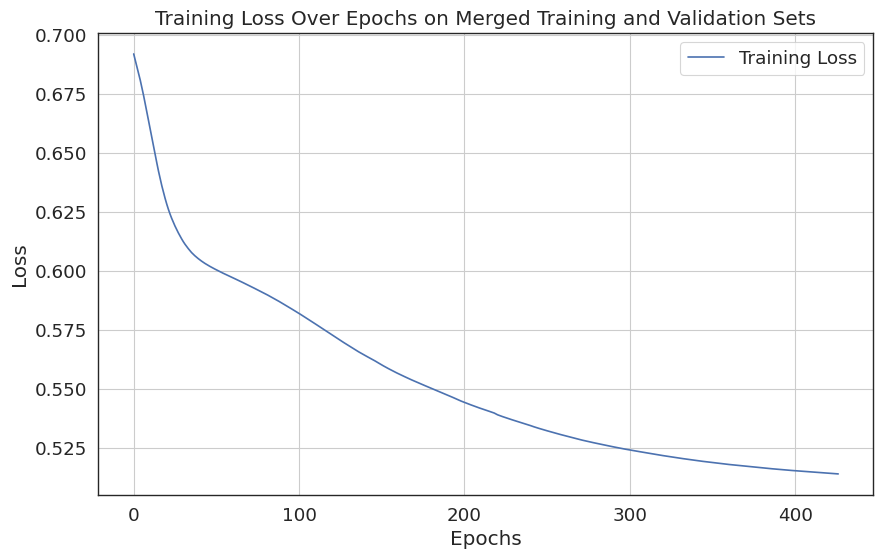

In [92]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(final_train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs on Merged Training and Validation Sets')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Save the model

In [93]:
# if there is not a folder named 'model' create one
if not os.path.exists('model_experiment'):
    os.mkdir('model_experiment')

# save the model
torch.save(model.state_dict(), 'model_experiment/gat_model_experiment.pth')

In [94]:
# load the model
model = GATClassifier(in_feats, hidden_size=148, num_heads=4).to(device)
model.load_state_dict(torch.load('model_experiment/gat_model_experiment.pth'))

<All keys matched successfully>

## Test the model

## Predict probabilities

In [95]:
y_true, y_pred, y_pred_proba = test(model, test_loader, device)

confidence_percentages = [prob * 100 for prob in y_pred_proba]

y_pred_proba = np.array(y_pred_proba)

## Results

In [96]:
print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
print(f'Precision: {precision_score(y_true, y_pred)}')
print(f'Recall: {recall_score(y_true, y_pred)}')
print(f'F1: {f1_score(y_true, y_pred)}')
print(f'AUC: {roc_auc_score(y_true, y_pred_proba)}')

Accuracy: 0.7448252227553118
Precision: 0.7381432218191589
Recall: 0.755916345624656
F1: 0.7469240704234925
AUC: 0.8239990246596645


In [97]:
# Accuracy: 0.7387478849407784
# Precision: 0.7532486494378742
# Recall: 0.7039159503342884
# F1: 0.727747213993511
# AUC: 0.8162738424254579


## Confusion matrix

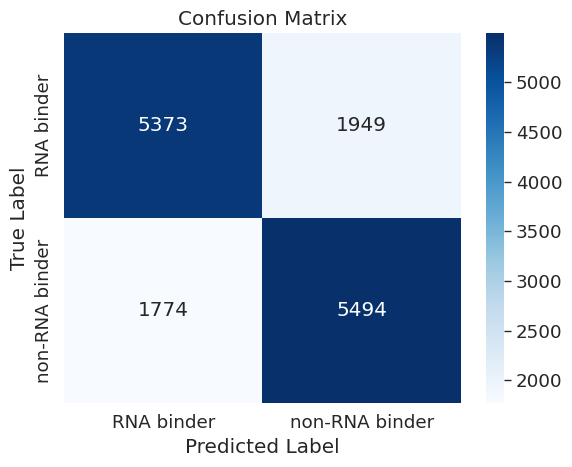

In [98]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['RNA binder', 'non-RNA binder'], columns=['RNA binder', 'non-RNA binder'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
sns.set(context='paper', style='white', font_scale=1.5)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('visuals/confusion_matrix_gat_experiment.png', dpi=300)
plt.show()



## Classification report

In [99]:
# classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      7322
         1.0       0.74      0.76      0.75      7268

    accuracy                           0.74     14590
   macro avg       0.74      0.74      0.74     14590
weighted avg       0.74      0.74      0.74     14590



## ROC AUC

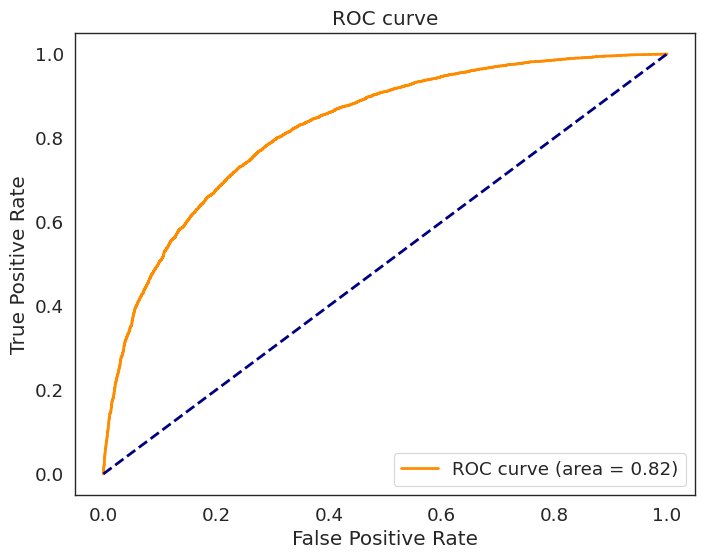

In [100]:
# visualize ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)'% roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('visuals/roc_curve_gat_experiment.png', dpi=300)
plt.show()


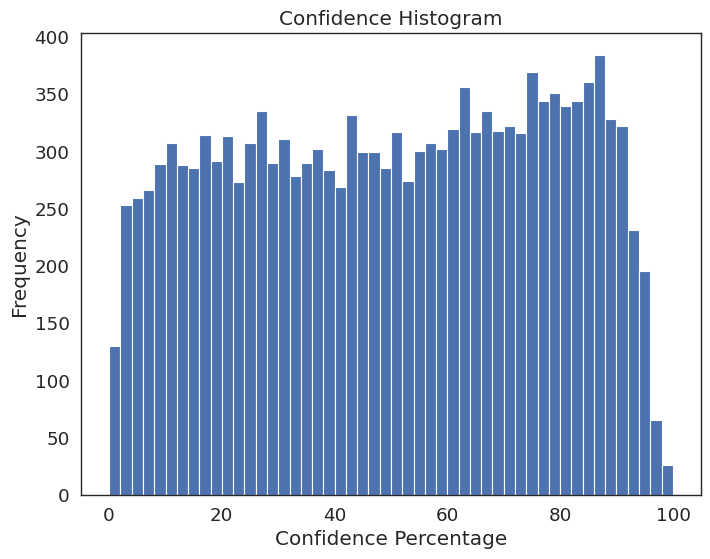

In [101]:
# visualize confidence_percentages in plot
plt.figure(figsize=(8, 6))
plt.hist(confidence_percentages, bins=50)
plt.title('Confidence Histogram')
plt.xlabel('Confidence Percentage')
plt.ylabel('Frequency')
plt.savefig('visuals/confidence_histogram_gat_experiment.png', dpi=300)
plt.show()


In [102]:
# Sort test predictions by confidence and get top 10 indices
sorted_pairs = sorted(enumerate(confidence_percentages), key=lambda x: x[1], reverse=True)
top_molecules_test_indices = [index for index, _ in sorted_pairs[:20]]

# The indices in test_graphs correspond to their positions in the original loaded_graphs_orig
# Find the original indices in loaded_graphs_orig
original_indices = [loaded_graphs_orig.index(test_graphs[i]) for i in top_molecules_test_indices]

# Use the original indices to look up the corresponding rows in reconstructed_df
top_molecule_row_indices = reconstructed_df.index[original_indices]

# Now, top_molecule_row_indices contains the DataFrame indices of the top 10 RNA-binding molecules


In [103]:
# create folder 'top_molecules' if it does not exist
if not os.path.exists('top_molecules_gat_experiment'):
    os.mkdir('top_molecules_gat_experiment')
    

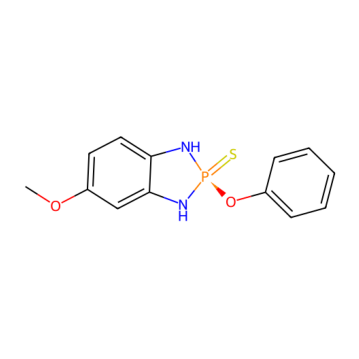

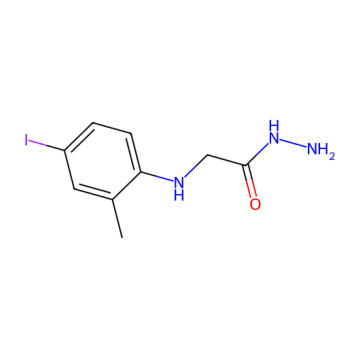

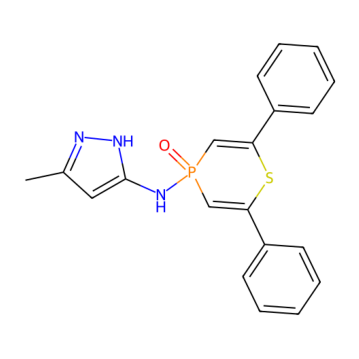

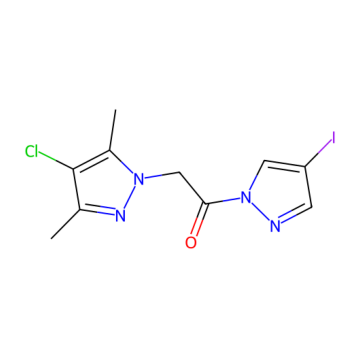

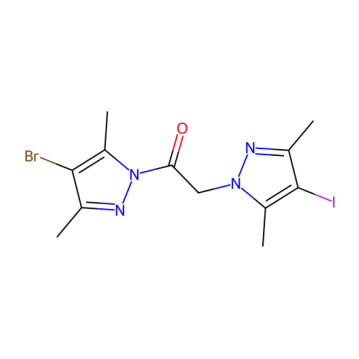

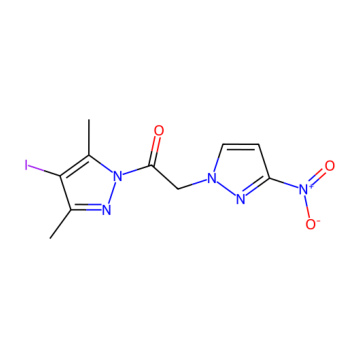

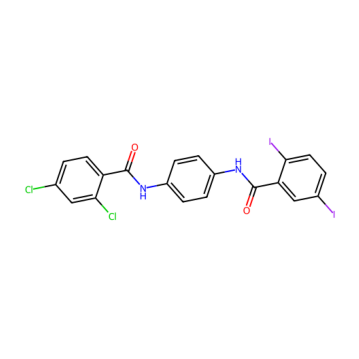

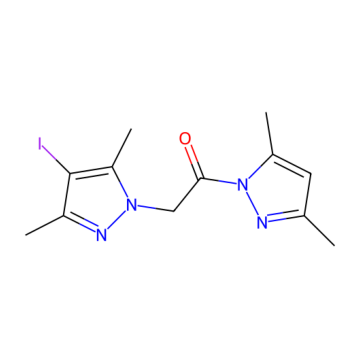

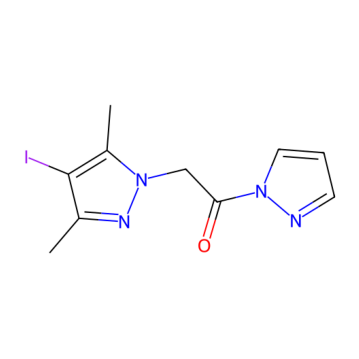

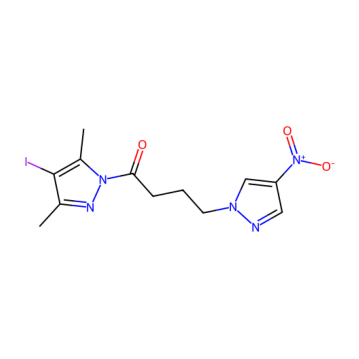

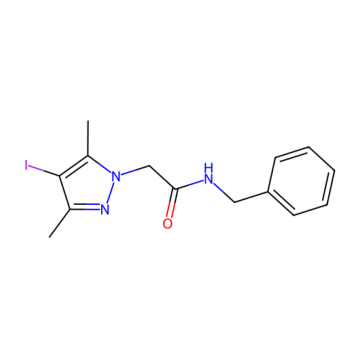

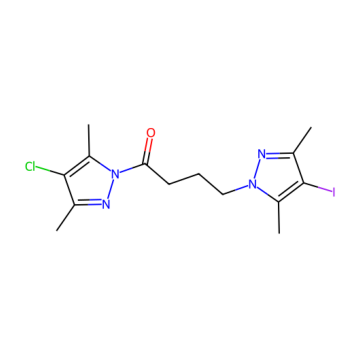

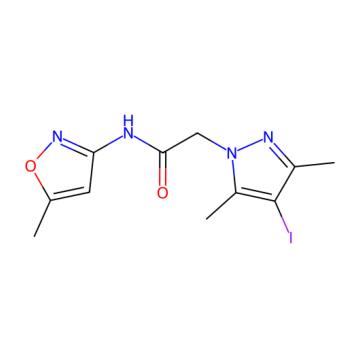

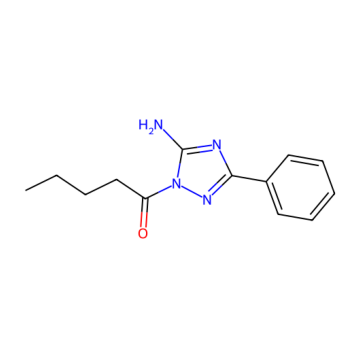

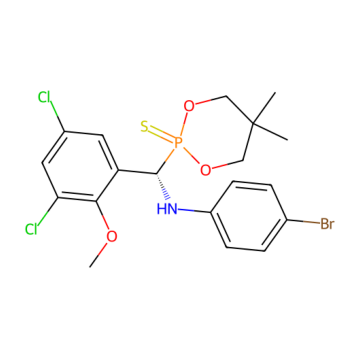

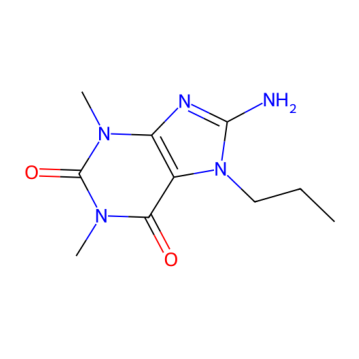

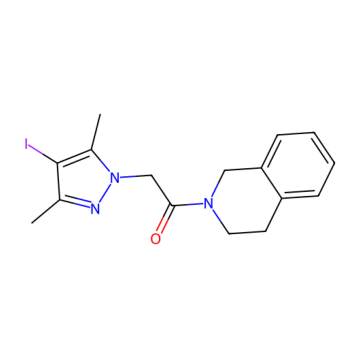

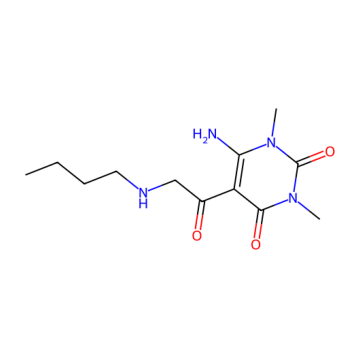

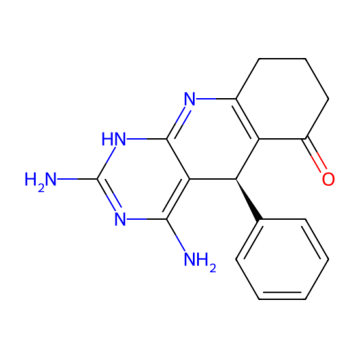

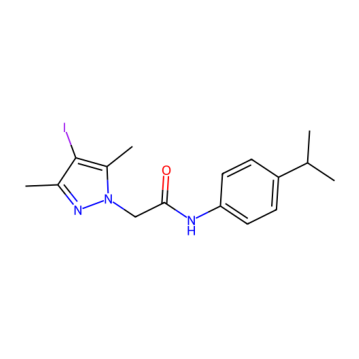

In [104]:
# Retrieve the SMILES codes and source information for the top 10 molecules
top_smiles = df_small.iloc[top_molecule_row_indices]['SMILES'].tolist()
top_sources = df_small.iloc[top_molecule_row_indices]['source'].tolist()

# Retrieve the confidence scores using the indices relative to the test dataset
top_confidences = [confidence_percentages[i] for i in top_molecules_test_indices]

# Convert SMILES to RDKit Mol objects
mols = [Chem.MolFromSmiles(smile) for smile in top_smiles]

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(500, 500))
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    # title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    # plt.title(title)
    plt.subplots_adjust(bottom=0.20)  # Adjust the position of the title
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat_experiment/molecule_{i+1}_{top_sources[i]}_a.png", dpi=300)
    plt.show()


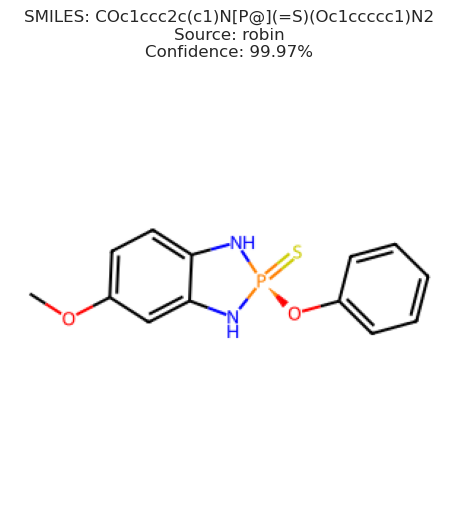

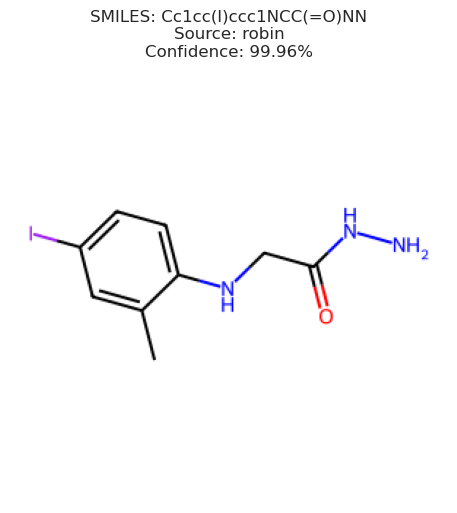

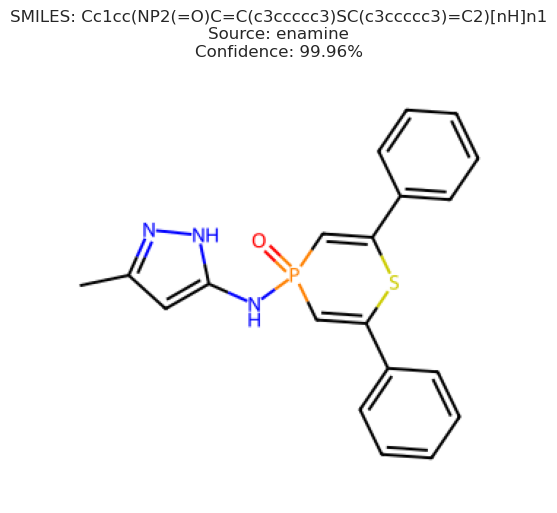

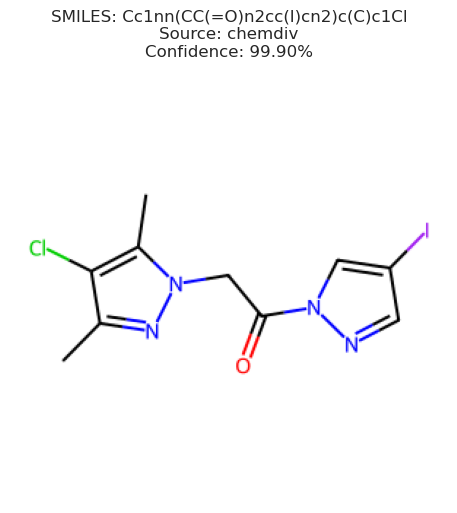

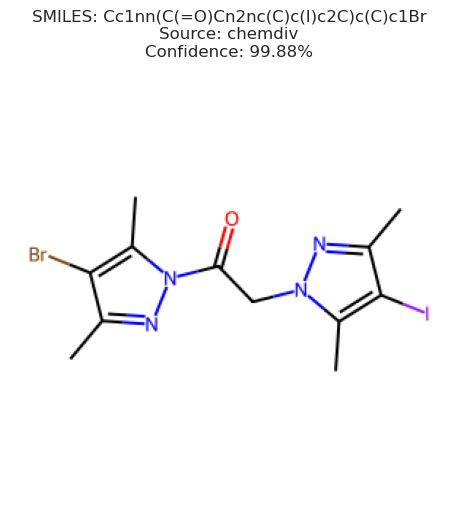

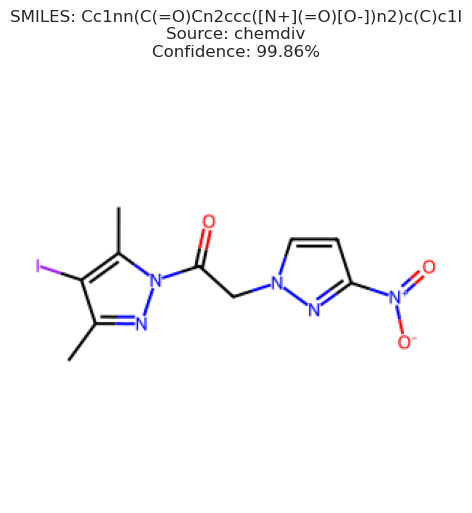

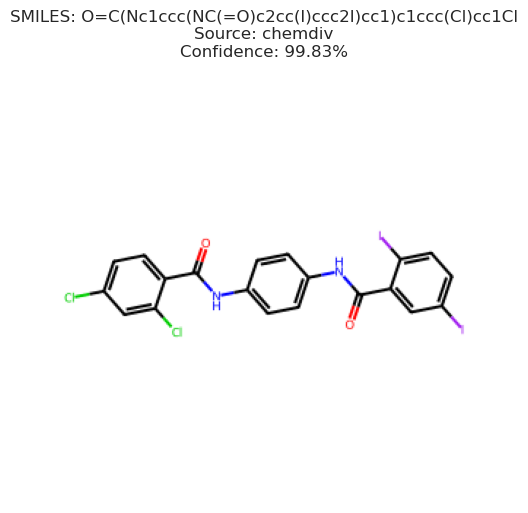

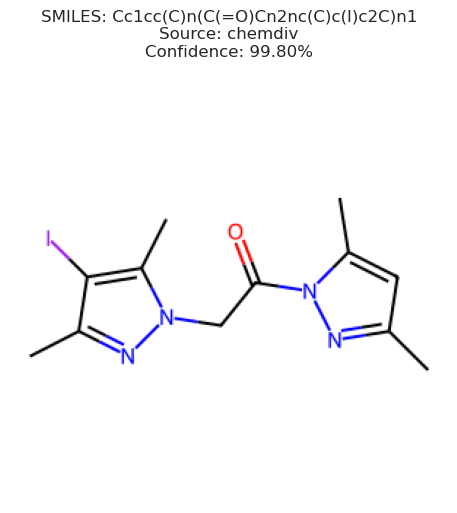

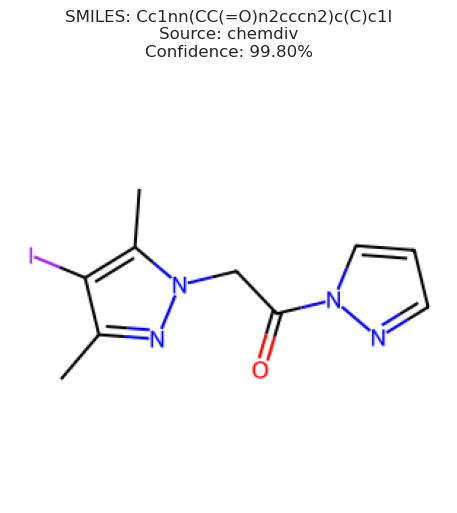

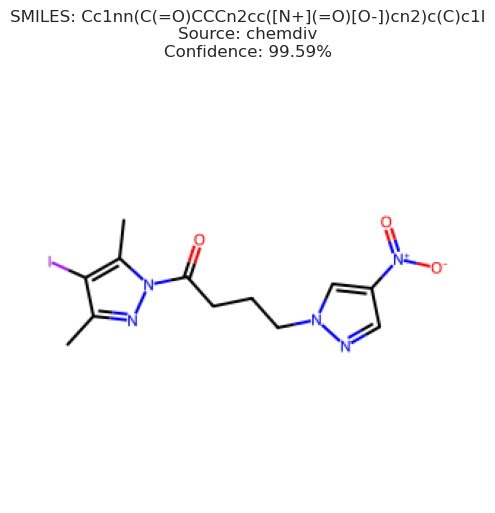

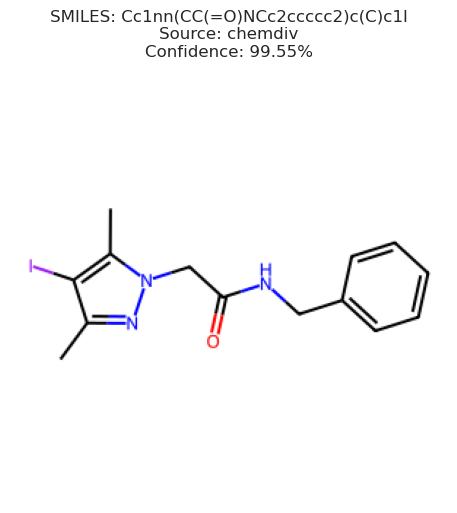

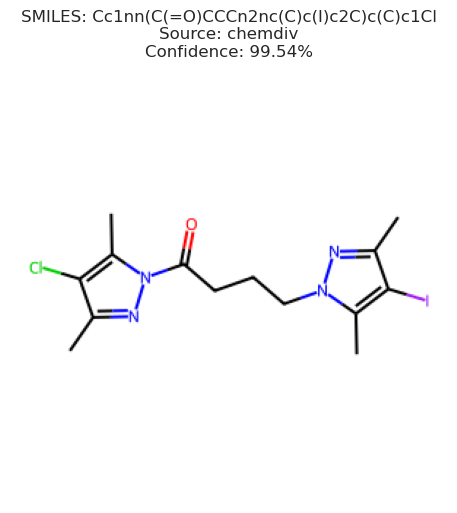

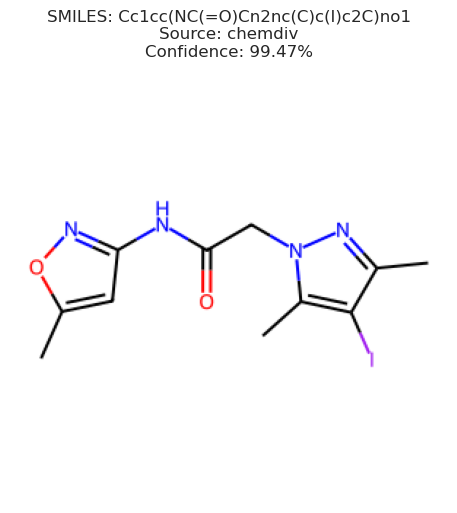

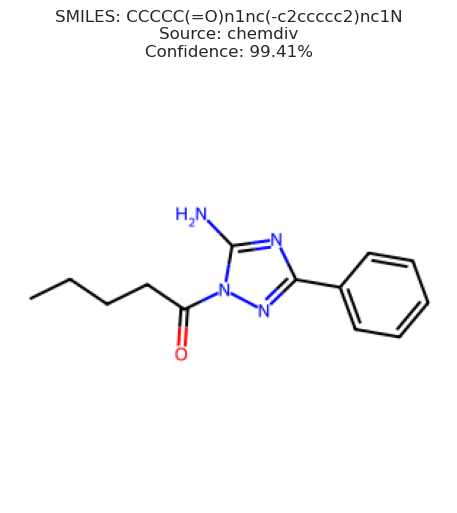

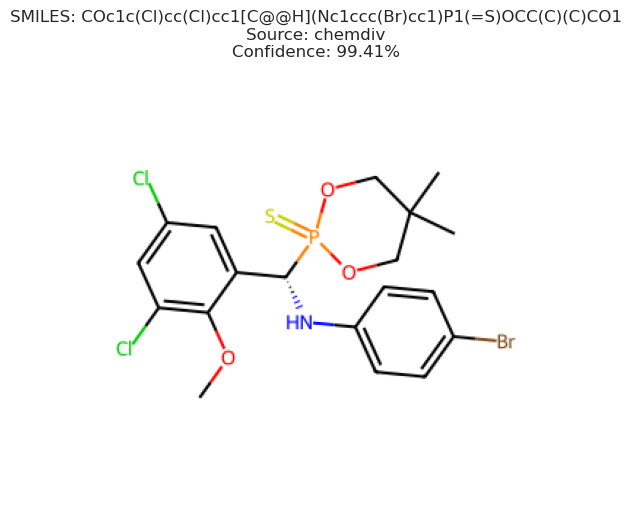

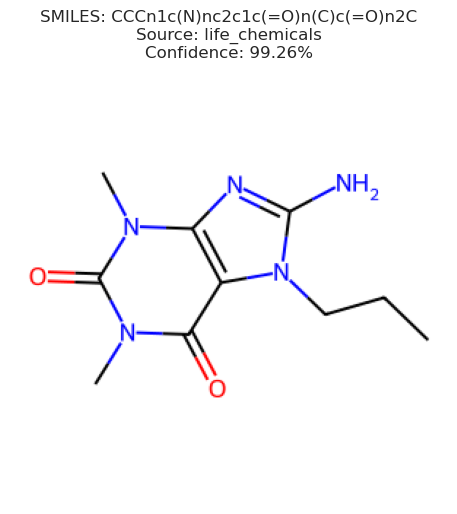

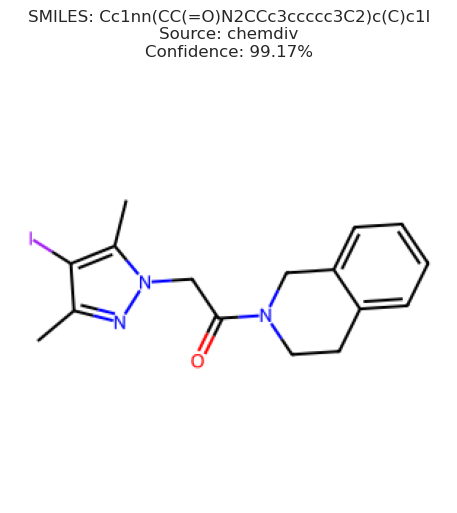

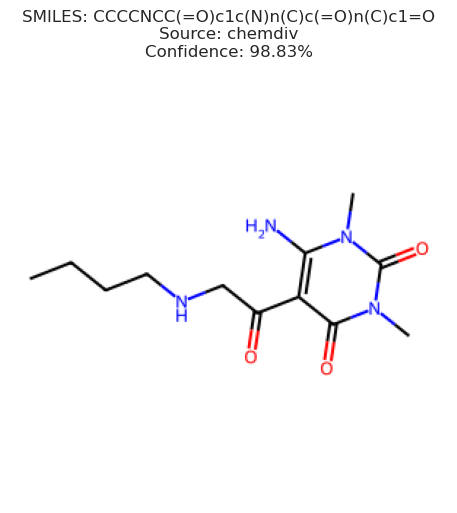

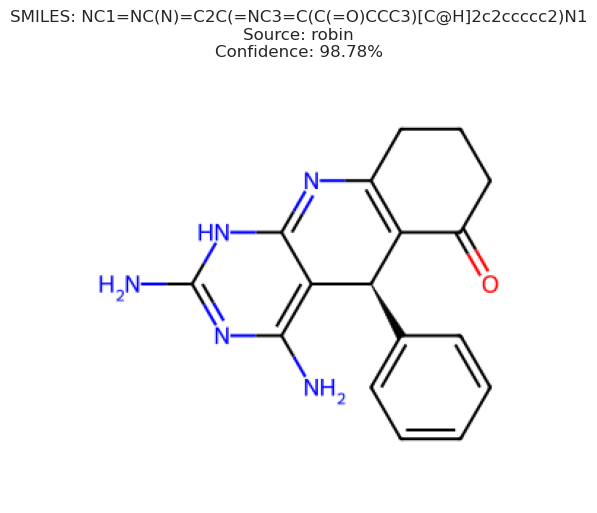

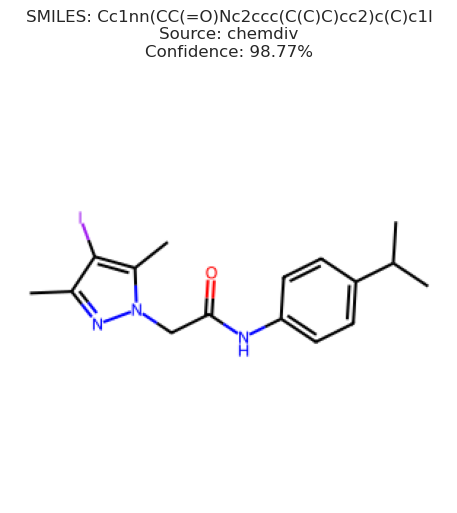

In [105]:
# Define the figure size and font size for titles
fig_size = (6, 6)
title_font_size = 12

# Generate and save images for each molecule
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=(300, 300))
    
    # Create a figure with adjusted size
    plt.figure(figsize=fig_size)
    plt.imshow(img)
    
    # Adjust the position of the text within the image
    title = f"SMILES: {top_smiles[i]}\nSource: {top_sources[i]}\nConfidence: {top_confidences[i]:.2f}%"
    plt.title(title, fontsize=title_font_size)
    plt.subplots_adjust(bottom=0.15)  # Adjust the position of the title
    
    plt.axis('off')
    
    # Save the image to the 'top_molecules' folder using the rank and source as the filename
    plt.savefig(f"top_molecules_gat_experiment/molecule_{i+1}_{top_sources[i]}_b.png", dpi=300)
    plt.show()


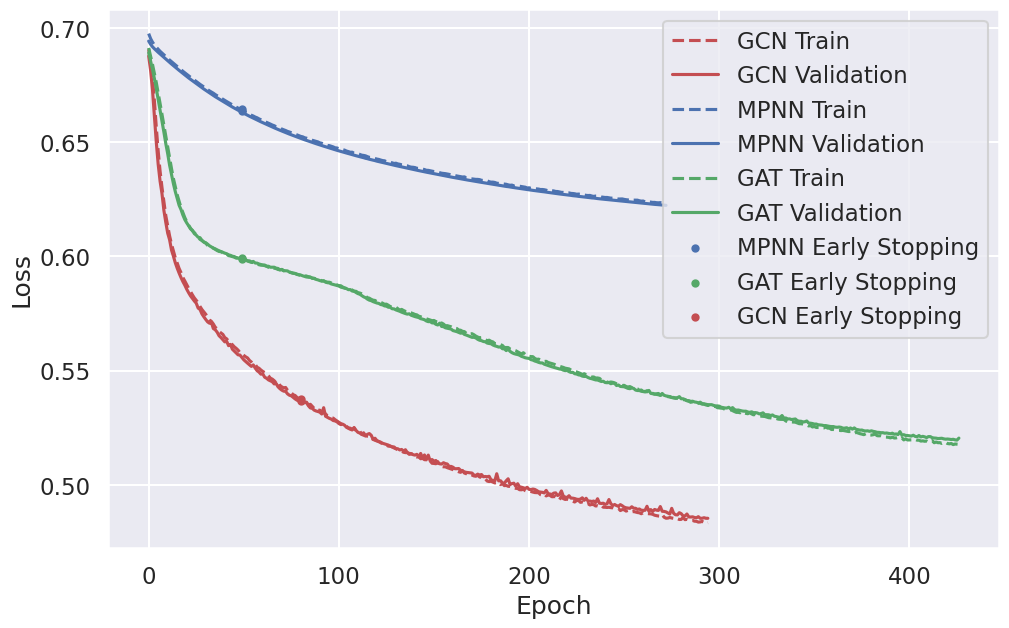

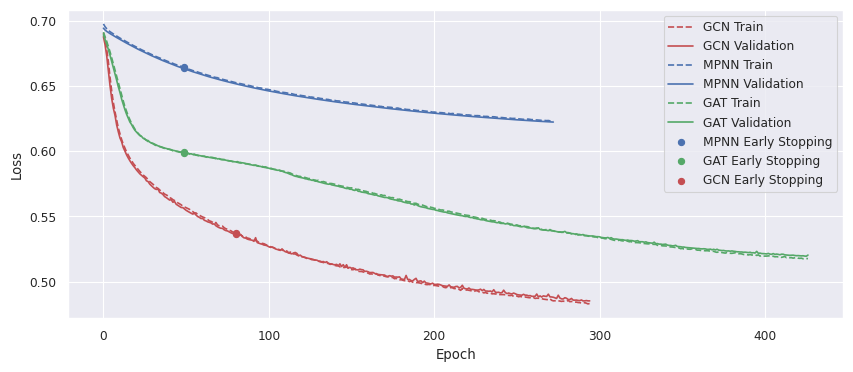

In [106]:
# Plot the training and validation loss, same model will have same color but different line style use seaborn and style report and second plot style to talk-presentation
sns.set(context='talk', rc={'figure.figsize': (11.5, 7)})

plt.plot(gcn_train_loss_list, label='GCN Train', color='r', linestyle='--')
plt.plot(gcn_val_loss_list, label='GCN Validation', color='r', linestyle='-')
plt.plot(mpnn_train_loss_list, label='MPNN Train', color='b', linestyle='--')
plt.plot(mpnn_val_loss_list, label='MPNN Validation', color='b', linestyle='-')
plt.plot(gat_train_loss_list, label='GAT Train', color='g', linestyle='--')
plt.plot(gat_val_loss_list, label='GAT Validation', color='g', linestyle='-')

# Markers for early stopping
plt.scatter(49, mpnn_train_loss_list[48], color='b', marker='o', s=20, label='MPNN Early Stopping')
plt.scatter(49, mpnn_val_loss_list[48], color='b', marker='o', s=20)
plt.scatter(49, gat_train_loss_list[48], color='g', marker='o', s=20, label='GAT Early Stopping')
plt.scatter(49, gat_val_loss_list[48], color='g', marker='o', s=20)
plt.scatter(80, gcn_train_loss_list[79], color='r', marker='o', s=20, label='GCN Early Stopping')
plt.scatter(80, gcn_val_loss_list[79], color='r', marker='o', s=20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('visuals/loss_talk_experiment.png', dpi=300)
plt.show()


# Plot the training and validation loss, same model will have same color but different line style use seaborn and style report and second plot style to talk-presentation
sns.set(context='paper', rc={'figure.figsize': (10, 4)})


plt.plot(gcn_train_loss_list, label='GCN Train', color='r', linestyle='--')
plt.plot(gcn_val_loss_list, label='GCN Validation', color='r', linestyle='-')
plt.plot(mpnn_train_loss_list, label='MPNN Train', color='b', linestyle='--')
plt.plot(mpnn_val_loss_list, label='MPNN Validation', color='b', linestyle='-')
plt.plot(gat_train_loss_list, label='GAT Train', color='g', linestyle='--')
plt.plot(gat_val_loss_list, label='GAT Validation', color='g', linestyle='-')

# Markers for early stopping
plt.scatter(49, mpnn_train_loss_list[48], color='b', marker='o', s=20, label='MPNN Early Stopping')
plt.scatter(49, mpnn_val_loss_list[48], color='b', marker='o', s=20)
plt.scatter(49, gat_train_loss_list[48], color='g', marker='o', s=20, label='GAT Early Stopping')
plt.scatter(49, gat_val_loss_list[48], color='g', marker='o', s=20)
plt.scatter(80, gcn_train_loss_list[79], color='r', marker='o', s=20, label='GCN Early Stopping')
plt.scatter(80, gcn_val_loss_list[79], color='r', marker='o', s=20)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('visuals/loss_paper_experiment.png', dpi=300)
plt.show()


